# Assessment of the Results of Docking for Thrombin

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import sys
import os
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
import polars as pl
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Add the root directory of your project to the Python path
project_root = '/Users/aakankschitnandkeolyar/Desktop/PRISMS'
if project_root not in sys.path:
    sys.path.append(project_root)
# Import functionalities from enumeration_utils.py
from PRISMS.library_enumeration.enumeration_utils import find_reactants_from_product_code
# Import functionalities from library_analysis_utils.py
from PRISMS.library_analysis.library_analysis_utils import compile_product_scores, compile_product_smiles

In [19]:
def read_smi_file(file_path):
    """
    Read a .smi file and create a dictionary with building block codes as keys and SMILES as items.
    
    :param file_path: The path to the .smi file.
    :return: A dictionary with building block codes as keys and SMILES as items.
    """
    building_block_dict = {}
    
    with open(file_path, 'r') as file:
        for line in file:
            smiles, code = line.strip().split()
            building_block_dict[code] = smiles
    
    return building_block_dict

## Compile the scores and dictionary of product codes

In [9]:
# Generate Dictionary to map product codes to product SMILES
prod_SMILES_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide"
prod_smiles_dict = compile_product_smiles(prod_SMILES_dir)

In [34]:
# Import Data from Brute force docking
prod_scores_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores"
prod_scores_df = compile_product_scores(prod_scores_dir)

In [10]:
# Generate a Dictionary to map product codes to product SMILES (protected products)
prod_SMILES_dir_prot = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/protected_prods"
prod_smiles_dict_prot = compile_product_smiles(prod_SMILES_dir_prot)

prod_scores_dir = "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores"
prod_scores_df = compile_product_scores(prod_scores_dir)

In [11]:
# Add a new column for SMILES strings by mapping Product_Code to SMILES using the dictionary
prod_scores_df = prod_scores_df.with_columns(
    pl.Series("SMILES", [prod_smiles_dict_prot.get(code, None) for code in prod_scores_df["Product_Code"].to_list()])
)

# Select only the SMILES strings and scores
smiles_scores_df = prod_scores_df.select(["SMILES", "Scores"])

# Write the SMILES strings and scores to a .csv file
output_file = os.path.join(prod_scores_dir, "smiles_scores.csv")
smiles_scores_df.write_csv(output_file)

print(f"SMILES strings and scores have been written to {output_file}")

SMILES strings and scores have been written to /Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores/smiles_scores.csv


## Docking Success Rate
Here I want to estimate what percentage of the library was successfully docked. Additionally, I would like to see if there was any common substructure amongst the compounds that failed to dock.

In [12]:
# Find the products that were not docked 
undocked_prods = set(prod_smiles_dict.keys()) - set(prod_scores_df["Product_Code"])
print(f"Number of undocked products: {len(undocked_prods)}")
print("Undocked products:")
for prod in undocked_prods:
    print(prod)

Number of undocked products: 27
Undocked products:
CA5_AA34_AA18
CA5_AA26_AA18
CA5_AA29_AA5
CA5_AA3_AA51
CA5_AA29_AA3
CA5_AA3_AA25
CA5_AA3_AA56
CA5_AA31_AA3
CA5_AA3_AA54
CA5_AA36_AA5
CA5_AA3_AA58
CA5_AA3_AA42
CA5_AA3_AA39
CA5_AA3_AA57
CA5_AA3_AA3
CA5_AA31_AA39
CA5_AA3_AA1
CA5_AA3_AA10
CA5_AA14_AA3
CA5_AA29_AA36
CA5_AA3_AA18
CA5_AA29_AA39
CA5_AA3_AA49
CA5_AA29_AA12
CA5_AA36_AA18
CA5_AA3_AA52
CA5_AA3_AA55


In [14]:
import polars as pl

# Create a new DataFrame for undocked products with a score of +10
undocked_df = pl.DataFrame({
    "Product_Code": list(undocked_prods),
    "Scores": [10.0] * len(undocked_prods)  # Assign a score of +10 to all undocked products
})

# Concatenate the undocked products DataFrame with the existing prod_scores_df
prod_scores_df = pl.concat([prod_scores_df, undocked_df])

# Print the updated DataFrame
print(f"Updated prod_scores_df with undocked products:")
print(prod_scores_df)

Updated prod_scores_df with undocked products:
shape: (499_720, 2)
┌────────────────┬────────────┐
│ Product_Code   ┆ Scores     │
│ ---            ┆ ---        │
│ str            ┆ f64        │
╞════════════════╪════════════╡
│ CA96_AA57_AA59 ┆ -17.021856 │
│ CA96_AA25_AA23 ┆ -16.13422  │
│ CA96_AA57_AA44 ┆ -15.995437 │
│ CA96_AA57_AA57 ┆ -15.810419 │
│ CA96_AA19_AA36 ┆ -15.779613 │
│ …              ┆ …          │
│ CA5_AA3_AA18   ┆ 10.0       │
│ CA5_AA29_AA3   ┆ 10.0       │
│ CA5_AA26_AA18  ┆ 10.0       │
│ CA5_AA3_AA55   ┆ 10.0       │
│ CA5_AA3_AA25   ┆ 10.0       │
└────────────────┴────────────┘


In [15]:
# Define the output file path
output_file = os.path.join(prod_scores_dir, "product_scores.csv")

# Write the Polars DataFrame to a .csv file
prod_scores_df.write_csv(output_file)

print(f"Product scores have been written to {output_file}")

Product scores have been written to /Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores/product_scores.csv


In [13]:
# Docking success rate
# Total number of products in the library
total_products = len(prod_smiles_dict)

# Number of undocked products
num_undocked = len(undocked_prods)

# Number of successfully docked products
num_docked = total_products - num_undocked

# Calculate percentages
percent_docked = (num_docked / total_products) * 100
percent_undocked = (num_undocked / total_products) * 100

# Print the results
print(f"Percentage of compounds successfully docked: {percent_docked:.2f}%")
print(f"Percentage of compounds that did not dock: {percent_undocked:.2f}%")

Percentage of compounds successfully docked: 99.99%
Percentage of compounds that did not dock: 0.01%


Docking was successful, given nearly all of the compounds docked. Lets check to see if there were any building blocks that were common amongst the ones that failed.

In [14]:
from collections import Counter

# Count occurrences of each building block in the undocked product codes
building_block_counts = Counter()
for prod in undocked_prods:
    building_blocks = prod.split("_")  # Split the product code by "_"
    building_block_counts.update(building_blocks)

# Print the occurrences neatly as a table
print(f"{'Building Block':<20}{'Occurrences':<10}")
print("-" * 30)
for block, count in building_block_counts.items():
    print(f"{block:<20}{count:<10}")

Building Block      Occurrences
------------------------------
CA5                 27        
AA34                1         
AA18                4         
AA26                1         
AA29                5         
AA5                 2         
AA3                 19        
AA51                1         
AA25                1         
AA56                1         
AA31                2         
AA54                1         
AA36                3         
AA58                1         
AA42                1         
AA39                3         
AA57                1         
AA1                 1         
AA10                1         
AA14                1         
AA49                1         
AA12                1         
AA52                1         
AA55                1         


## Lets do some analysis on the hits
I am screening for the top 1% of ligands. The ChemGauss score that `openeye` utilizes returns a more negative value for a ligand with greater binding affinity.

In [28]:
# Lets find the top 20 most commonly occurring products

total_molecules = 5000  # The top 1% of products

sorted_prod_scores_df = prod_scores_df.sort("Scores", descending=False)
top_products_df = sorted_prod_scores_df.head(200)

In [29]:
# For each of the products extract the building blocks
# This is to count the occurrences of each building block in the top 1% of products
top_building_blocks = []
for code in top_products_df["Product_Code"]:
    building_blocks = code.split('_')
    top_building_blocks.extend(building_blocks)

In [30]:
# Count the occurrences of each building block
building_block_counts = Counter(top_building_blocks)

# Find the top 20 most commonly occurring building blocks
top_20_common_building_blocks = building_block_counts.most_common(20)

# Print the table header
print(f"{'Building Block':<20}{'Frequency':<10}")
print("-" * 30)

# Print the building blocks and their frequencies
for block, count in top_20_common_building_blocks:
    print(f"{block:<20}{count:<10}")

Building Block      Frequency 
------------------------------
AA61                14        
AA28                11        
CA26                4         
CA72                3         
AA23                2         
AA48                2         
AA57                2         
AA32                2         
AA22                2         
CA99                1         
CA124               1         
CA95                1         
CA116               1         
CA30                1         
CA96                1         
AA59                1         
AA35                1         
CA117               1         
AA0                 1         
CA28                1         


### Visualize the Building Blocks 
 That were enriched in the top 20 building blocks 

In [31]:
amino_acid_bb_dict = read_smi_file('/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/amino_acids_deprotected.smi')
acids_bb_dict = read_smi_file('/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/acids.smi')

In [21]:
# Get the SMILES for the top 20 building blocks
top_20_smiles = []
labels=[]
for block, _ in top_20_common_building_blocks:
    if 'AA' in block:
        top_20_smiles.append(amino_acid_bb_dict[block])
    elif 'CA' in block:
        top_20_smiles.append(acids_bb_dict[block])
    labels.append(block)

In [19]:
# Create RDKit molecule objects
molecules = [Chem.MolFromSmiles(smiles) for smiles in top_20_smiles]

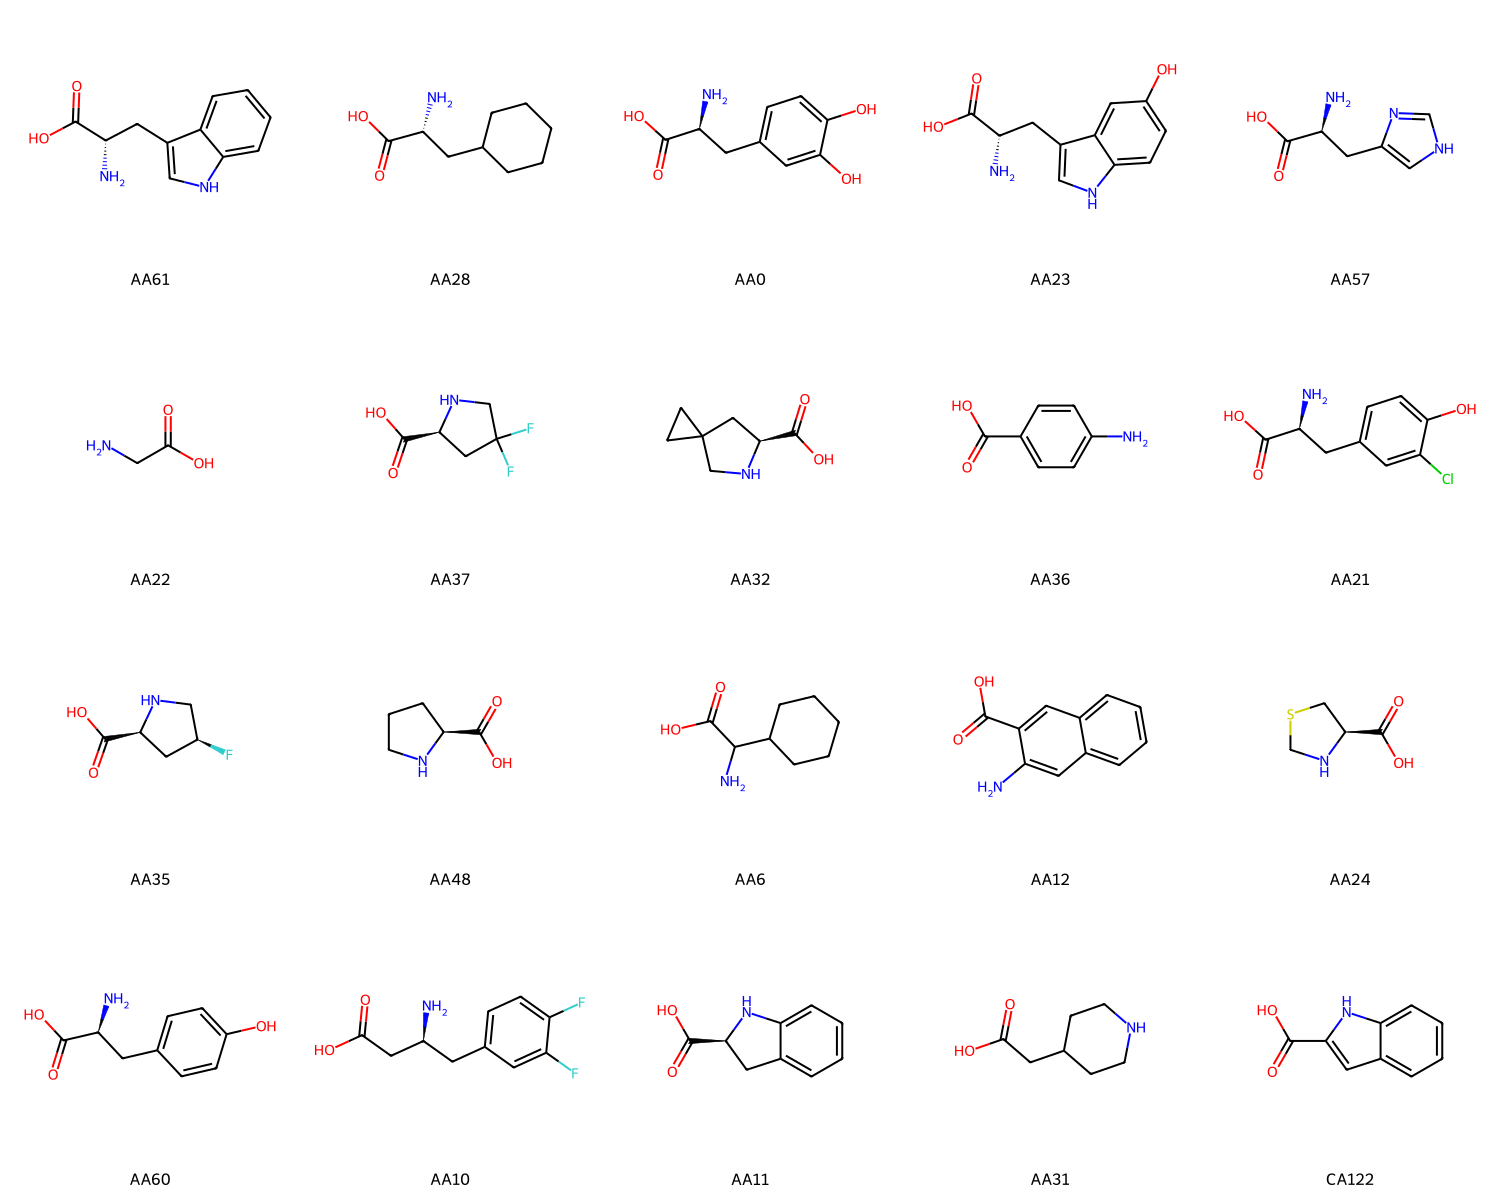

In [20]:
# Visualize the molecules in a grid (5 molecules per row)
Draw.MolsToGridImage(molecules, molsPerRow=5, subImgSize=(300, 300), legends=labels)

### Now look at the top 20 building blocks in each position
This will help in understanding the enrichment of building blocks in certain positions.

In [22]:
# Extract the product codes as a list
product_codes = top_products_df["Product_Code"].to_list()

# Initialize counters for each position
position_counters = []

# Iterate through the product codes
for product_code in product_codes:
    building_blocks = product_code.split("_")  # Split the product code by "_"
    # Ensure the position_counters list is large enough to handle all positions
    while len(position_counters) < len(building_blocks):
        position_counters.append(Counter())
    # Update the counters for each position
    for i, block in enumerate(building_blocks):
        position_counters[i][block] += 1

# Find the top 20 building blocks for each position
for i, counter in enumerate(position_counters):
    print(f"Top 20 building blocks for position {i + 1}:")
    print(f"{'Building Block':<20}{'Frequency':<10}")
    print("-" * 30)
    for block, count in counter.most_common(20):
        print(f"{block:<20}{count:<10}")
    print("\n")

Top 20 building blocks for position 1:
Building Block      Frequency 
------------------------------
CA128               9         
CA95                8         
CA26                8         
CA55                8         
CA72                7         
CA15                7         
CA117               6         
CA74                6         
CA122               6         
CA11                6         
CA69                5         
CA0                 5         
CA29                5         
CA65                5         
CA125               5         
CA30                4         
CA96                4         
CA64                4         
CA111               4         
CA92                4         


Top 20 building blocks for position 2:
Building Block      Frequency 
------------------------------
AA28                49        
AA22                23        
AA32                20        
AA57                17        
AA23                11        
AA37                1

In [23]:
# Collect the top 20 building blocks for each position
top_20_building_blocks_per_position = []
for counter in position_counters:
    top_20_blocks = [block for block, _ in counter.most_common(20)]
    top_20_building_blocks_per_position.append(top_20_blocks)

# Convert the list to a tuple
top_20_building_blocks_tuple = tuple(top_20_building_blocks_per_position)

Top 20 Building Blocks for Position 1


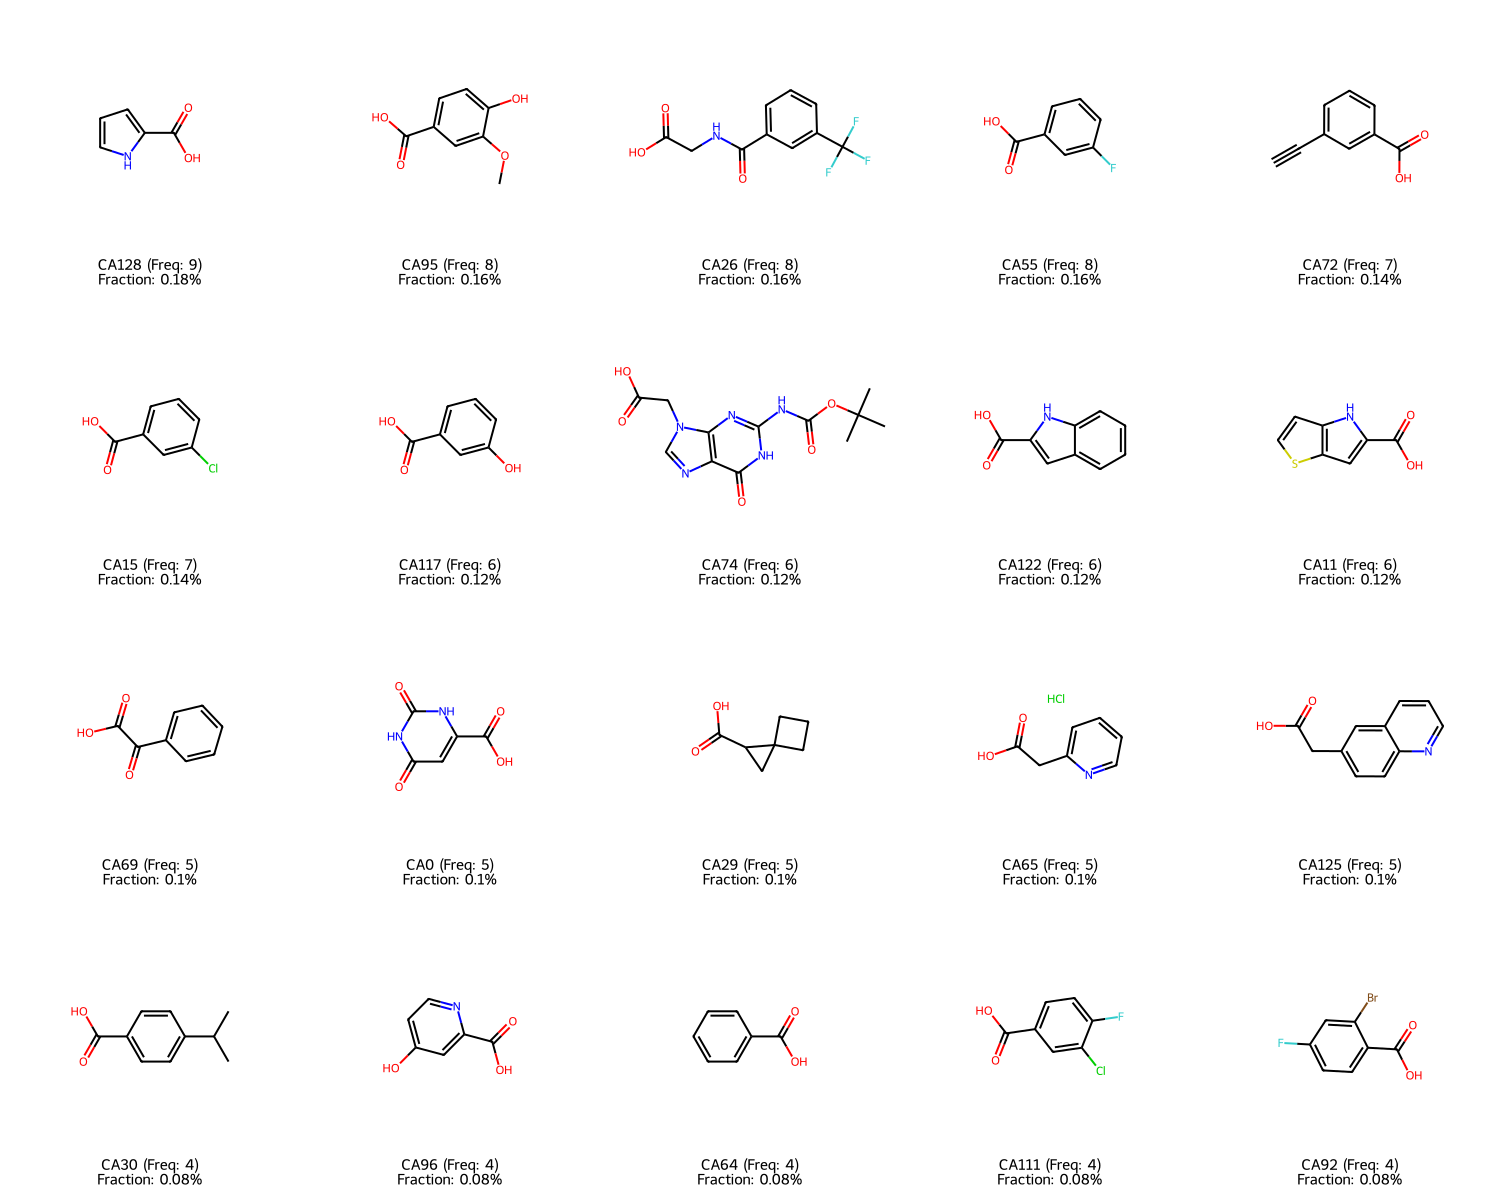

Top 20 Building Blocks for Position 2


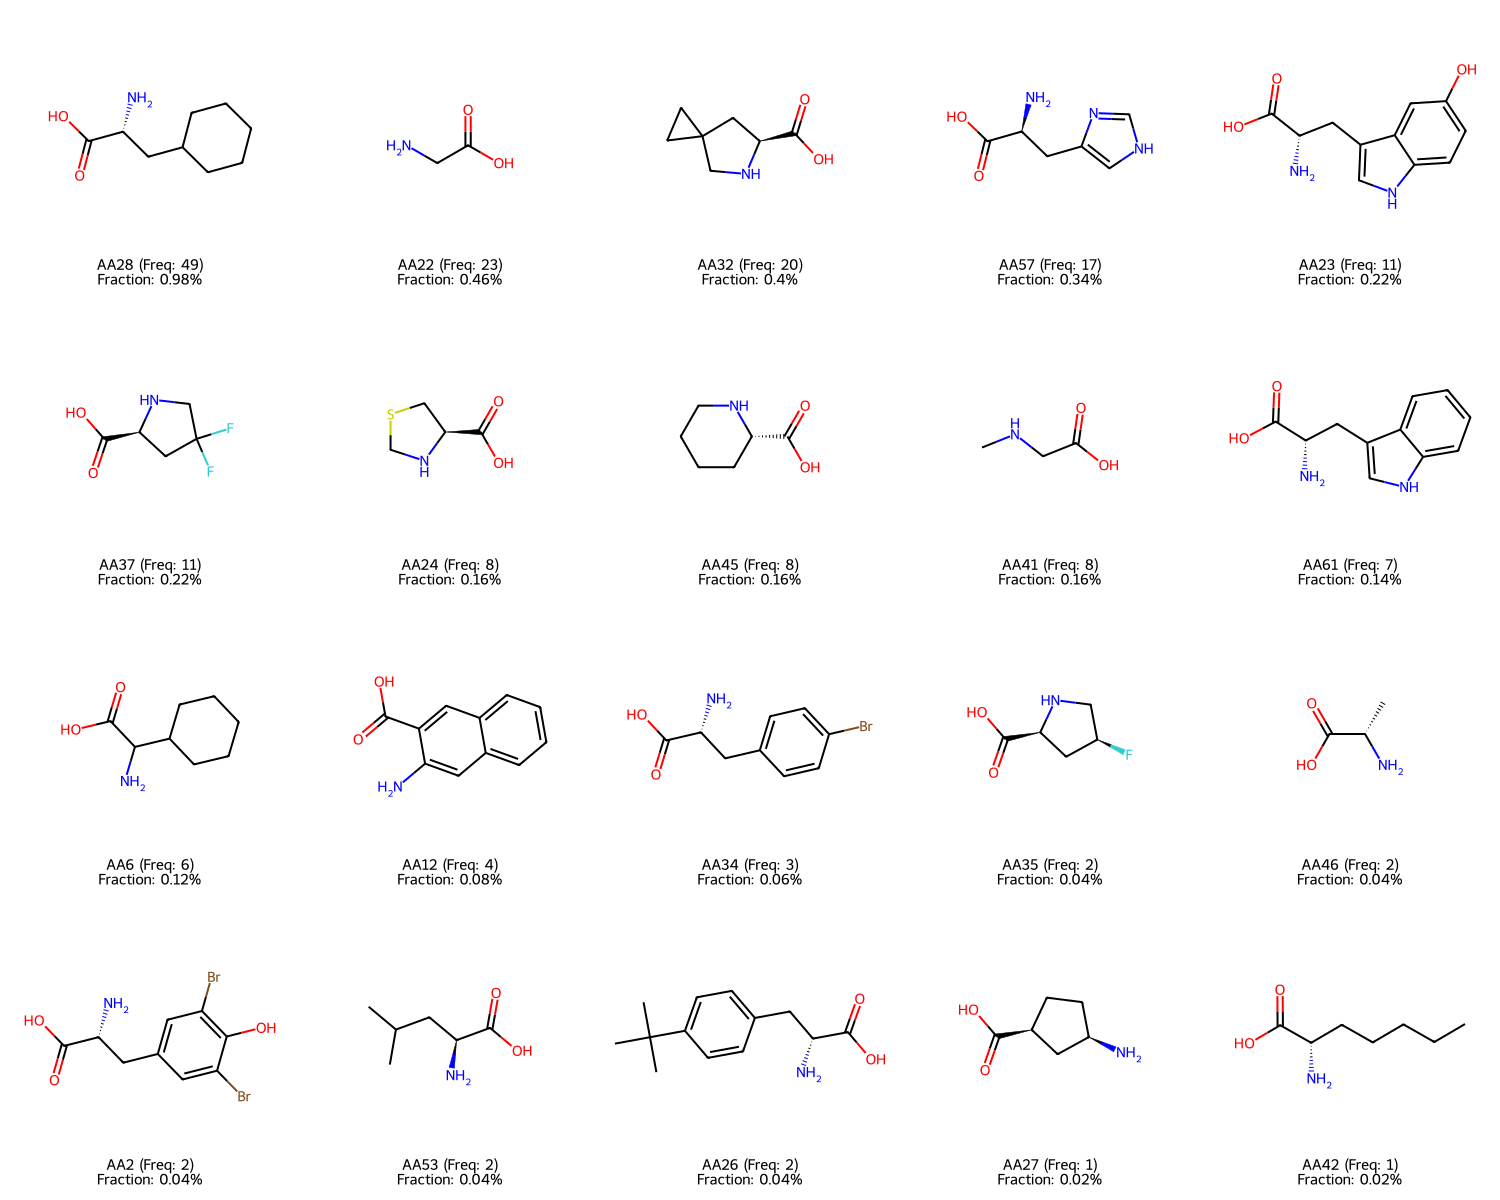

Top 20 Building Blocks for Position 3


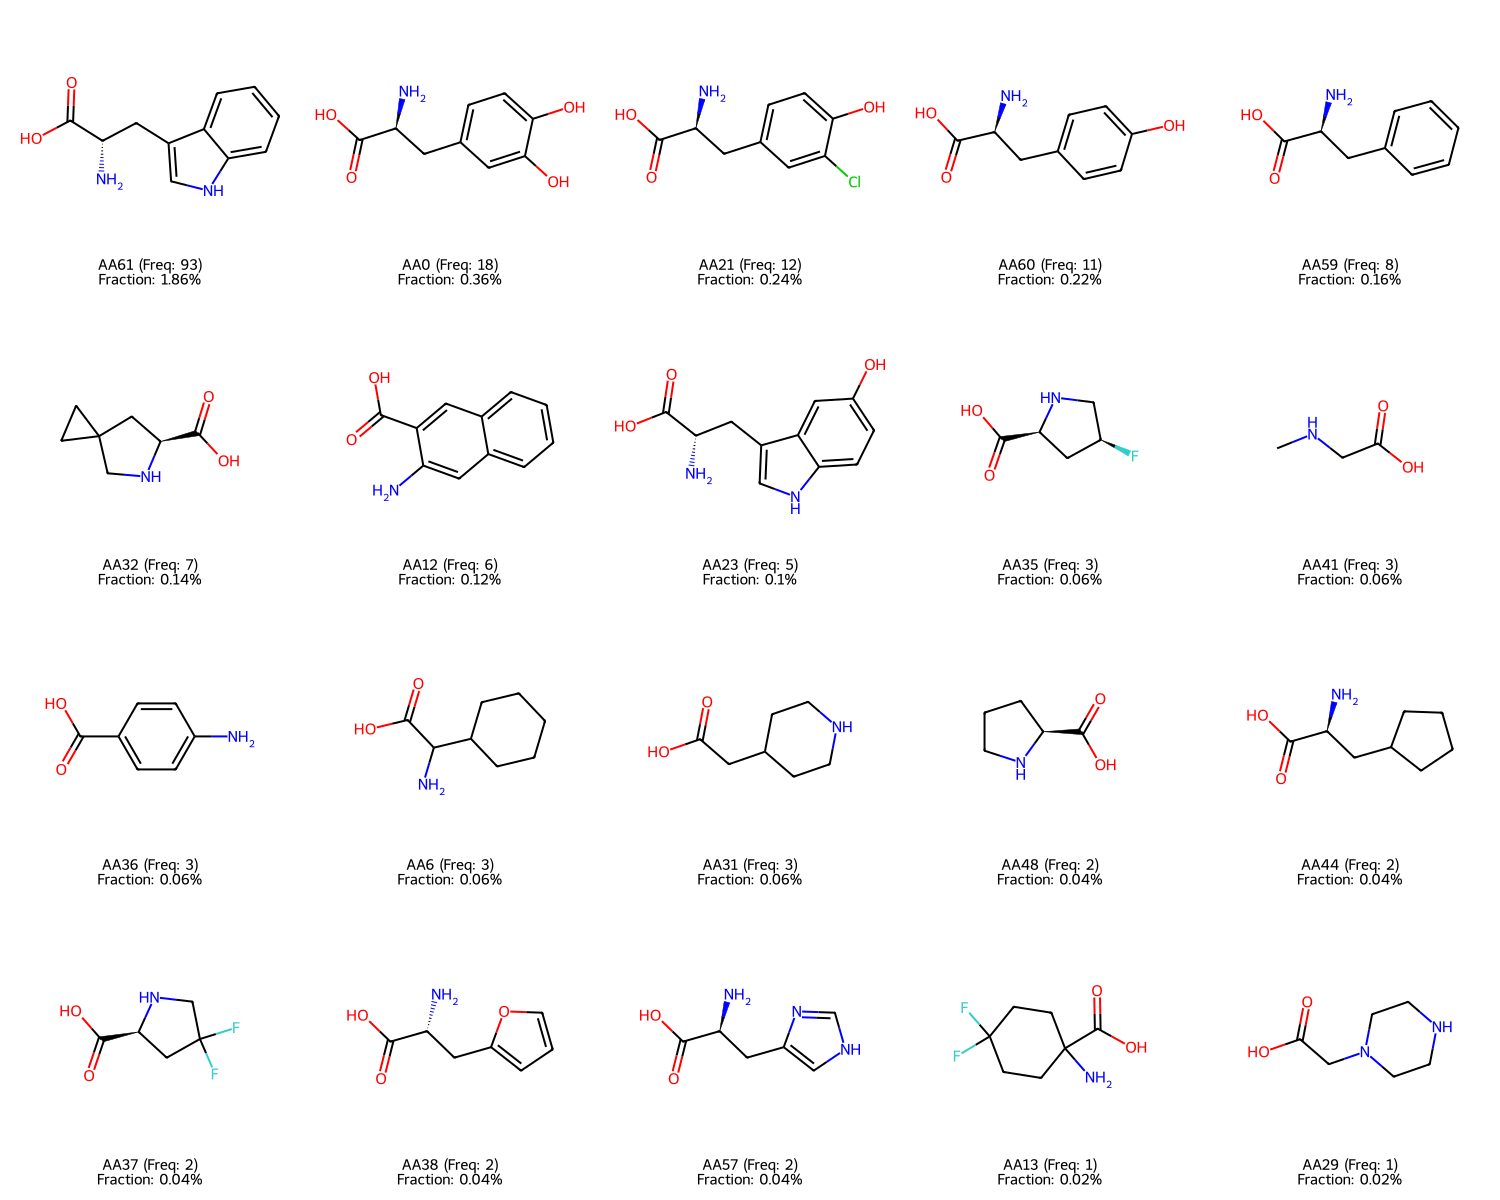

In [24]:
# Combine the two dictionaries
combined_smiles_dict = {**amino_acid_bb_dict, **acids_bb_dict}

# Iterate through each position's top 20 building blocks
for i, counter in enumerate(position_counters):
    # Get the top 20 building blocks for the current position
    top_20_blocks = counter.most_common(20)
    
    # Create a list of RDKit molecules and their labels
    mols = []
    legends = []
    for block, freq in top_20_blocks:
        if block in combined_smiles_dict:  # Use the combined dictionary
            smiles = combined_smiles_dict[block]
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mols.append(mol)
                # Add building block name and frequency on the first line, fraction on the second line
                legends.append(f"{block} (Freq: {freq})\nFraction: {round((freq / total_molecules) * 100, 2)}%")
    
    # Visualize the molecules in a grid
    img = Draw.MolsToGridImage(
        mols, legends=legends, molsPerRow=5, subImgSize=(300, 300)
    )
    
    # Display the title and the image
    print(f"Top 20 Building Blocks for Position {i + 1}")
    display(img)  # Display the image in the Jupyter Notebook

In [7]:
def get_top_building_blocks(top_products_df, top_n, Maximize=False):
    """
    Extract the top 20 building blocks for each position from the top N products.
    
    :param Maximize: Sort the building blocks in descending order. If larger values are better scores.
    :param top_products_df: Polars DataFrame containing product codes.
    :param top_n: Number of top products to consider.
    :return: A tuple of lists containing the top 20 building blocks for each position.
    """
    # Get the top N products
    if isinstance(top_products_df, pd.DataFrame):
        top_products_df = top_products_df.sort_values(by="Scores", ascending=Maximize)
    elif isinstance(top_products_df, pl.DataFrame):
        top_products_df = top_products_df.sort("Scores", descending=Maximize)
    else:
        raise TypeError("Input must be either a pandas DataFrame or a polars DataFrame")

    top_n_df = top_products_df.head(top_n)
    
    # Extract the product codes as a list
    product_codes = top_n_df["Product_Code"].to_list()

    # Initialize counters for each position
    position_counters = []

    # Iterate through the product codes
    for product_code in product_codes:
        building_blocks = product_code.split("_")  # Split the product code by "_"
        # Ensure the position_counters list is large enough to handle all positions
        while len(position_counters) < len(building_blocks):
            position_counters.append(Counter())
        # Update the counters for each position
        for i, block in enumerate(building_blocks):
            position_counters[i][block] += 1

    # Collect the top 20 building blocks for each position
    top_20_building_blocks = []
    for counter in position_counters:
        top_20_building_blocks.append([block for block, _ in counter.most_common(20)])
    
    return tuple(top_20_building_blocks)

In [8]:
# Function to check overlap for each position and print the total overlap
def check_overlap(top_20_smaller, top_20_5000):
    overlap_results = []
    total_overlap = 0  # To track the total number of overlapping compounds across all positions

    for position, smaller_list in enumerate(top_20_smaller):
        # Get the corresponding list from the top 5000
        larger_list = top_20_5000[position]
        # Find the intersection
        overlap = set(smaller_list).intersection(set(larger_list))
        overlap_results.append((position + 1, len(overlap), overlap))  # Position is 1-based
        total_overlap += len(overlap)  # Add the count of overlaps for this position

        # Print the overlap for the current position
        print(f"Position {position + 1}: {len(overlap)} building blocks overlap")

    # Print the total overlap
    print(f"Total number of overlapping compounds across all positions: {total_overlap}")
    return overlap_results

In [9]:
def visualize_overlapping_blocks(overlap, combined_smiles_dict):
    """
    Visualize the overlapping building blocks for each position.
    
    :param overlap: Overlap data for a specific cutoff (list of tuples with position, count, and blocks).
    :param combined_smiles_dict: Dictionary mapping building block codes to SMILES strings.
    """
    for position, count, blocks in overlap:
        mols = []
        legends = []
        for block in blocks:
            if block in combined_smiles_dict:
                smiles = combined_smiles_dict[block]
                mol = Chem.MolFromSmiles(smiles)
                if mol:
                    mols.append(mol)
                    # Add only the building block name to the legend
                    legends.append(f"{block}")
        
        # Visualize the molecules in a grid
        img = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=5, subImgSize=(300, 300))
        
        # Display the title and the image
        print(f"Overlapping Building Blocks for Position {position}")
        display(img)

In [10]:
# Example usage
top_200_building_blocks = get_top_building_blocks(prod_scores_df, 200)
top_400_building_blocks = get_top_building_blocks(prod_scores_df, 400)
top_800_building_blocks = get_top_building_blocks(prod_scores_df, 800)
top_1000_building_blocks = get_top_building_blocks(prod_scores_df, 1000)
top_5000_building_blocks = get_top_building_blocks(prod_scores_df, 5000)

# Print results for top 200 as an example
for i, blocks in enumerate(top_200_building_blocks):
    print(f"Top 20 building blocks for position {i + 1} (Top 200 products):")
    print(blocks)
    print("\n")

Top 20 building blocks for position 1 (Top 200 products):
['CA128', 'CA95', 'CA26', 'CA55', 'CA72', 'CA15', 'CA117', 'CA74', 'CA122', 'CA11', 'CA69', 'CA0', 'CA29', 'CA65', 'CA125', 'CA30', 'CA96', 'CA64', 'CA111', 'CA92']


Top 20 building blocks for position 2 (Top 200 products):
['AA28', 'AA22', 'AA32', 'AA57', 'AA23', 'AA37', 'AA24', 'AA45', 'AA41', 'AA61', 'AA6', 'AA12', 'AA34', 'AA35', 'AA46', 'AA2', 'AA53', 'AA26', 'AA27', 'AA42']


Top 20 building blocks for position 3 (Top 200 products):
['AA61', 'AA0', 'AA21', 'AA60', 'AA59', 'AA32', 'AA12', 'AA23', 'AA35', 'AA41', 'AA36', 'AA6', 'AA31', 'AA48', 'AA44', 'AA37', 'AA38', 'AA57', 'AA13', 'AA29']




In [60]:
# Check overlaps for each cutoff
overlap_200 = check_overlap(top_200_building_blocks, top_5000_building_blocks)
overlap_400 = check_overlap(top_400_building_blocks, top_5000_building_blocks)
overlap_800 = check_overlap(top_800_building_blocks, top_5000_building_blocks)
overlap_1000 = check_overlap(top_1000_building_blocks, top_5000_building_blocks)

# Print results
for cutoff, overlap in zip([200, 400, 800, 1000], [overlap_200, overlap_400, overlap_800, overlap_1000]):
    print(f"Comparing enriched building blocks from the top {cutoff} compounds with the top 5000 compounds:")
    for position, count, blocks in overlap:
        print(f"  Position {position}: {count} building blocks overlap")
        print(f"    Overlapping building blocks: {', '.join(blocks)}")
    print("\n")

Position 1: 16 building blocks overlap
Position 2: 14 building blocks overlap
Position 3: 14 building blocks overlap
Total number of overlapping compounds across all positions: 44
Position 1: 17 building blocks overlap
Position 2: 18 building blocks overlap
Position 3: 16 building blocks overlap
Total number of overlapping compounds across all positions: 51
Position 1: 17 building blocks overlap
Position 2: 19 building blocks overlap
Position 3: 16 building blocks overlap
Total number of overlapping compounds across all positions: 52
Position 1: 19 building blocks overlap
Position 2: 19 building blocks overlap
Position 3: 18 building blocks overlap
Total number of overlapping compounds across all positions: 56
Comparing enriched building blocks from the top 200 compounds with the top 5000 compounds:
  Position 1: 16 building blocks overlap
    Overlapping building blocks: CA64, CA96, CA125, CA11, CA65, CA15, CA128, CA117, CA72, CA111, CA122, CA55, CA69, CA26, CA95, CA74
  Position 2: 1

Visualizing overlaps for top 200 compounds:
Overlapping Building Blocks for Position 1


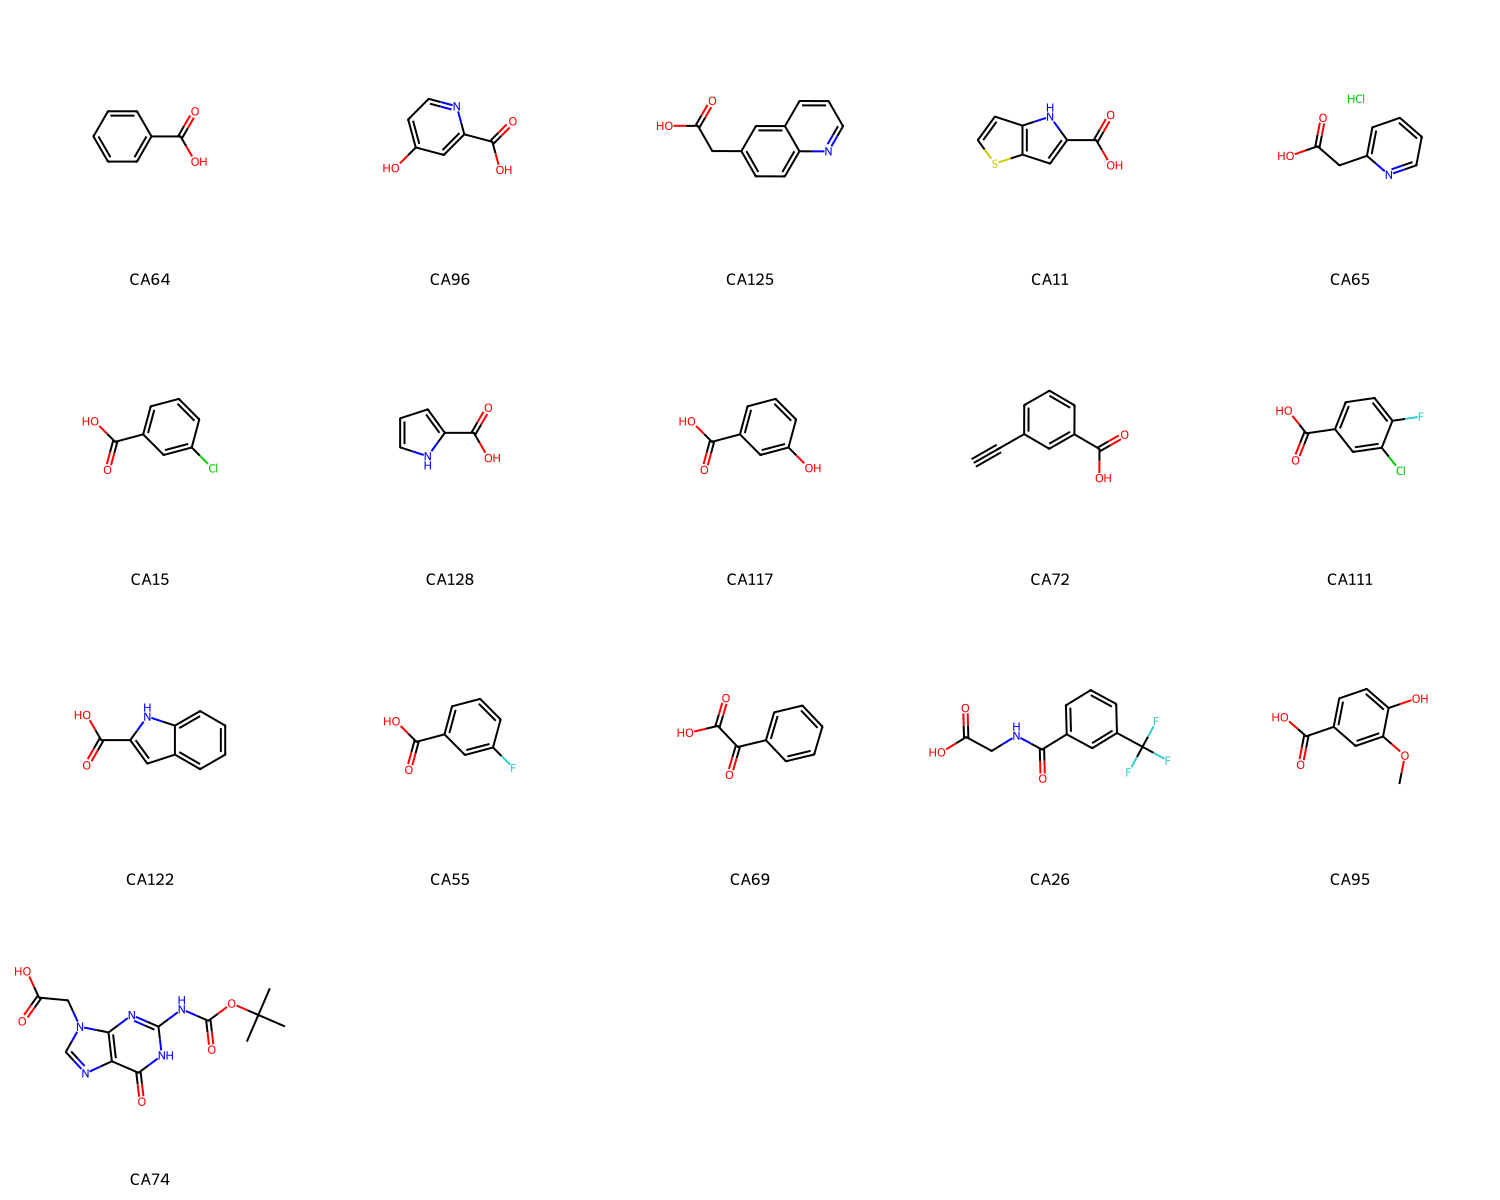

Overlapping Building Blocks for Position 2


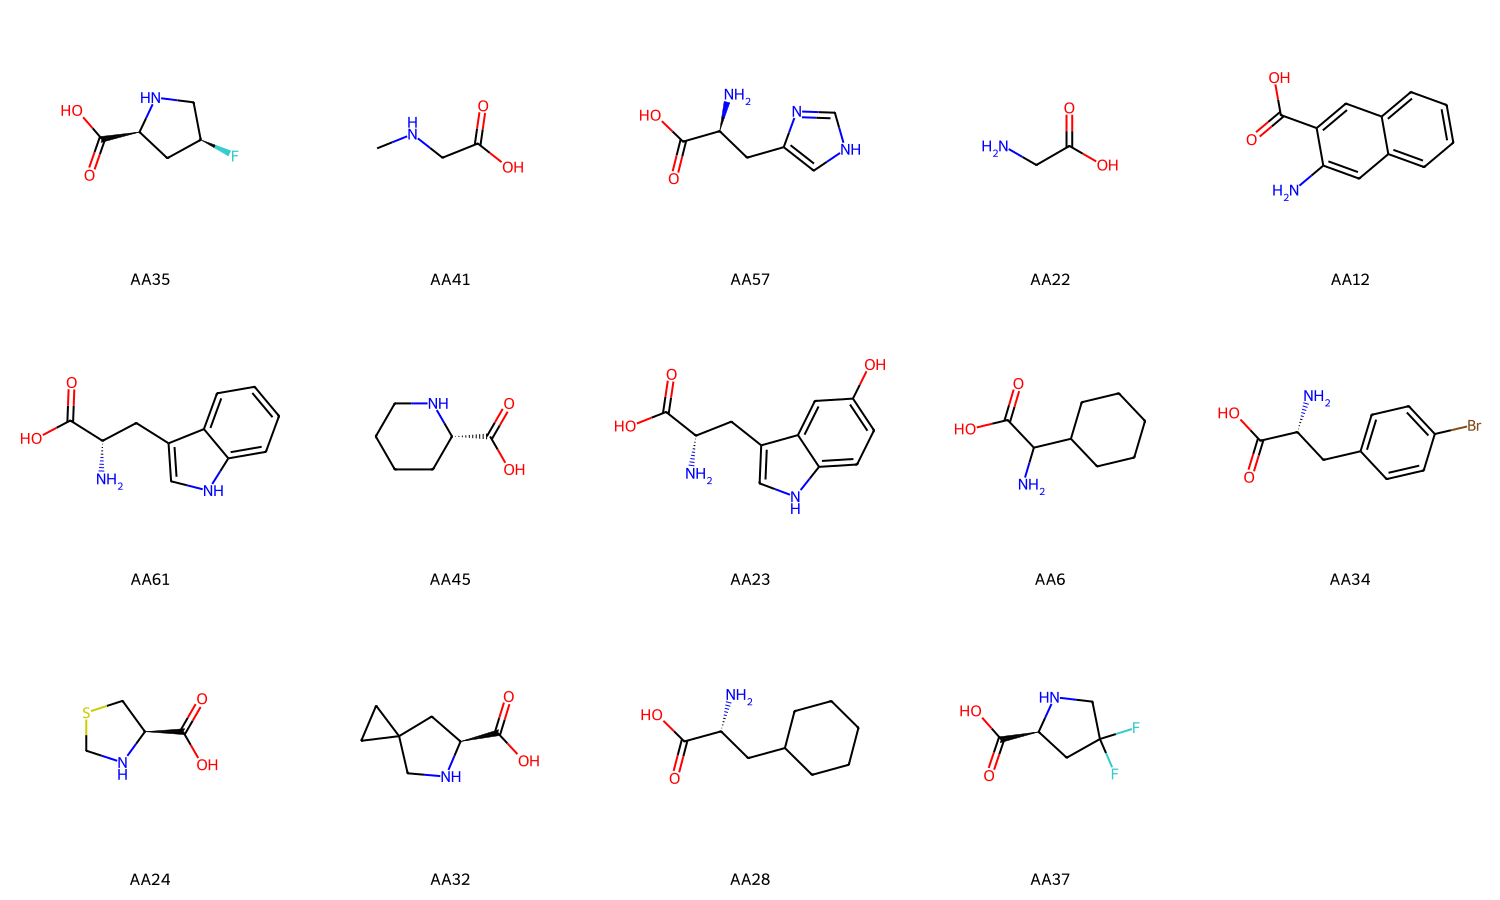

Overlapping Building Blocks for Position 3


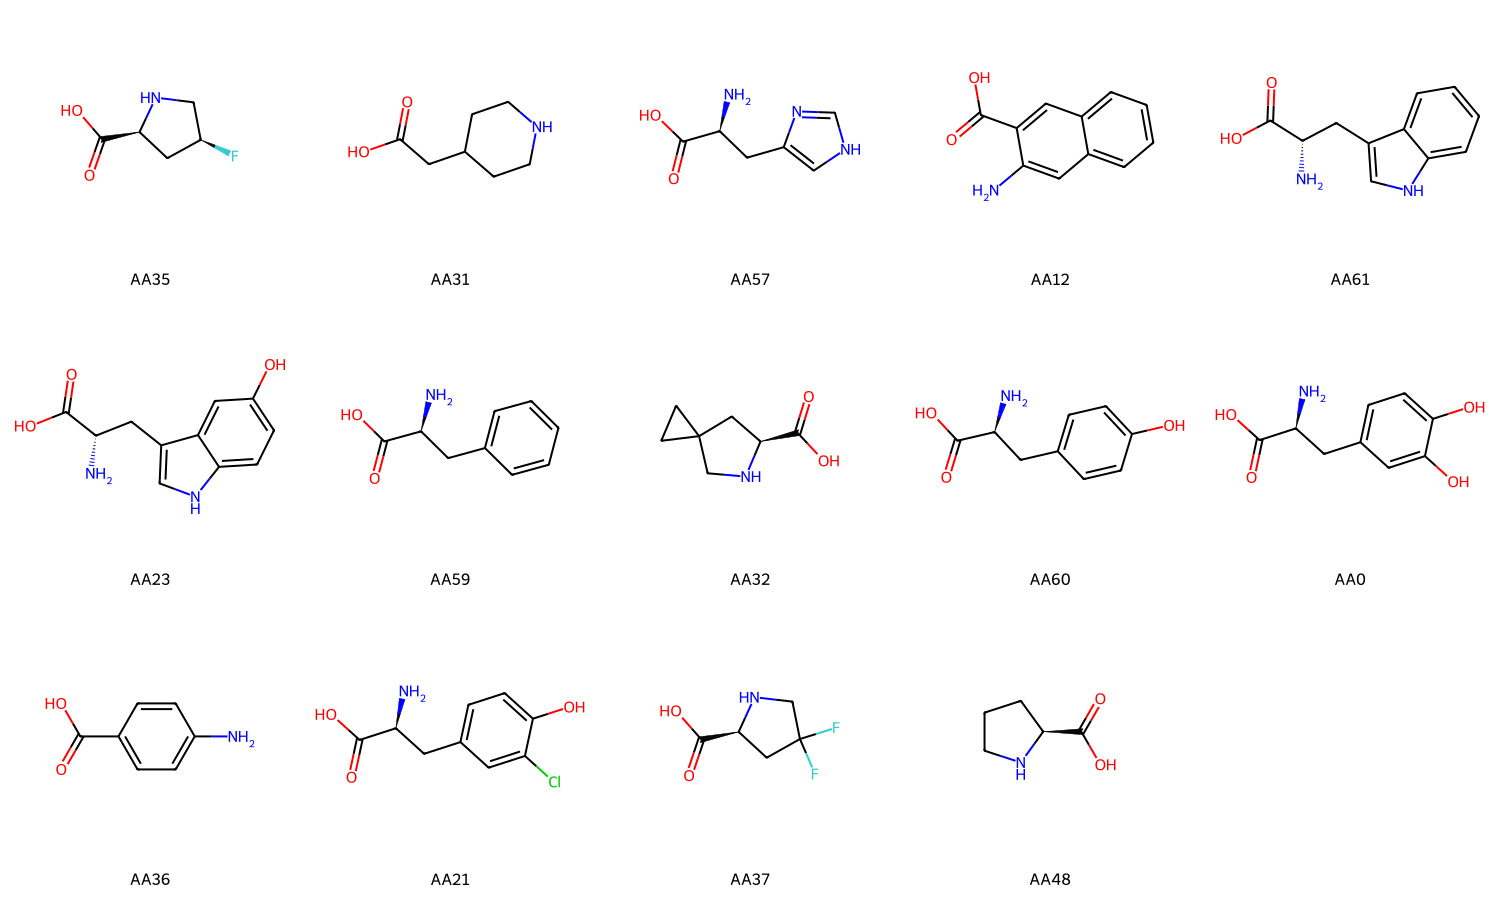

Visualizing overlaps for top 400 compounds:
Overlapping Building Blocks for Position 1


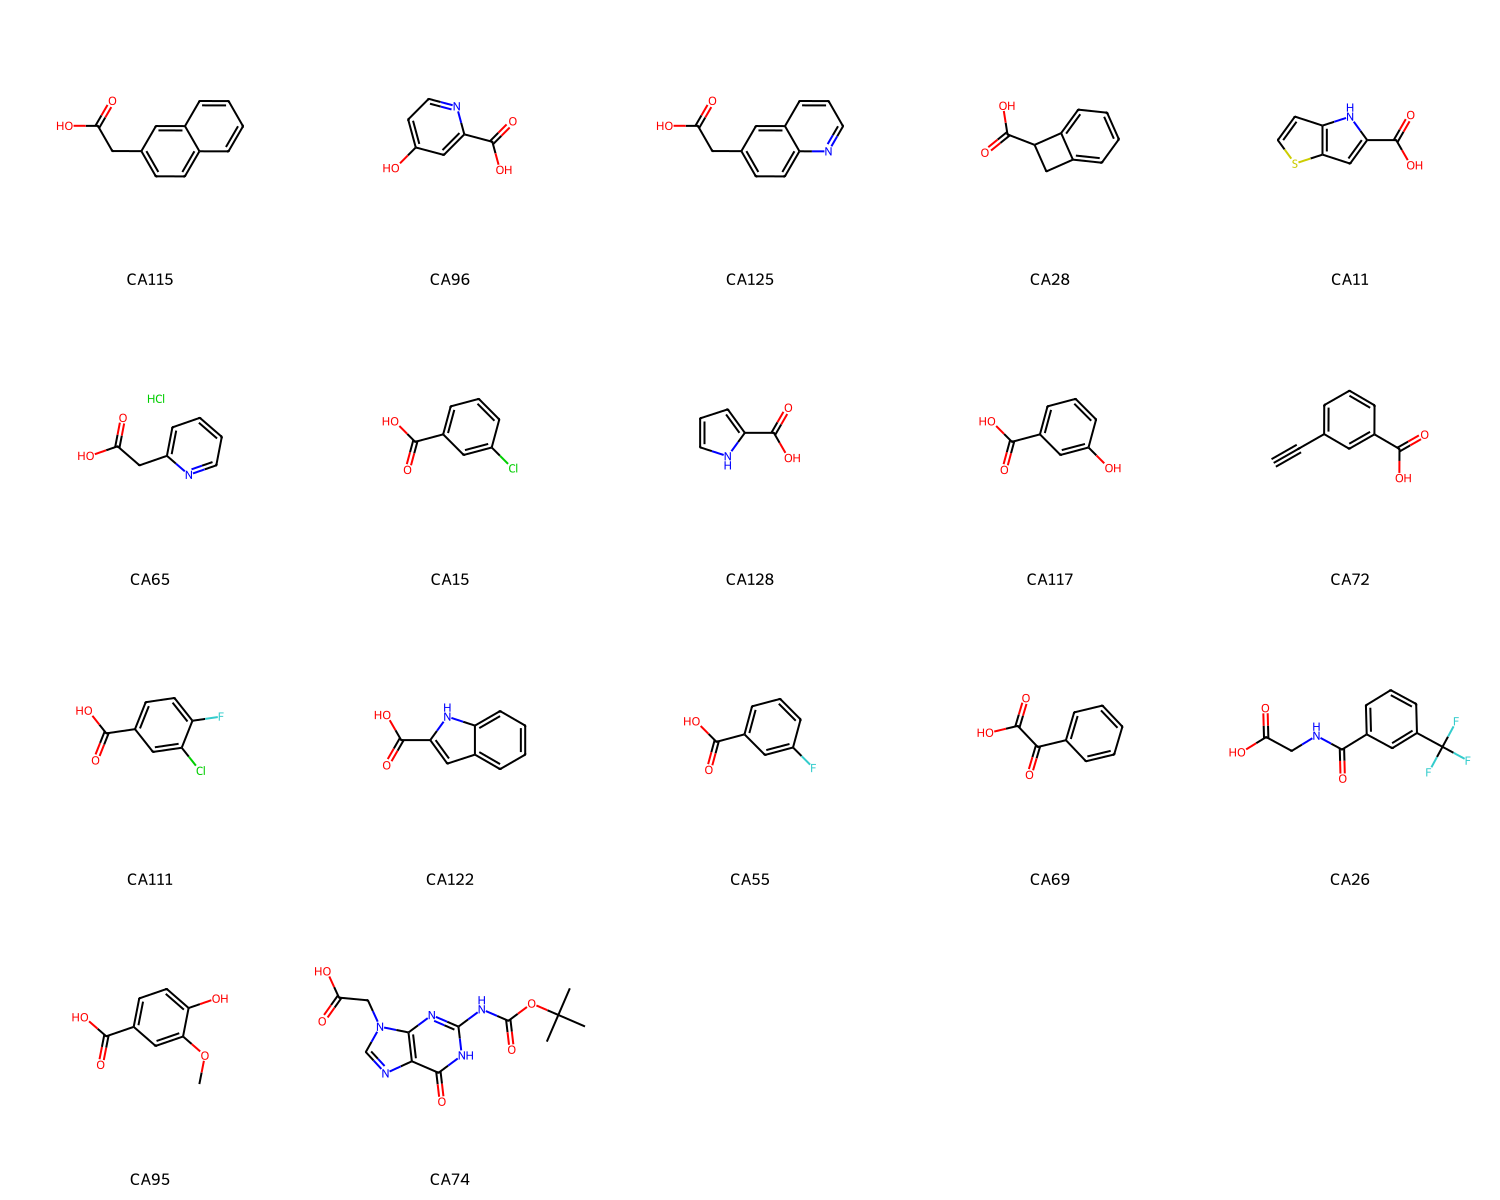

Overlapping Building Blocks for Position 2


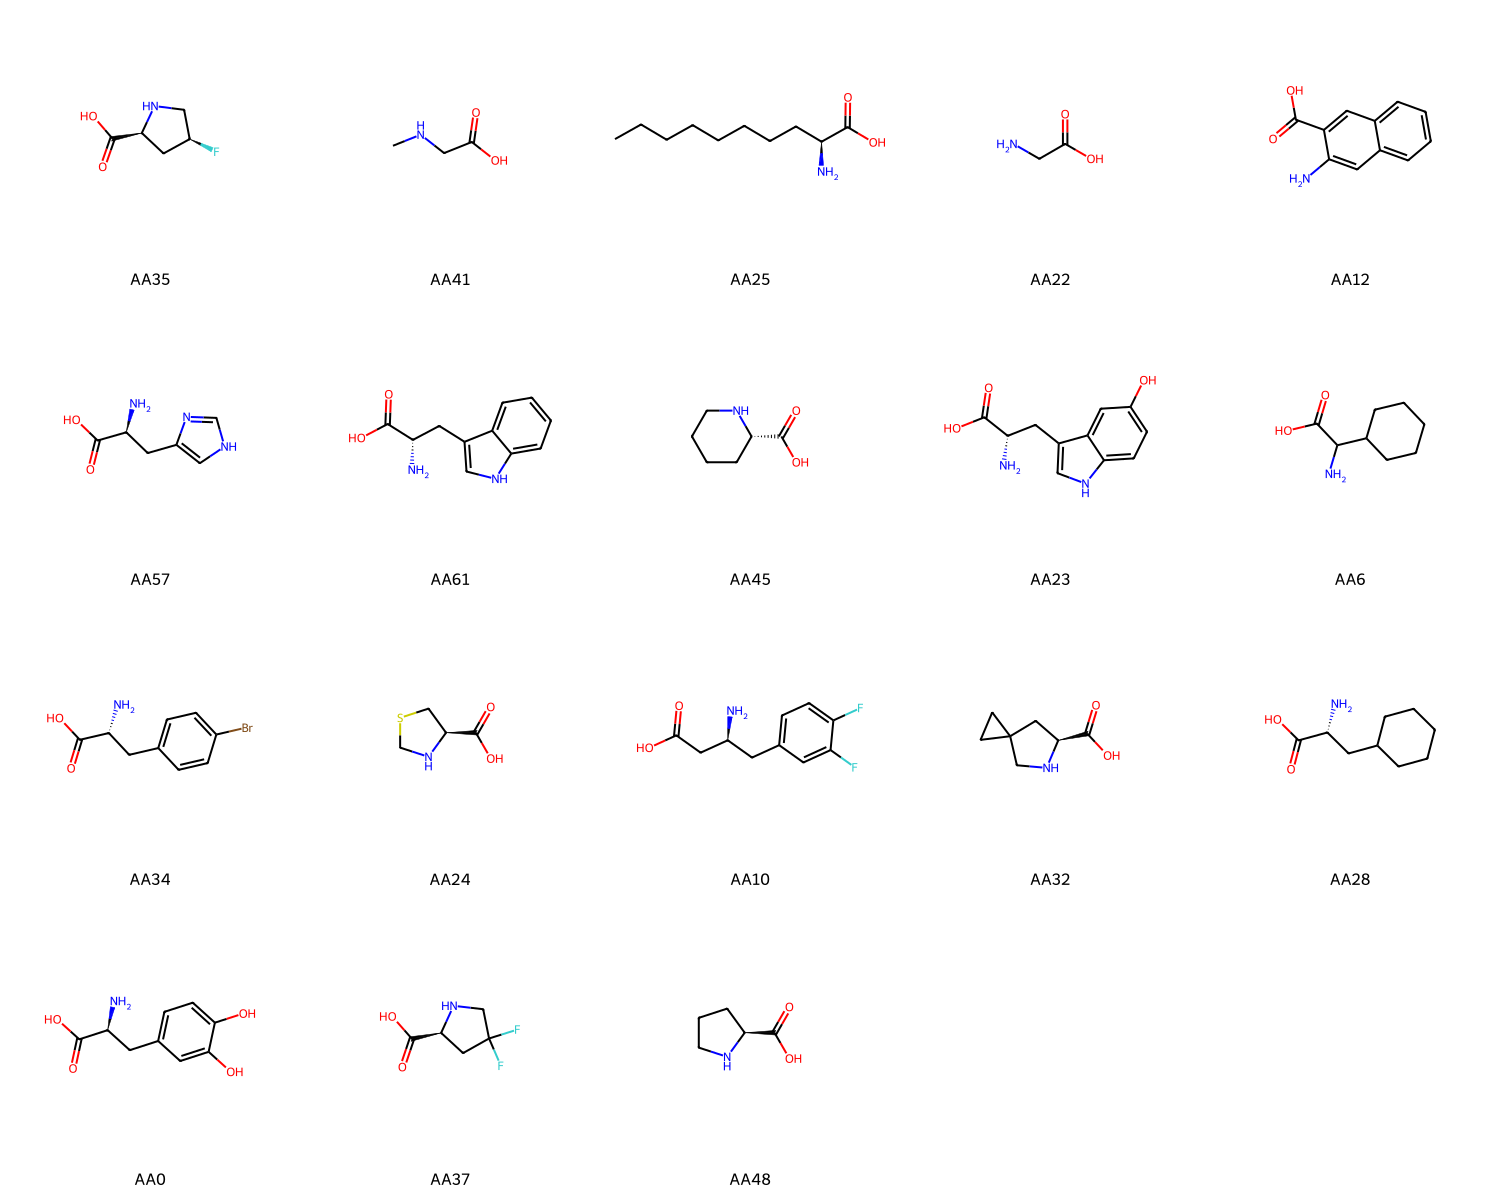

Overlapping Building Blocks for Position 3


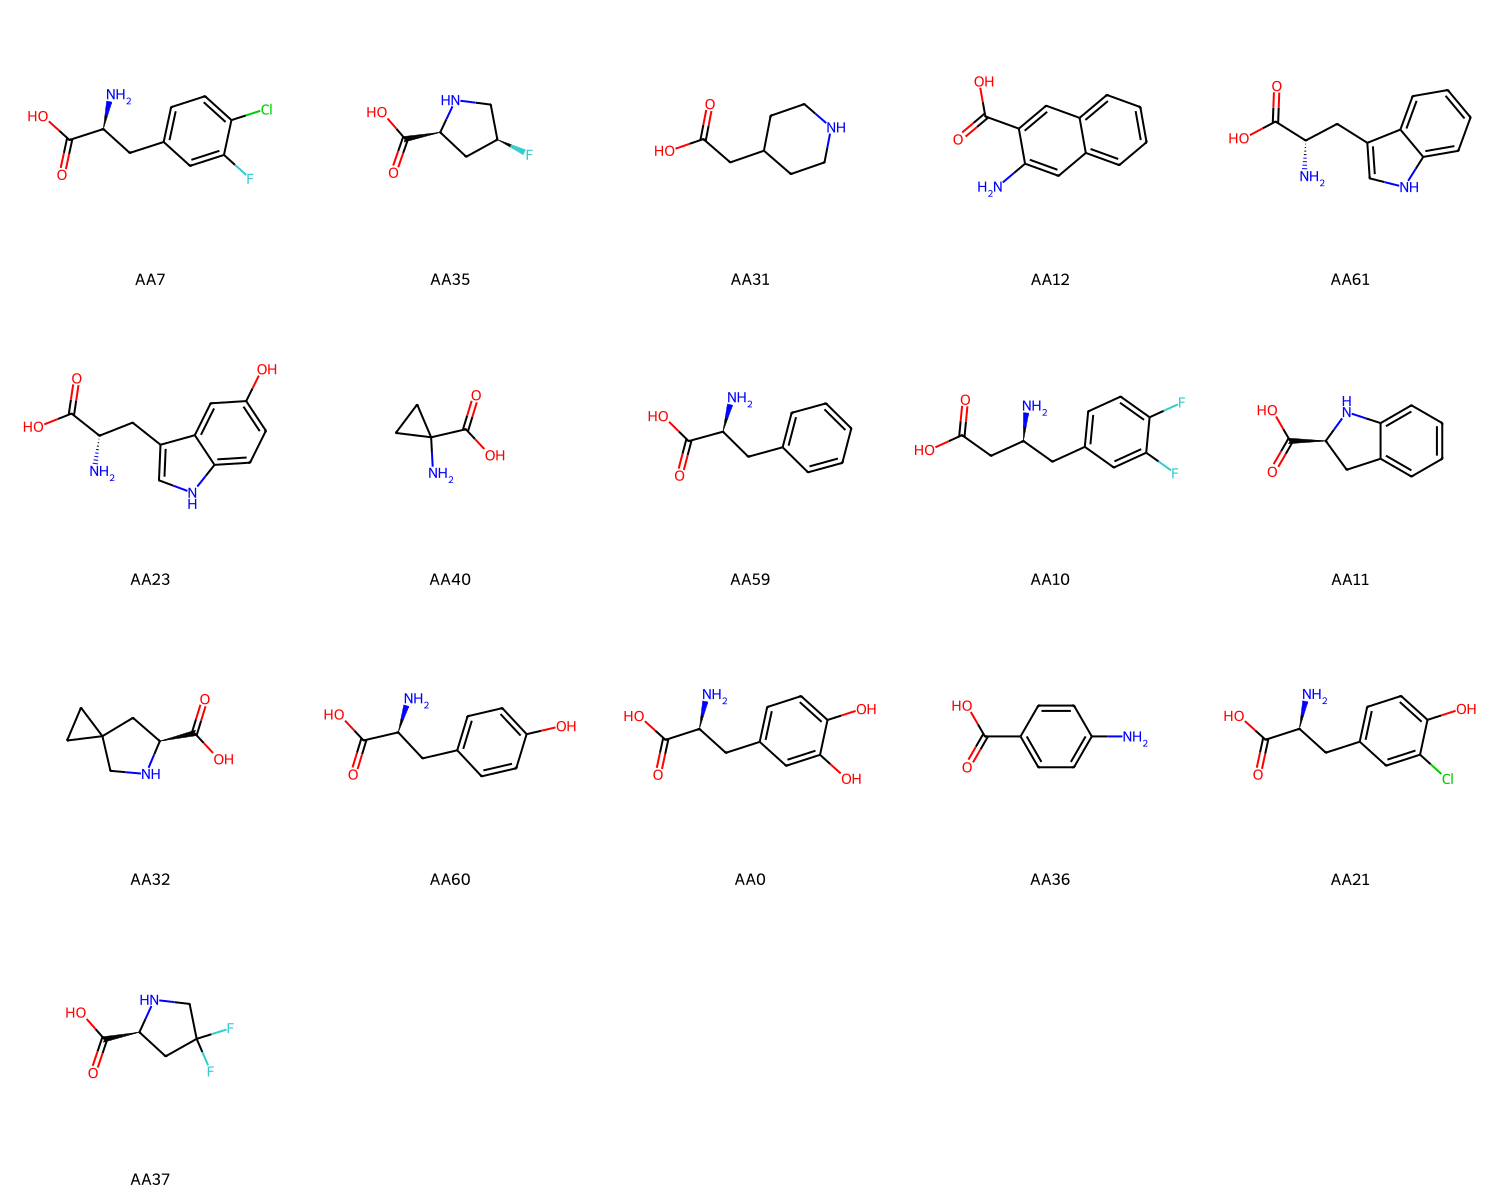

Visualizing overlaps for top 800 compounds:
Overlapping Building Blocks for Position 1


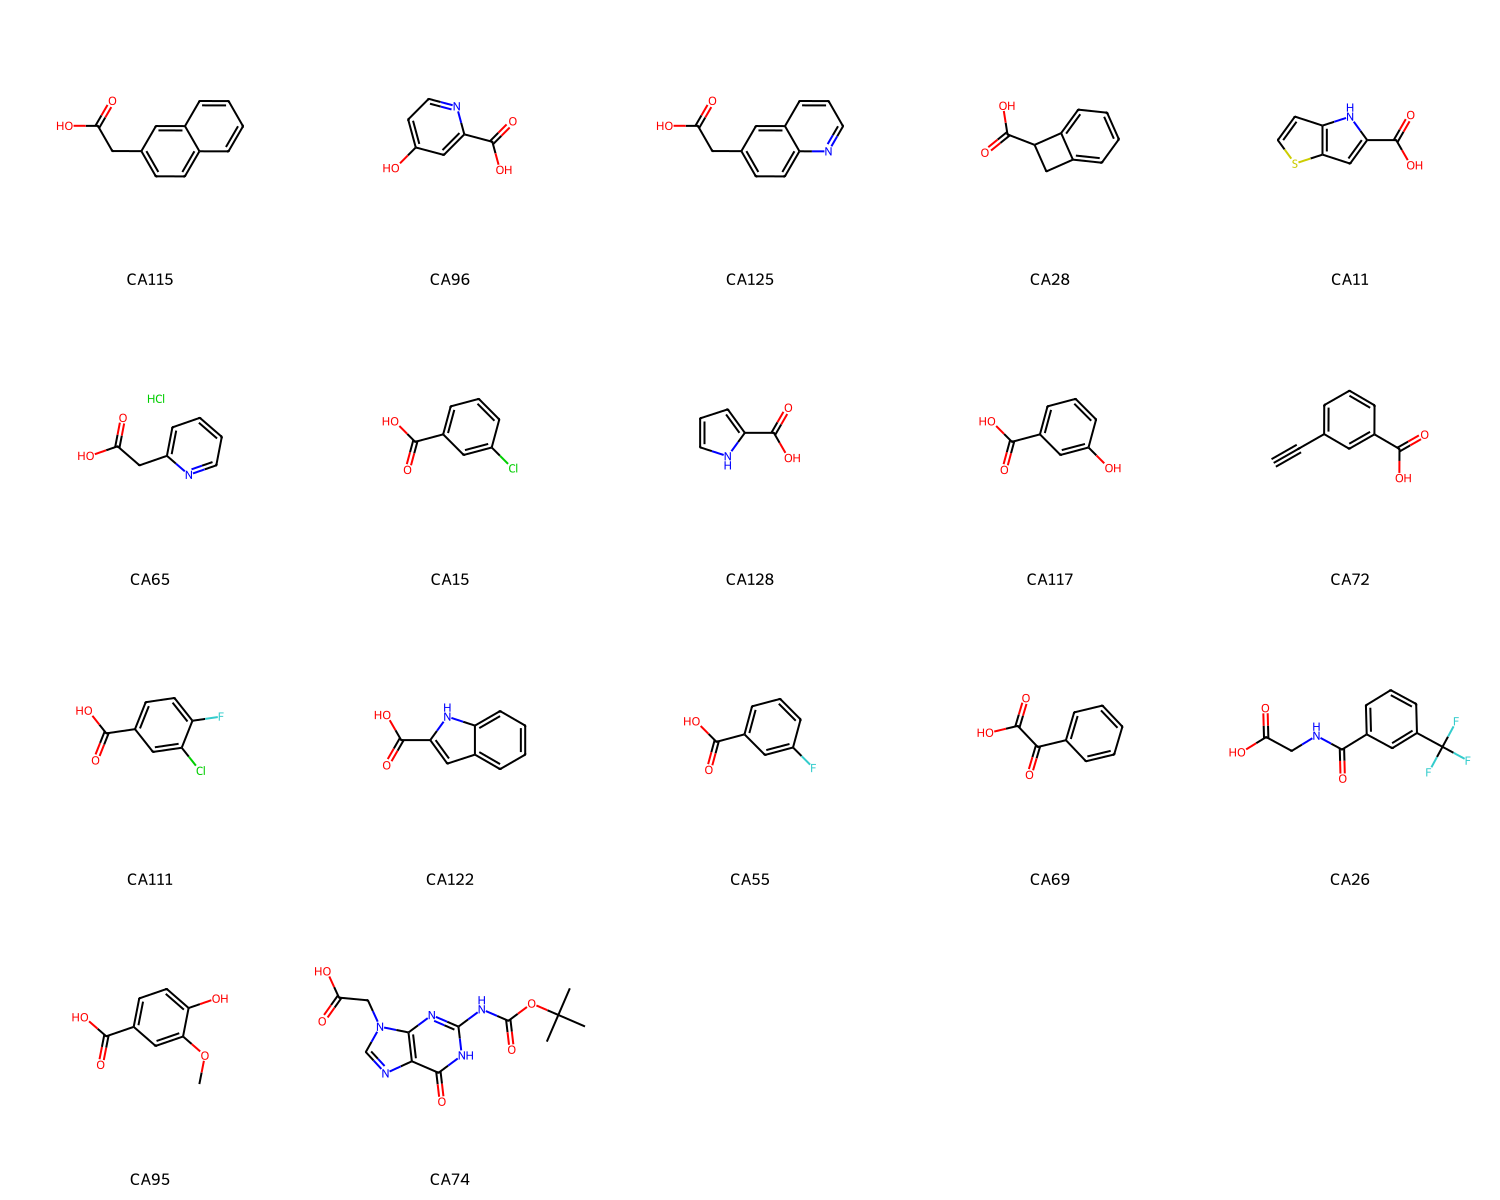

Overlapping Building Blocks for Position 2


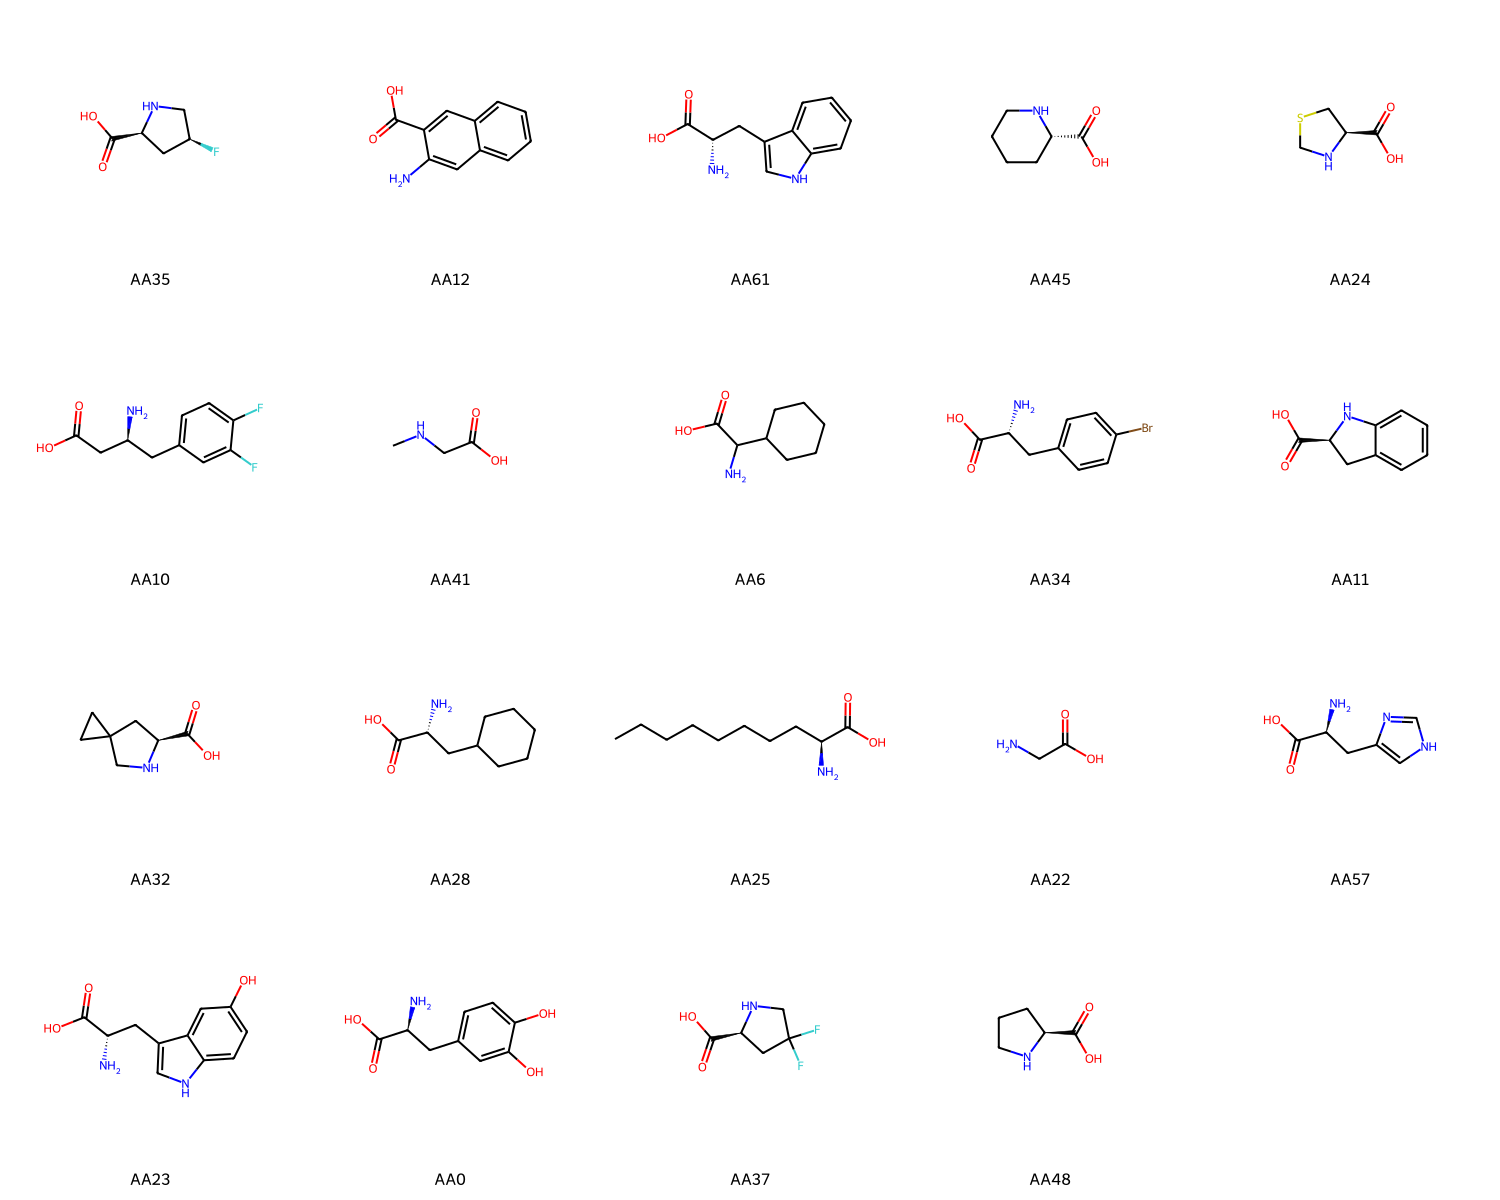

Overlapping Building Blocks for Position 3


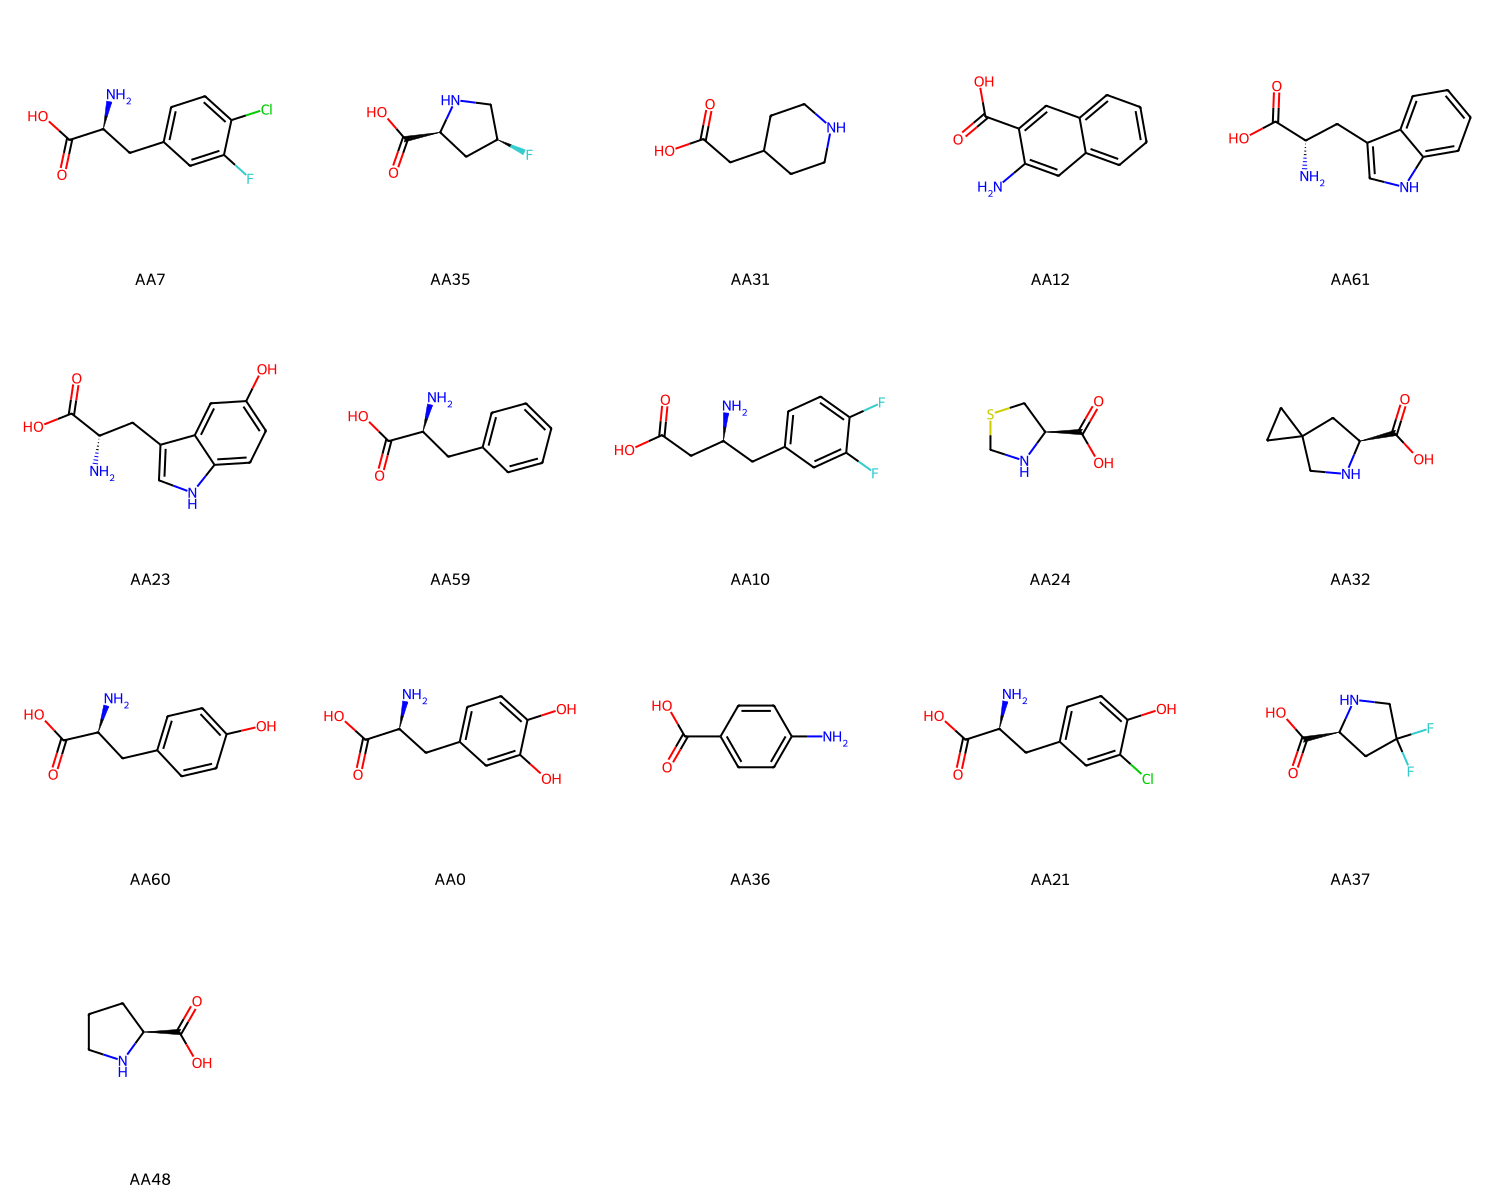

Visualizing overlaps for top 1000 compounds:
Overlapping Building Blocks for Position 1


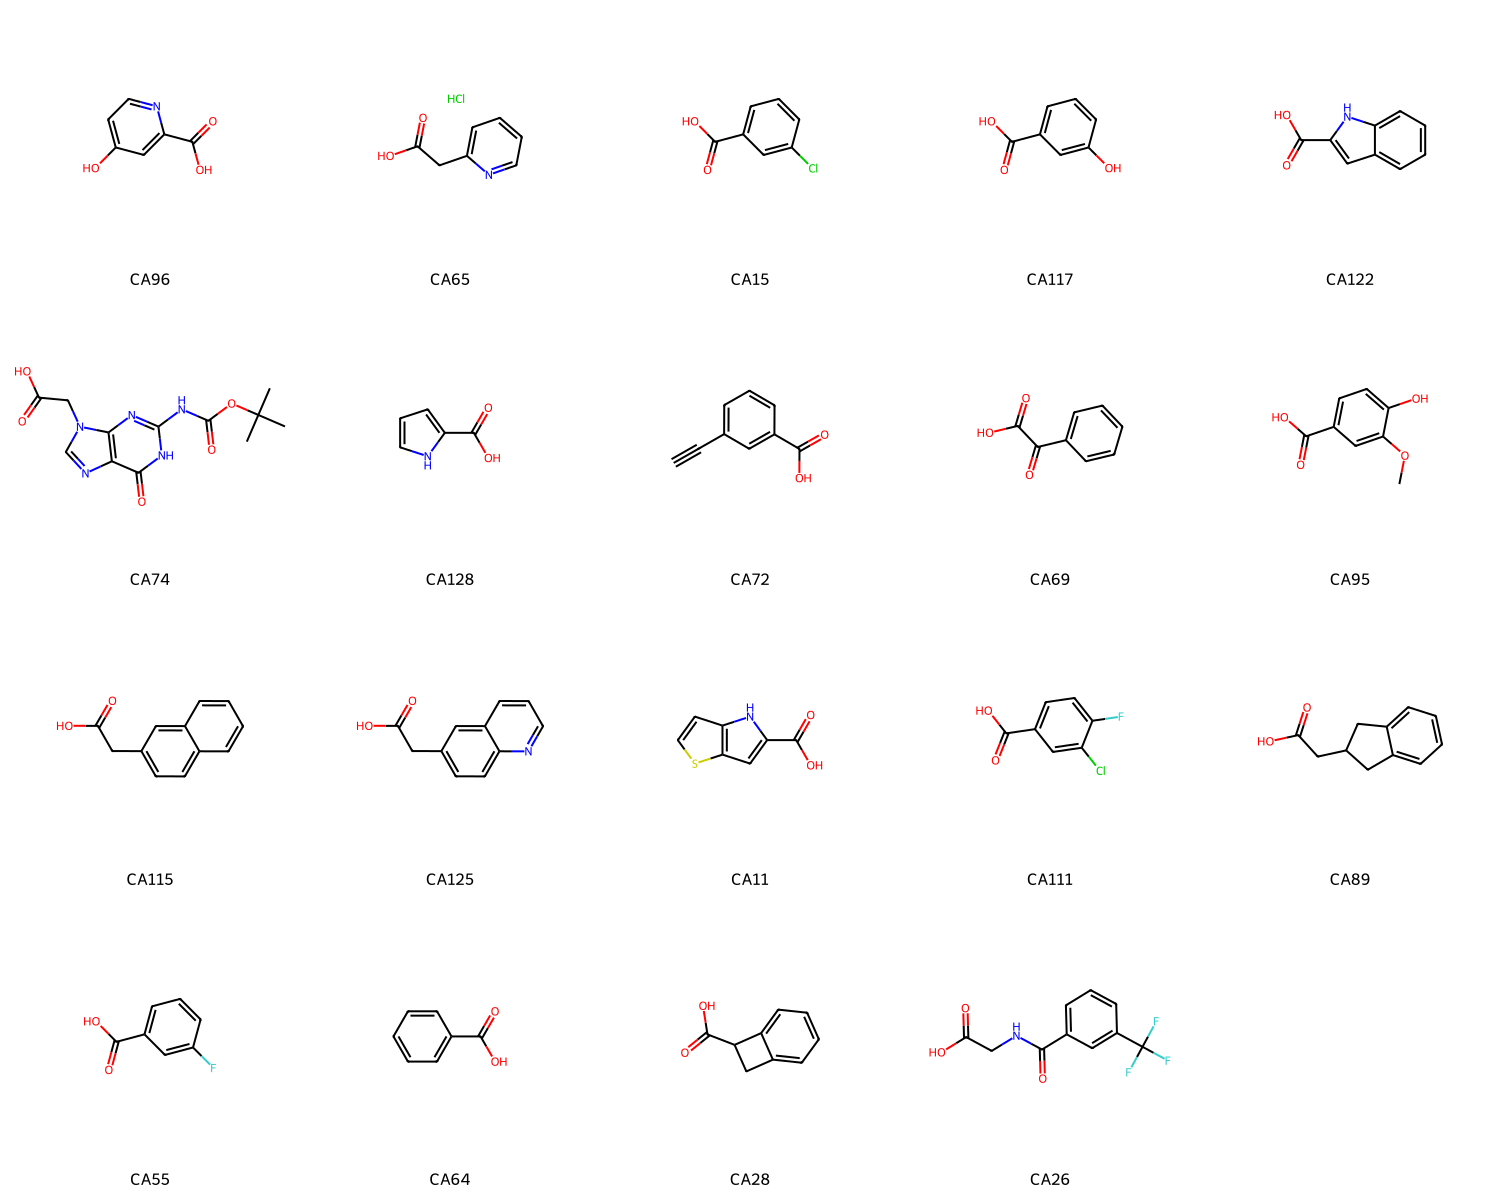

Overlapping Building Blocks for Position 2


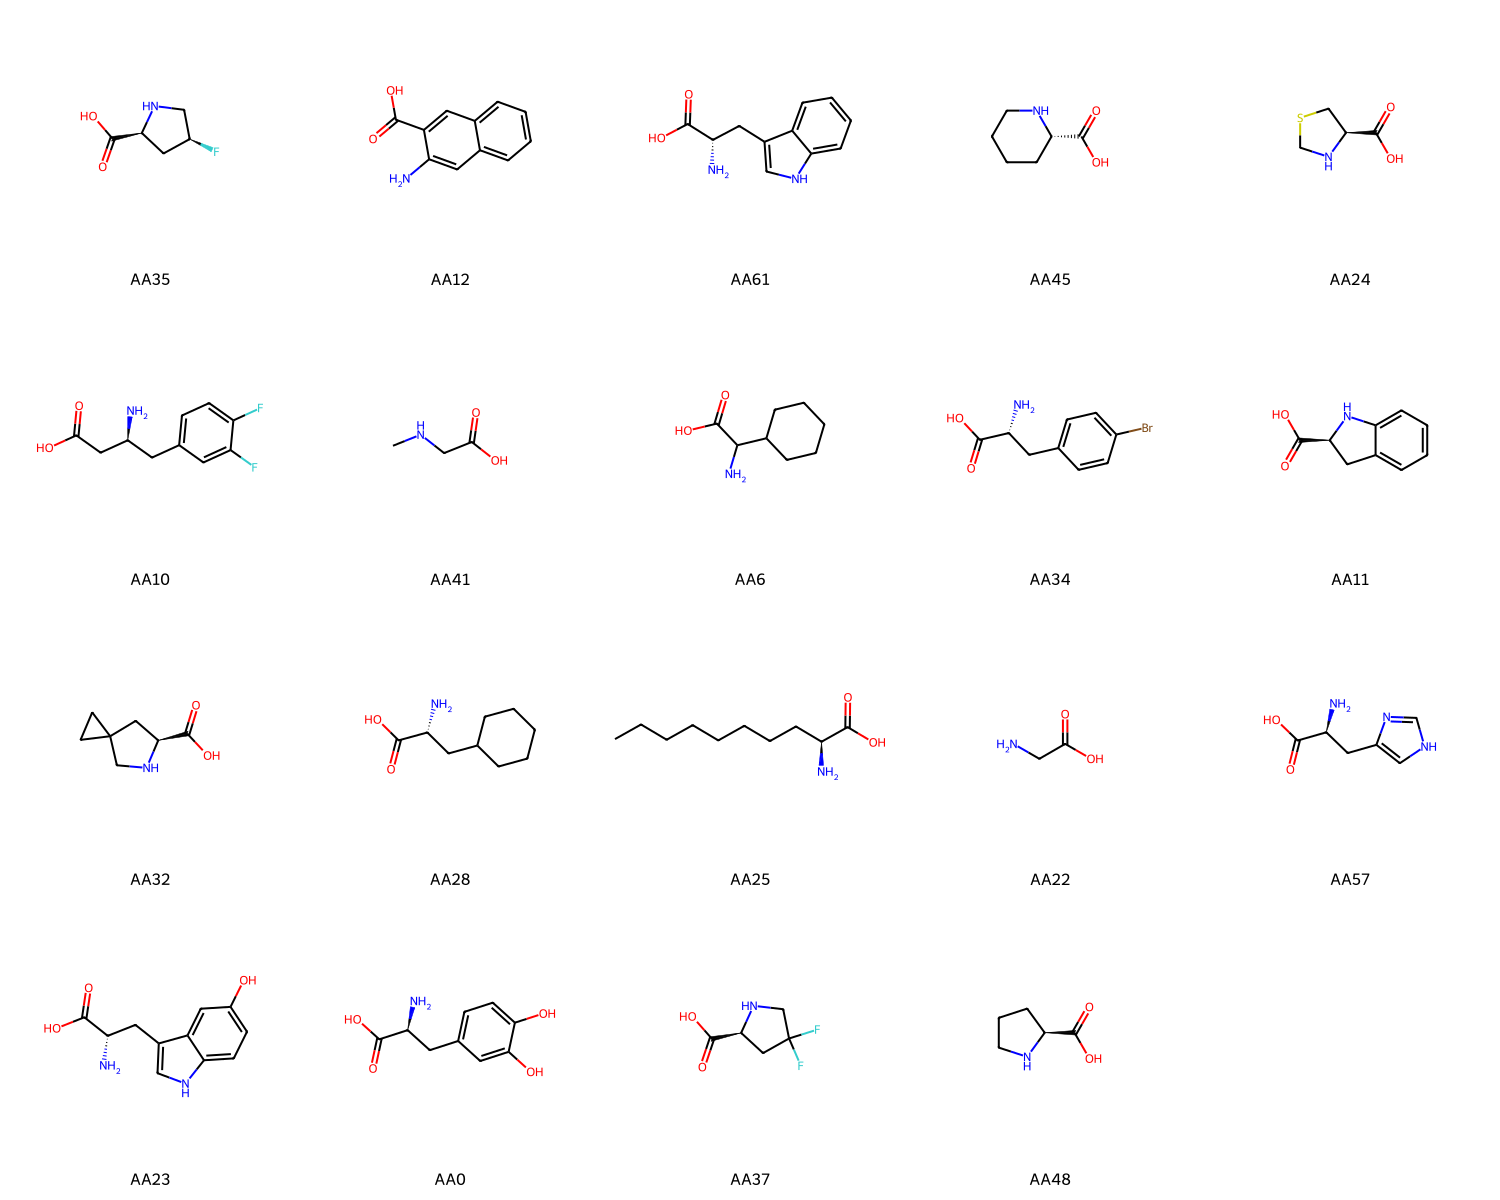

Overlapping Building Blocks for Position 3


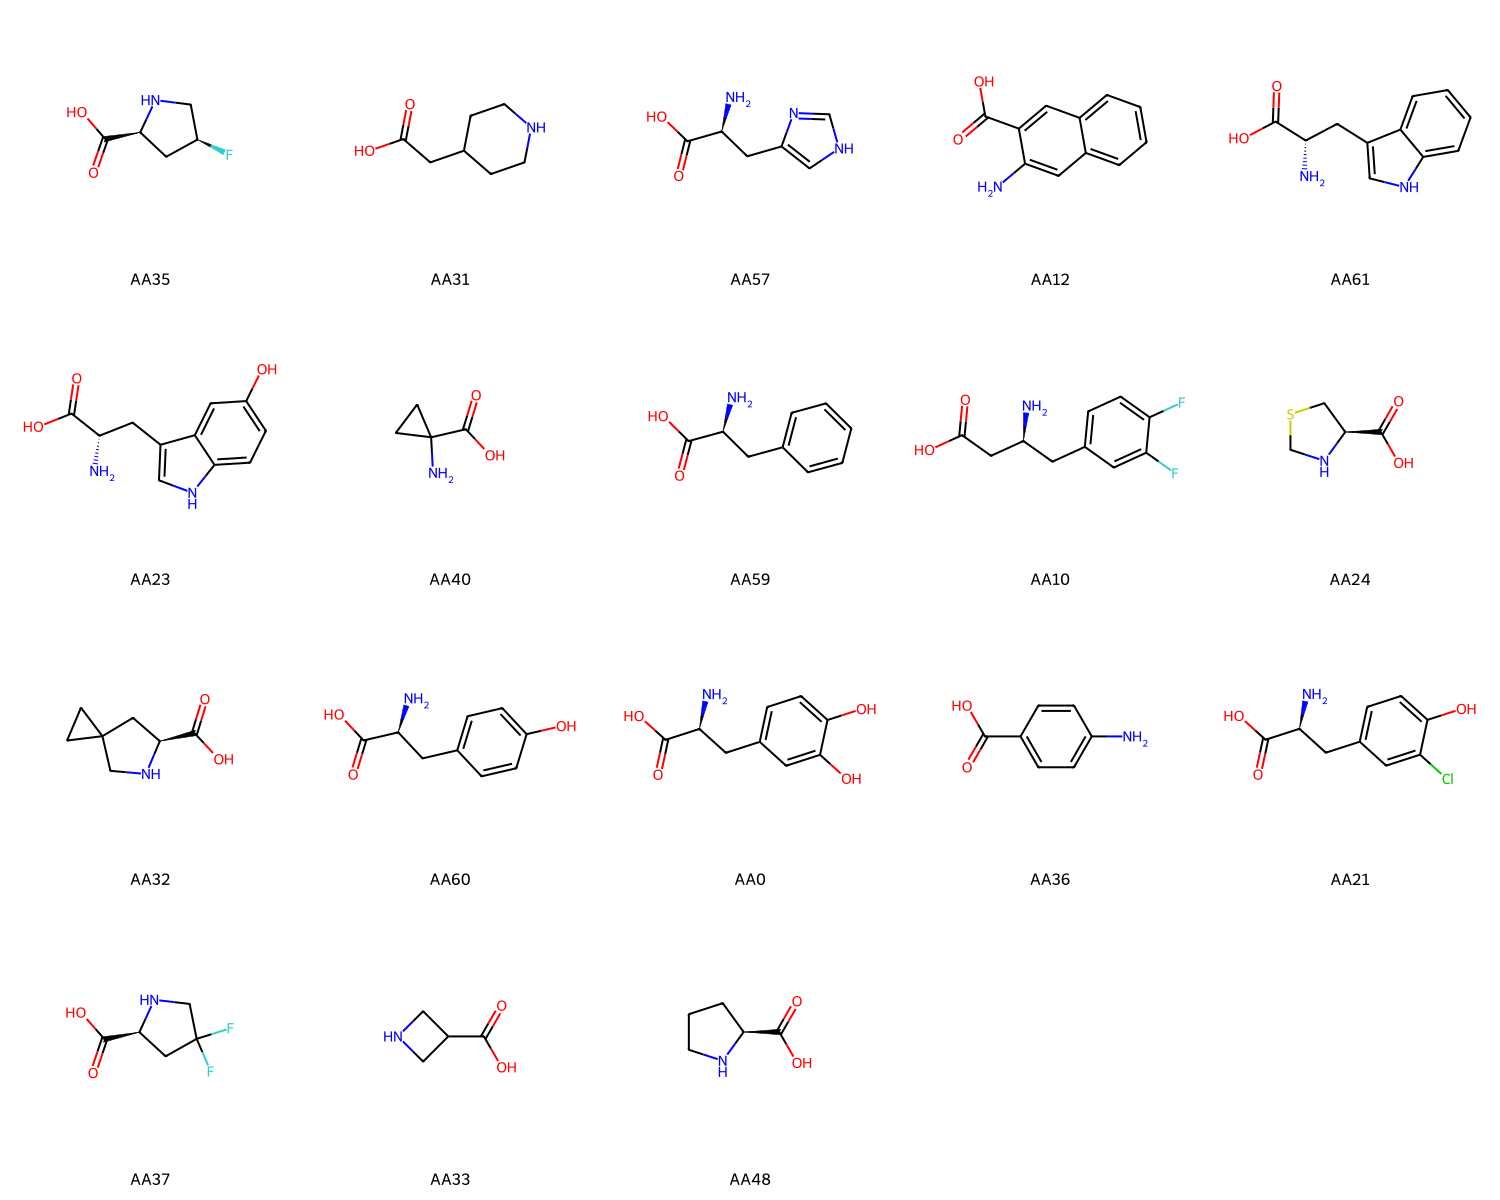

In [59]:
# Example usage
combined_smiles_dict = {**amino_acid_bb_dict, **acids_bb_dict}  # Combine dictionaries for SMILES lookup
total_molecules_200 = 200
total_molecules_400 = 400
total_molecules_800 = 800
total_molecules_1000 = 1000

# Visualize overlaps for each cutoff
print("Visualizing overlaps for top 200 compounds:")
visualize_overlapping_blocks(overlap_200, combined_smiles_dict)

print("Visualizing overlaps for top 400 compounds:")
visualize_overlapping_blocks(overlap_400, combined_smiles_dict)

print("Visualizing overlaps for top 800 compounds:")
visualize_overlapping_blocks(overlap_800, combined_smiles_dict)

print("Visualizing overlaps for top 1000 compounds:")
visualize_overlapping_blocks(overlap_1000, combined_smiles_dict)

## Testing Thompson Sampling

In [35]:
from PRISMS.thompson_sampling.ts_main import *
import json

In [36]:
input_json_file = """{
"reagent_file_list": [
        "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/acids.smi",
        "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/Data/Thrombin/input_files/coupled_aa_sub.smi"
    ],
    "reaction_smarts": "[#6:1](=[O:2])[OH].[#7X3;H1,H2;!$(N[!#6]);!$(N[#6]=[O]);!$(N[#6]~[!#6;!#16]):3]>>[#6:1](=[O:2])[#7:3]",
    "num_warmup_trials": 10,
    "num_ts_iterations": 5000,
    "search_strategy": "greedy_minimize_dt",
    "processes": 1,
    "percent_of_library": 0.1,
    "scaling": -1,
    "temperature": 1,
    "evaluator_class_name": "LookupEvaluator",
    "evaluator_arg": {"ref_filename" : "/Users/aakankschitnandkeolyar/Desktop/TS_Chem_Space/Thrombin/Linear_amide/docking_scores/product_scores.csv"},
    "log_filename": "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/TS_runs/ts_logs.txt",
    "results_filename": "/Users/aakankschitnandkeolyar/Desktop/PRISMS/tests/TS_runs/ts_results.csv"
}"""
input_dict = json.loads(input_json_file)

In [37]:
parse_input_dict(input_dict)

In [38]:
ts_std_df = run_ts(input_dict)

  0%|          | 00:00<?, ?it/s

          score                                             SMILES  \
943  -10.465282  CC(NC(=O)C1(NC(=O)Cn2ccc(NC(=O)OC(c3ccccc3)c3c...   
1583 -10.425935  NC(=O)C1CC2(CC2)CN1C(=O)CNC(=O)Cn1ccc(NC(=O)OC...   
1489 -10.406614  CC(C)(C)OC(=O)NCCCCC(NC(=O)c1cc2ccccc2[nH]1)C(...   
1744 -10.406089  CCC(=O)N1CCC2(CC1)C(=O)N(CC(=O)NC(Cc1cncn1COCc...   
1124 -10.296497  NC(=O)C(Cc1cncn1COCc1ccccc1)NC(=O)COc1ccc2c(c1...   
1566 -10.126266  NC(=O)C1(NC(=O)C(CC2CCCC2)NC(=O)Cn2ccc(NC(=O)O...   
1396 -10.118734  CC(C)(C)OC(=O)NCCCCC(NC(=O)c1cc2sccc2[nH]1)C(=...   
636  -10.094853  CC(OC(C)(C)C)C(NC(=O)C1(NC(=O)Cn2ccc(NC(=O)OC(...   
939  -10.090826  CC(=O)NCC1CCC(C(=O)NC(Cc2cncn2COCc2ccccc2)C(N)...   
133  -10.072140  COC(C)C(=O)Nc1ccc(C(=O)NC(Cc2cncn2COCc2ccccc2)...   

                 Name  
943      CA5_AA4_AA46  
1583    CA5_AA22_AA32  
1489  CA122_AA56_AA57  
1744   CA123_AA3_AA39  
1124   CA59_AA18_AA39  
1566     CA5_AA44_AA4  
1396   CA11_AA56_AA57  
636     CA5_AA40_AA49  
939    CA76_A

In [7]:
ts_std_df.sort_values(by="score", ascending=True).head(100)

score                                             SMILES  \
1235 -11.417522  COC(C)C(=O)N1CCC2(CC1)C(=O)N(CC(=O)NC1c3ccccc3...   
1740 -11.392416  Cc1c(C)c(S(=O)(=O)NC(=N)NCCCC(NC(=O)C(CC(=O)NC...   
1767 -10.533073  NC(=O)C1CSCN1C(=O)C(CC1CCCC1)NC(=O)Cn1ccc(NC(=...   
197  -10.465282  CC(NC(=O)C1(NC(=O)Cn2ccc(NC(=O)OC(c3ccccc3)c3c...   
1323 -10.406089  CCC(=O)N1CCC2(CC1)C(=O)N(CC(=O)NC(Cc1cncn1COCc...   
...         ...                                                ...   
1402  -8.707985  NC(=O)C1CSCN1C(=O)C(NC(=O)Cn1ccc(NC(=O)OC(c2cc...   
803   -8.706249  Cc1ocnc1C(=O)NC(CCCNC(=N)NS(=O)(=O)c1c(C)c(C)c...   
200   -8.705202  CN(CC(N)=O)C(=O)C1(NC(=O)Cn2ccc(NC(=O)OC(c3ccc...   
1171  -8.702847  CC(C)(C)OC(=O)CCC(NC(=O)Cc1ccc2c(c1)CCO2)C(=O)...   
827   -8.701231  CN(CC(N)=O)C(=O)C1(NC(=O)Cn2ccc(NC(=O)OC(c3ccc...   

                Name  
1235   CA34_AA3_AA18  
1740  CA89_AA51_AA58  
1767   CA5_AA44_AA24  
197     CA5_AA4_AA46  
1323  CA123_AA3_AA39  
...              ...  
1402   CA5_AA15_AA24  
803    CA90_AA58_AA3  
200    CA5_AA30_AA41  
1171   CA16_AA54_AA3  
827    CA5_AA16_AA41  

[100 rows x 3 columns]

In [7]:
prod_scores_df.sort("Scores", descending=False).head(100)

shape: (100, 2)
┌─────────────────┬────────────┐
│ Product_Code    ┆ Scores     │
│ ---             ┆ ---        │
│ str             ┆ f64        │
╞═════════════════╪════════════╡
│ CA99_AA28_AA61  ┆ -17.828762 │
│ CA124_AA28_AA61 ┆ -17.288765 │
│ CA95_AA28_AA61  ┆ -17.248438 │
│ CA116_AA28_AA61 ┆ -17.240562 │
│ CA30_AA28_AA61  ┆ -17.236963 │
│ …               ┆ …          │
│ CA83_AA32_AA61  ┆ -16.092438 │
│ CA110_AA6_AA21  ┆ -16.090384 │
│ CA15_AA22_AA60  ┆ -16.089331 │
│ CA52_AA28_AA61  ┆ -16.087118 │
│ CA72_AA22_AA59  ┆ -16.079922 │
└─────────────────┴────────────┘

In [39]:
# Modify the TS dataframe so that it is compatible with the get_top_building_blocks function
ts_df_mod = ts_std_df.copy()
ts_df_mod = ts_df_mod.drop("SMILES",axis=1)
ts_df_mod.rename(columns={"score":"Scores", "Name":"Product_Code"},inplace=True)
top_5000_building_blocks_ts_df = get_top_building_blocks(ts_df_mod, 5000)

Position 1: 17 building blocks overlap
Position 2: 16 building blocks overlap
Position 3: 16 building blocks overlap
Total number of overlapping compounds across all positions: 49
Overlapping Building Blocks for Position 1


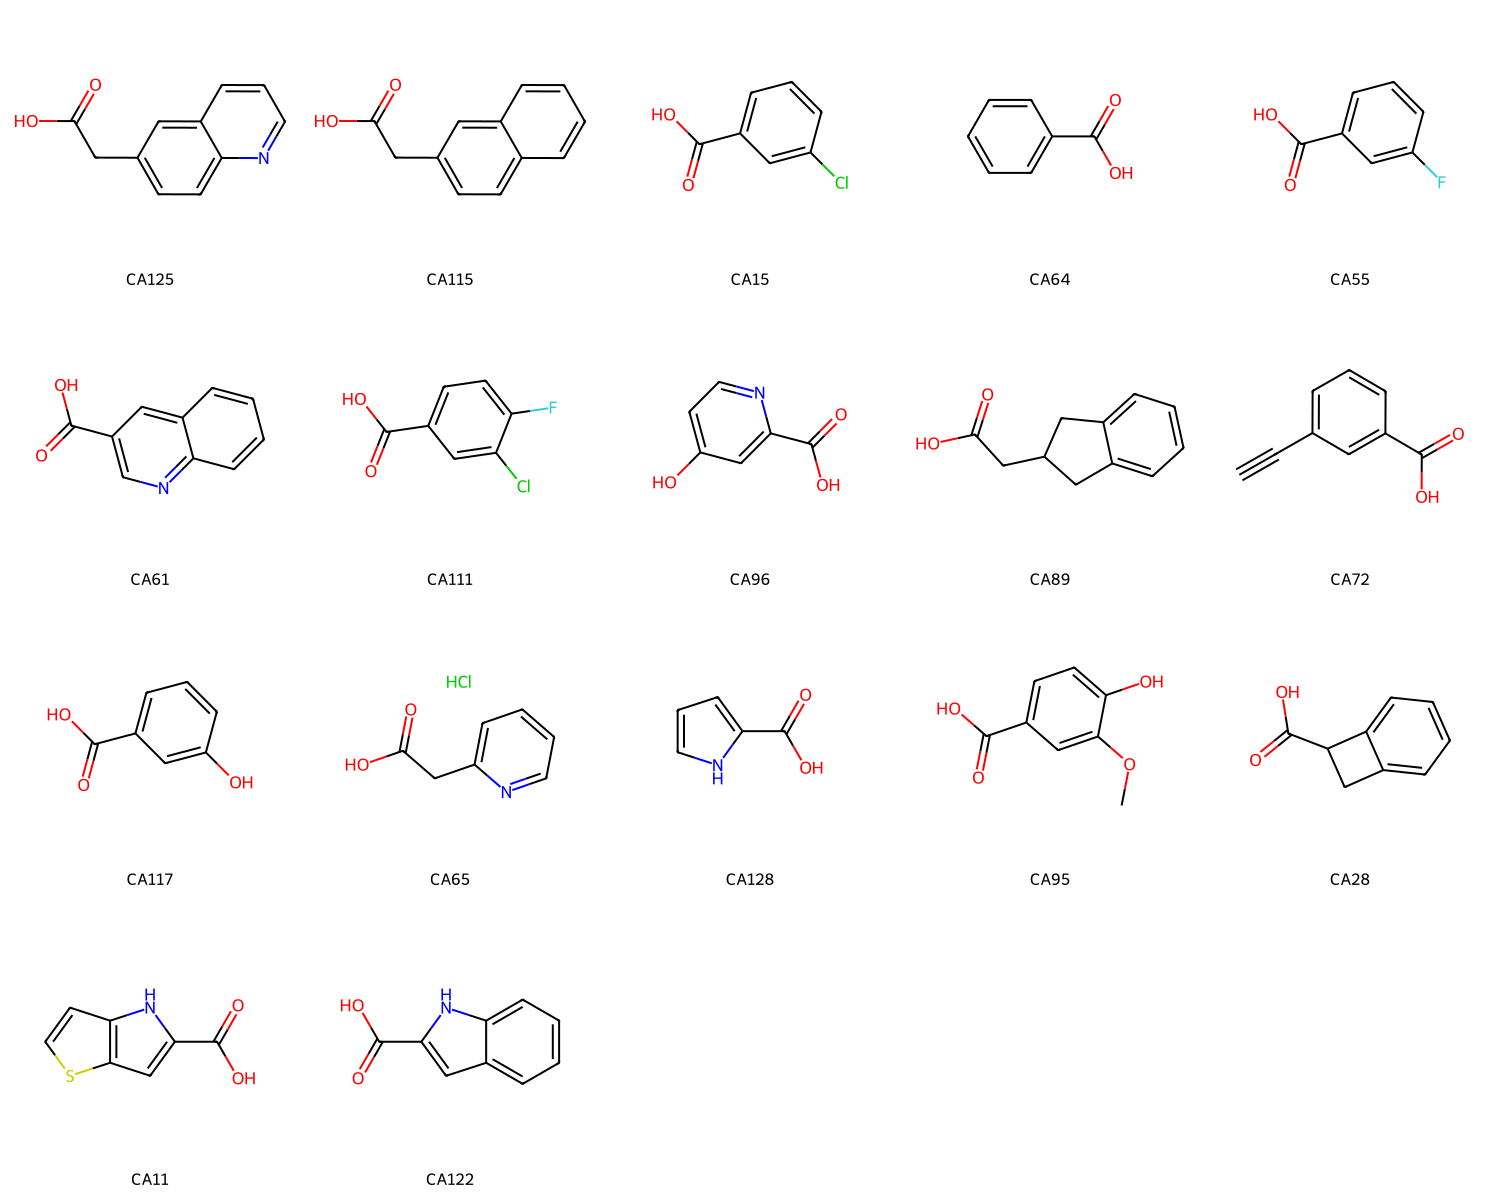

Overlapping Building Blocks for Position 2


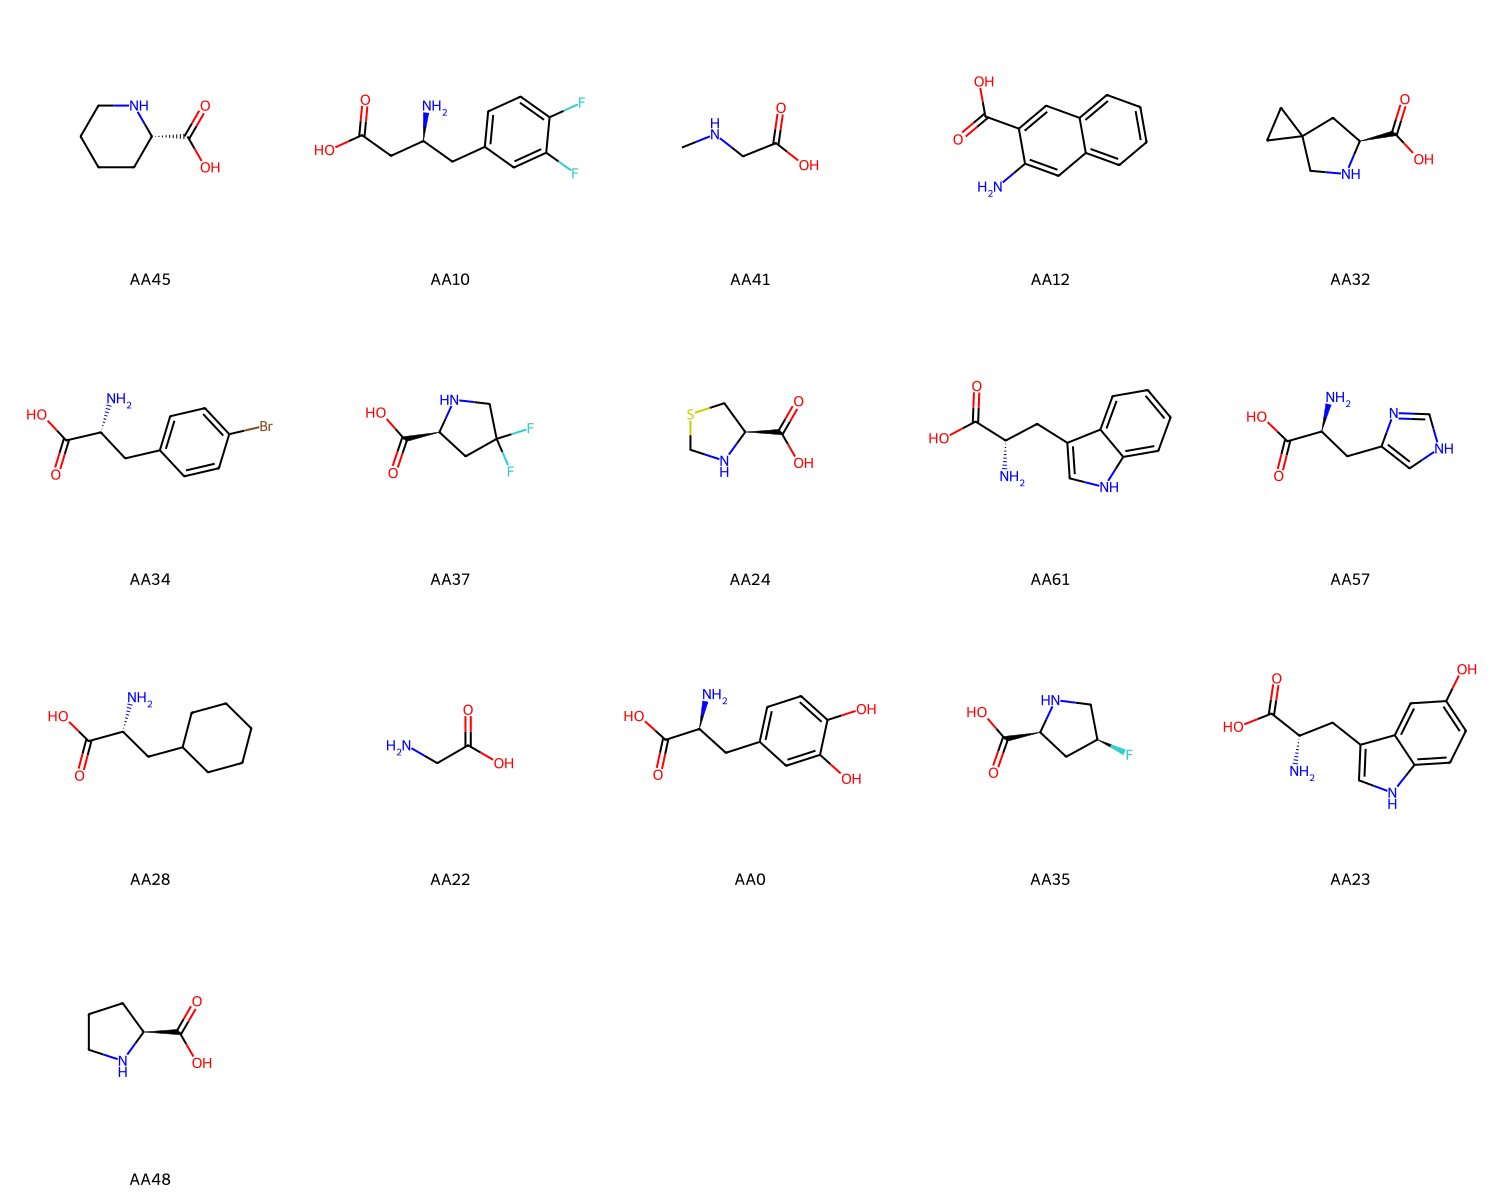

Overlapping Building Blocks for Position 3


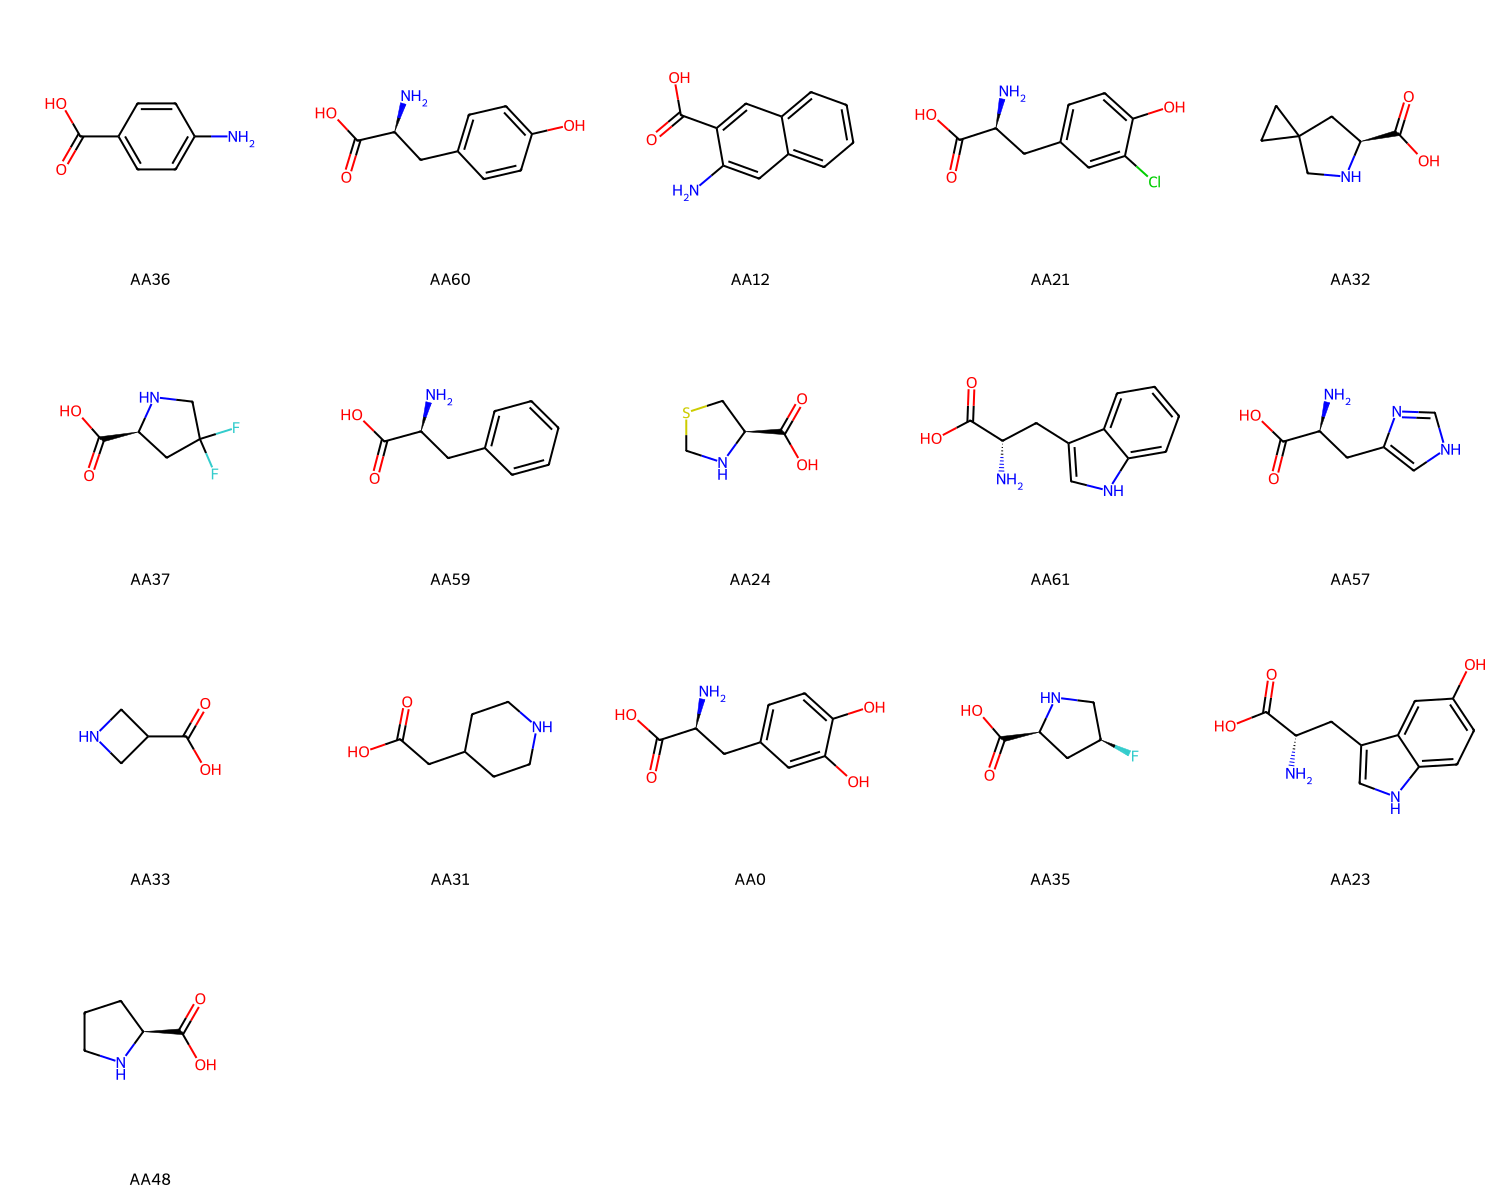

In [40]:
# Check the overlap between the enriched building blocks from the TS and the top 5000 building blocks from brute force docking
overlap_ts = check_overlap(top_5000_building_blocks_ts_df, top_5000_building_blocks)
visualize_overlapping_blocks(overlap_ts, combined_smiles_dict)

### Check Consistency of the TS results

In [7]:
ts_df_list = []
for i in tqdm(range(0,10)):
    ts_df_list.append(run_ts(input_dict, hide_progress=True))

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
# Extract the product codes as a list
product_codes = ts_std_df["Name"].to_list()

# Initialize counters for each position
position_counters = []

# Iterate through the product codes
for product_code in product_codes:
    building_blocks = product_code.split("_")  # Split the product code by "_"
    # Ensure the position_counters list is large enough to handle all positions
    while len(position_counters) < len(building_blocks):
        position_counters.append(Counter())
    # Update the counters for each position
    for i, block in enumerate(building_blocks):
        position_counters[i][block] += 1

# Find the top 20 building blocks for each position
for i, counter in enumerate(position_counters):
    print(f"Top 20 building blocks for position {i + 1}:")
    print(f"{'Building Block':<20}{'Frequency':<10}")
    print("-" * 30)
    for block, count in counter.most_common(20):
        print(f"{block:<20}{count:<10}")
    print("\n")

Top 20 building blocks for position 1:
Building Block      Frequency 
------------------------------
CA122               2098      
CA117               462       
CA11                60        
CA128               59        
CA115               55        
CA96                53        
CA55                51        
CA28                46        
CA72                42        
CA125               39        
CA104               38        
CA111               38        
CA64                37        
CA108               36        
CA95                36        
CA29                36        
CA89                35        
CA86                35        
CA88                34        
CA9                 33        


Top 20 building blocks for position 2:
Building Block      Frequency 
------------------------------
AA28                546       
AA61                321       
AA23                308       
AA22                271       
AA37                262       
AA41                2

In [25]:
# Collect the top 20 building blocks for each position
top_20_building_blocks_per_position = []
for counter in position_counters:
    top_20_blocks = [block for block, _ in counter.most_common(20)]
    top_20_building_blocks_per_position.append(top_20_blocks)

# Convert the list to a tuple
top_20_building_blocks_tuple = tuple(top_20_building_blocks_per_position)

Top 20 Building Blocks for Position 1


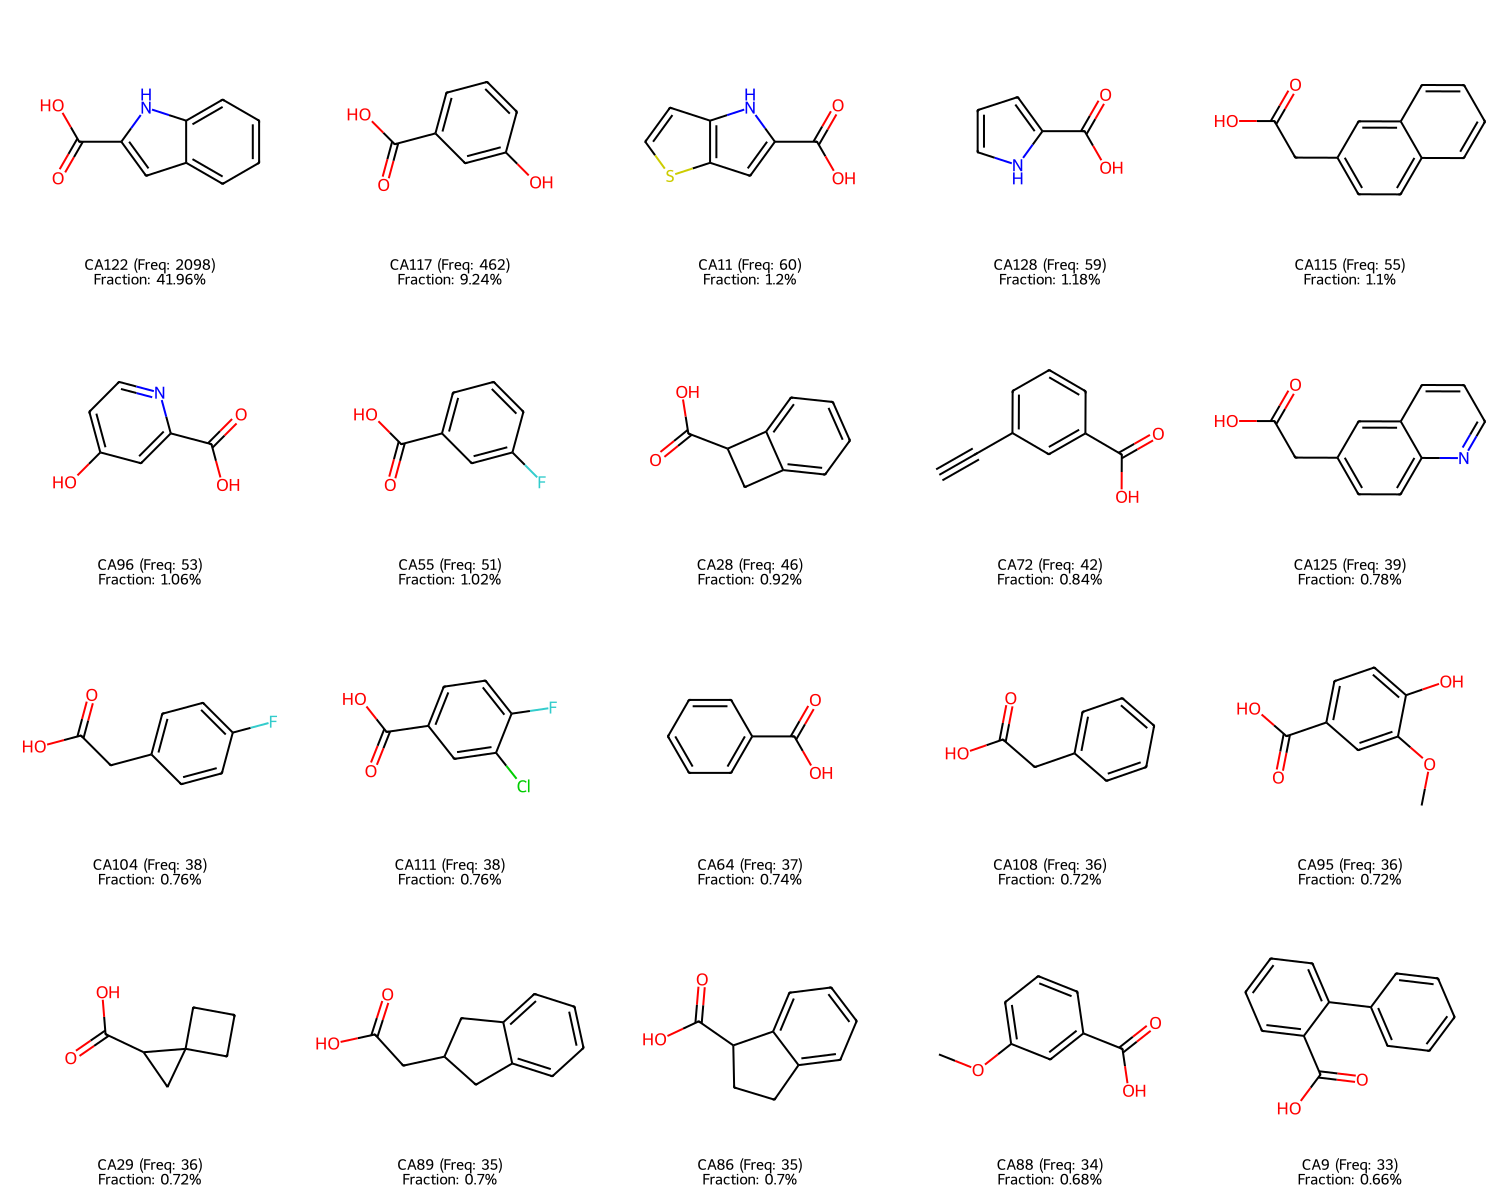

Top 20 Building Blocks for Position 2


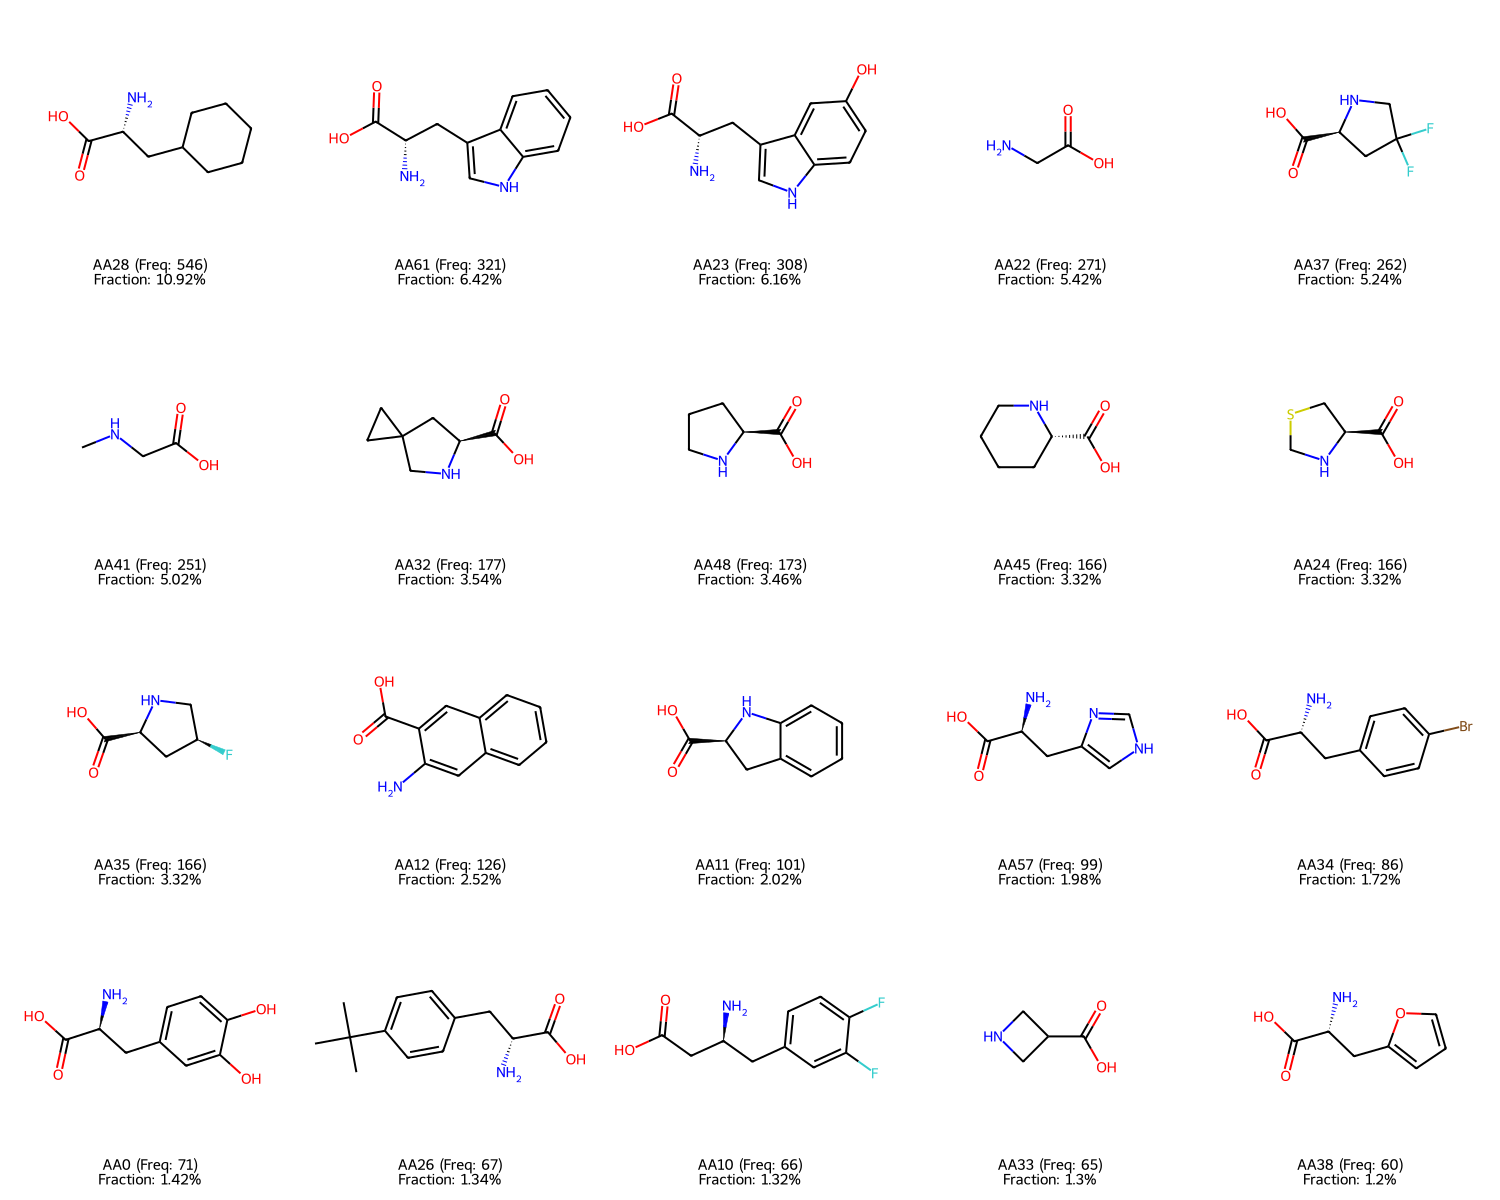

Top 20 Building Blocks for Position 3


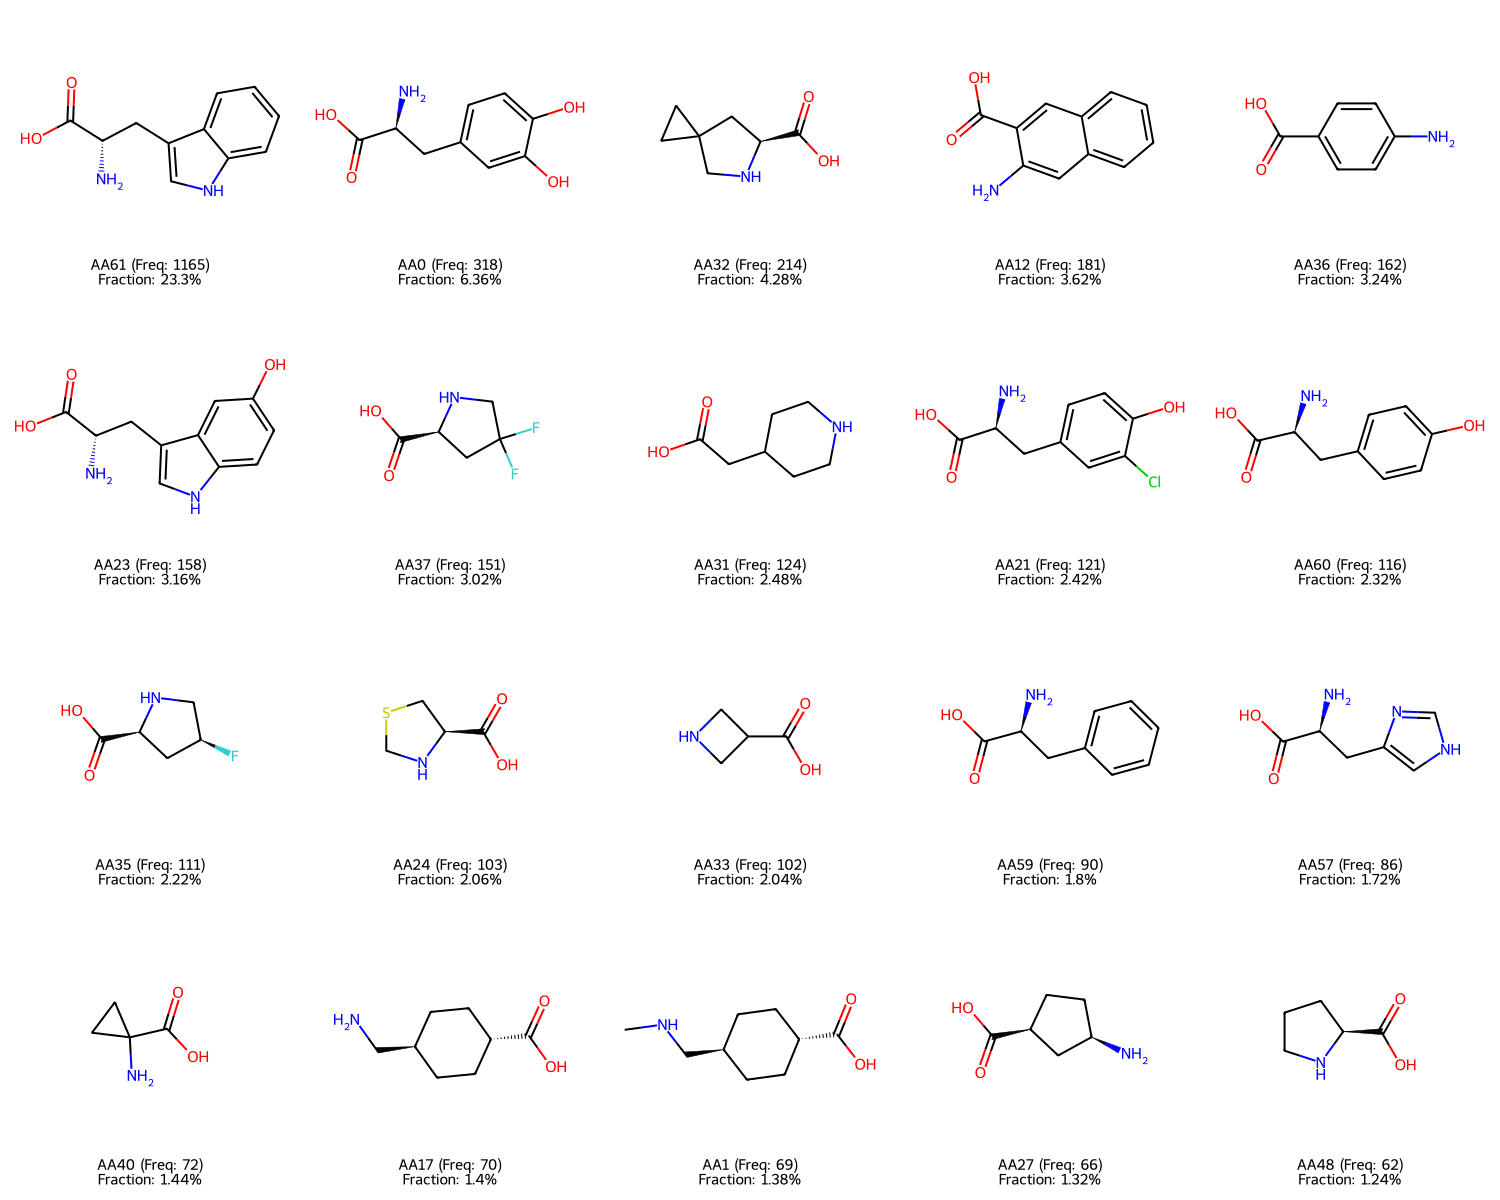

In [27]:
total_molecules = 5000  # The top 1% of products
# Combine the two dictionaries
combined_smiles_dict = {**amino_acid_bb_dict, **acids_bb_dict}

# Iterate through each position's top 20 building blocks
for i, counter in enumerate(position_counters):
    # Get the top 20 building blocks for the current position
    top_20_blocks = counter.most_common(20)
    
    # Create a list of RDKit molecules and their labels
    mols = []
    legends = []
    for block, freq in top_20_blocks:
        if block in combined_smiles_dict:  # Use the combined dictionary
            smiles = combined_smiles_dict[block]
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mols.append(mol)
                # Add building block name and frequency on the first line, fraction on the second line
                legends.append(f"{block} (Freq: {freq})\nFraction: {round((freq / total_molecules) * 100, 2)}%")
    
    # Visualize the molecules in a grid
    img = Draw.MolsToGridImage(
        mols, legends=legends, molsPerRow=5, subImgSize=(300, 300)
    )
    
    # Display the title and the image
    print(f"Top 20 Building Blocks for Position {i + 1}")
    display(img)  # Display the image in the Jupyter Notebook

## Boltzmann Sampling 
Utilizes Boltzmann sampling instead of standard greedy sampling to find new compounds to test.

In [8]:
import copy
input_dict_boltzmann = copy.copy(input_dict)
input_dict_boltzmann["search_strategy"] = "boltzmann_minimize"

In [8]:
ts_boltzmann_df = run_ts(input_dict_boltzmann)

  0%|          | 00:00<?, ?it/s

           score                                             SMILES  \
5611  -16.722372  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C(CC2CCCCC2)NC(=O)...   
4046  -16.427826  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C(CC2CCCCC2)NC(=O)...   
9610  -16.357809  CN(CC(=O)NC(Cc1cn(C(=O)OC(C)(C)C)c2ccccc12)C(N...   
5169  -16.335579  NC(=O)C1(NC(=O)C(Cc2cn(C(c3ccccc3)(c3ccccc3)c3...   
2013  -16.189180  COc1cccc(CC(=O)N(C)CC(=O)NC(Cc2cn(C(=O)OC(C)(C...   
8270  -16.043238  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C(CC2CCCCC2)NC(=O)...   
6694  -16.016642  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC(F)(F)CN2C(=O)...   
11230 -15.939465  NC(=O)C(Cc1ccc(Br)cc1)NC(=O)COCC1CCCN1C(=O)c1c...   
6839  -15.922540  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC3(CC3)CN2C(=O)...   
185   -15.912345  Cc1cn(CC(=O)Nc2cc3ccccc3cc2C(=O)N2CCC(CC(N)=O)...   

                  Name  
5611    CA19_AA28_AA61  
4046   CA114_AA28_AA61  
9610   CA108_AA41_AA61  
5169    CA69_AA57_AA13  
2013   CA119_AA41_AA61  
8270    CA64_AA28_AA61  
6694   CA111_AA37_AA61  
11230    CA0_AA19_

In [23]:
# Modify the TS dataframe so that it is compatible with the get_top_building_blocks function
ts_Boltzmann_df_mod = ts_boltzmann_df.copy()
ts_Boltzmann_df_mod = ts_Boltzmann_df_mod.drop("SMILES",axis=1)
ts_Boltzmann_df_mod.rename(columns={"score":"Scores", "Name":"Product_Code"},inplace=True)
top_5000_building_blocks_ts_Boltzmann_df = get_top_building_blocks(ts_Boltzmann_df_mod, 5000)

Position 1: 12 building blocks overlap
Position 2: 16 building blocks overlap
Position 3: 15 building blocks overlap
Total number of overlapping compounds across all positions: 43
Overlapping Building Blocks for Position 1


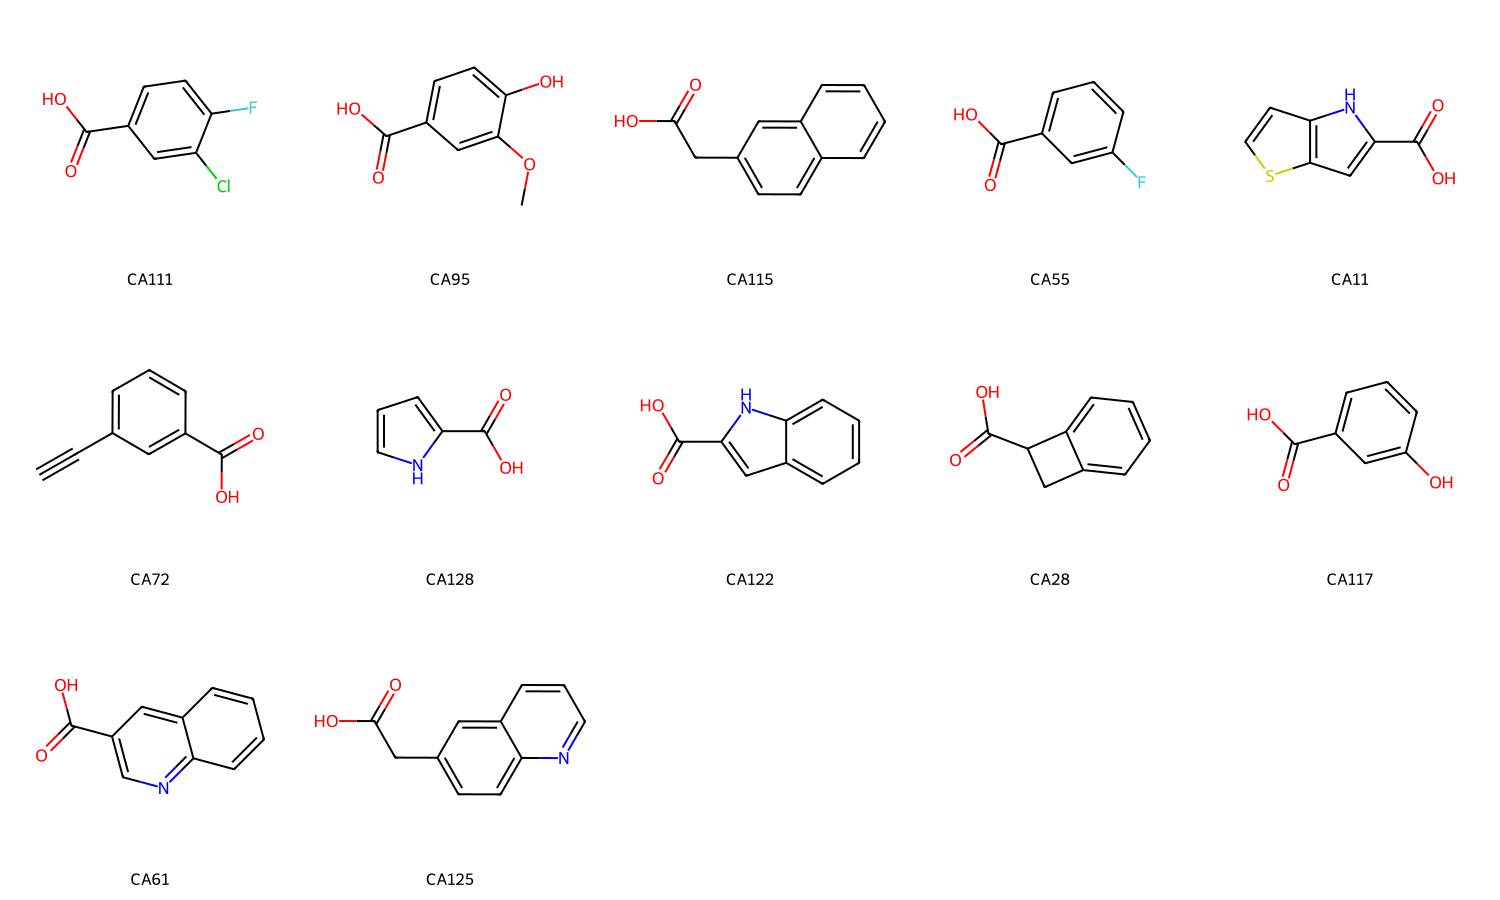

Overlapping Building Blocks for Position 2


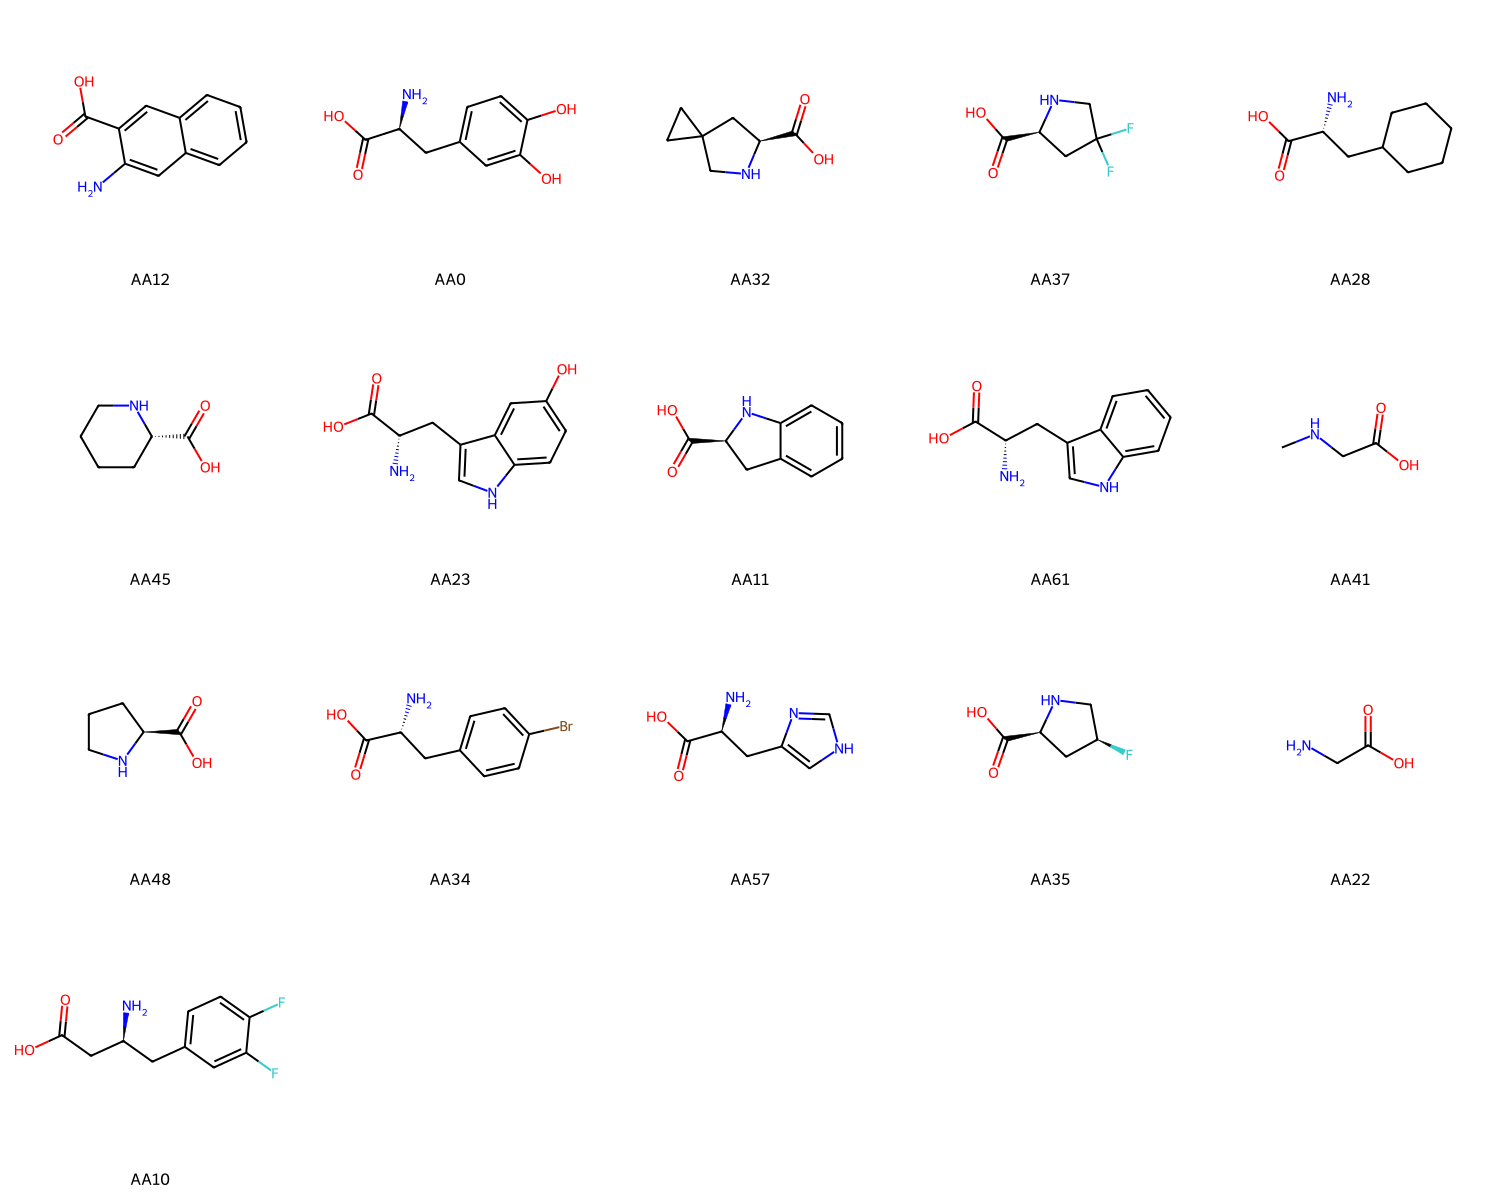

Overlapping Building Blocks for Position 3


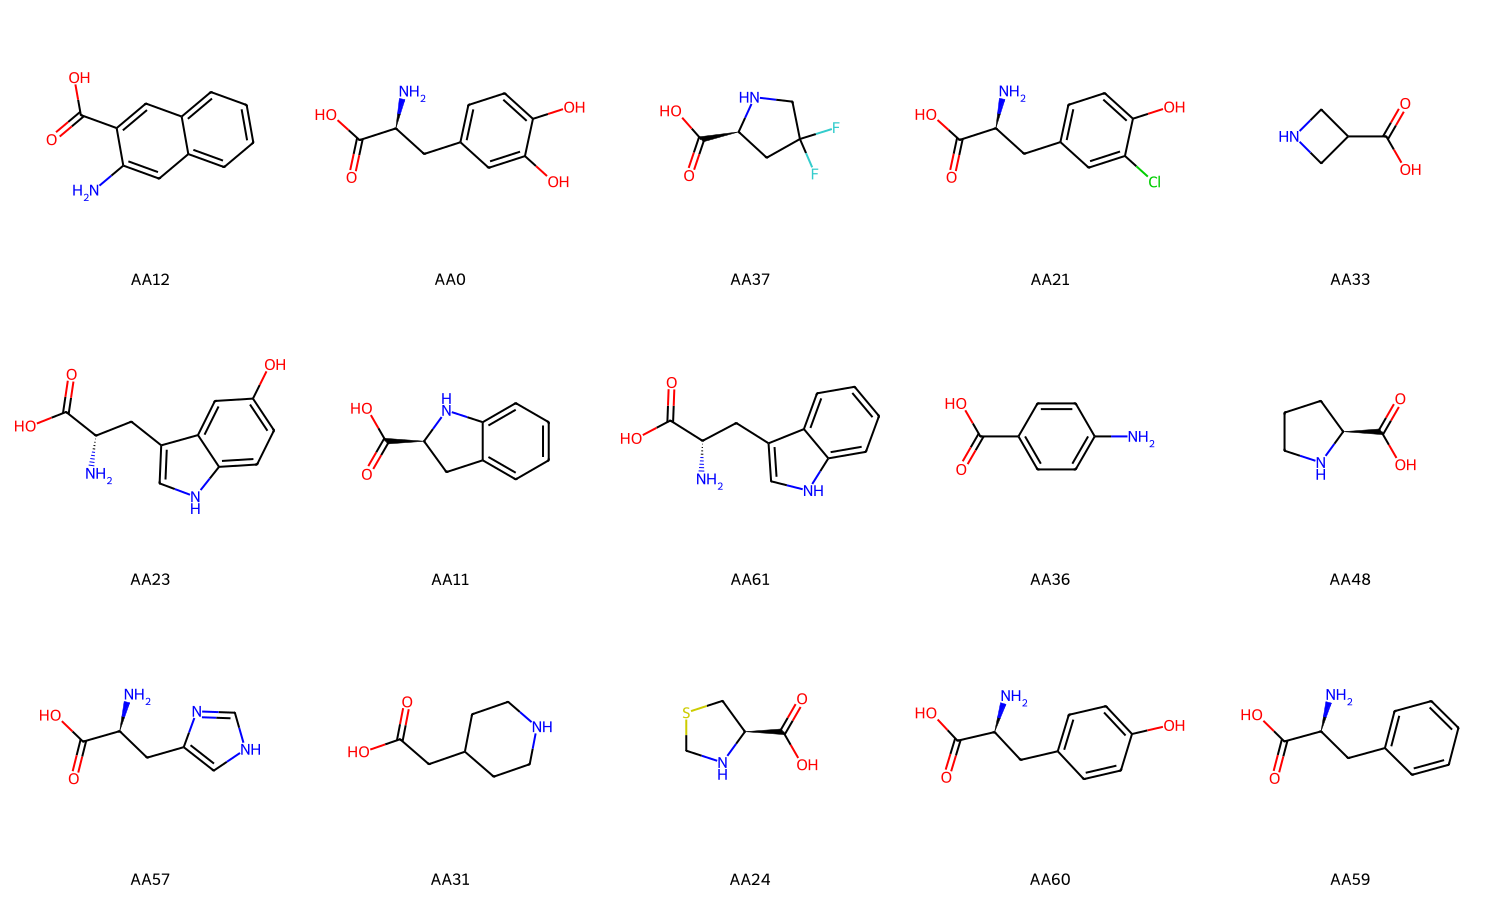

In [30]:
# Check the overlap between the enriched building blocks from the TS and the top 5000 building blocks from brute force docking
overlap_ts_Boltzmann = check_overlap(top_5000_building_blocks_ts_Boltzmann_df, top_5000_building_blocks)
visualize_overlapping_blocks(overlap_ts_Boltzmann, combined_smiles_dict)

In [38]:
# Generate 10 runs of Boltzmann Sampling
ts_boltzmann_df_list = []
for i in tqdm(range(0,10)):
    ts_boltzmann_df_list.append(run_ts(input_dict_boltzmann, hide_progress=True))

  0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
# Extract the product codes as a list
product_codes = ts_boltzmann_df["Name"].to_list()

# Initialize counters for each position
position_counters = []

# Iterate through the product codes
for product_code in product_codes:
    building_blocks = product_code.split("_")  # Split the product code by "_"
    # Ensure the position_counters list is large enough to handle all positions
    while len(position_counters) < len(building_blocks):
        position_counters.append(Counter())
    # Update the counters for each position
    for i, block in enumerate(building_blocks):
        position_counters[i][block] += 1

# Find the top 20 building blocks for each position
for i, counter in enumerate(position_counters):
    print(f"Top 20 building blocks for position {i + 1}:")
    print(f"{'Building Block':<20}{'Frequency':<10}")
    print("-" * 30)
    for block, count in counter.most_common(20):
        print(f"{block:<20}{count:<10}")
    print("\n")

Top 20 building blocks for position 1:
Building Block      Frequency 
------------------------------
CA117               79        
CA96                77        
CA122               77        
CA28                74        
CA55                72        
CA115               66        
CA11                65        
CA95                64        
CA72                63        
CA86                61        
CA64                60        
CA128               60        
CA125               59        
CA79                56        
CA29                56        
CA88                54        
CA9                 54        
CA108               52        
CA43                52        
CA78                52        


Top 20 building blocks for position 2:
Building Block      Frequency 
------------------------------
AA28                184       
AA61                146       
AA23                127       
AA37                114       
AA0                 108       
AA22                1

#### Run these cells to generate the plots

In [8]:
# Combine the dataframes 
docking_df = prod_scores_df.to_pandas() # Convert the polars dataframe to a pandas dataframe
docking_df.rename(columns={"Product_Code":"Name", "Scores":"score"},inplace=True)
docking_df["method"] = "ref"
docking_df["cycle"] = "ref"
ref_df = docking_df.sort_values(by="score", ascending=True).head(100)

NameError: name 'prod_scores_df' is not defined

In [39]:
# Process the TS dataframes
# We can substitute the regular TS with enhanced TS here
ts_graph_df_list = []
ts_enhanced_df_list_graph = []
ts_boltzmann_df_list_graph = []
for i in range(0,10):
    ts_df_temp = ts_df_list[i].copy()
    ts_df_temp["cycle"] = i
    ts_df_temp["method"] = "TS"
    ts_df_temp.drop(columns=["SMILES"],inplace=True)
    ts_graph_df_list.append(ts_df_temp)
    ts_enhanced_temp_df = ts_enhanced_df_list[i].copy()
    ts_enhanced_temp_df["cycle"] = i
    ts_enhanced_temp_df["method"] = "TS_enhanced"
    ts_enhanced_temp_df.drop(columns=["SMILES"],inplace=True)
    ts_enhanced_df_list_graph.append(ts_enhanced_temp_df)
    ts_boltzmann_temp_df = ts_boltzmann_df_list[i].copy()
    ts_boltzmann_temp_df["cycle"] = i
    ts_boltzmann_temp_df["method"] = "TS_Boltzmann"
    ts_boltzmann_temp_df.drop(columns=["SMILES"],inplace=True)
    ts_boltzmann_df_list_graph.append(ts_boltzmann_temp_df)

In [40]:
# Concatenate the dataframes
ts_combo_df = pd.concat([x.sort_values(by="score", ascending=True).head(100) for x in ts_graph_df_list])
ts_enhanced_combo_df = pd.concat([x.sort_values(by="score", ascending=True).head(100) for x in ts_enhanced_df_list_graph])
ts_boltzmann_combo_df = pd.concat([x.sort_values(by="score", ascending=True).head(100) for x in ts_boltzmann_df_list_graph])

In [41]:
# Create concatenated data points only for TS, TS_enhanced and TS_Boltzmann
concat_data = pd.DataFrame({
    'cycle': ['concat'] * (len(ts_combo_df) + len(ts_enhanced_combo_df) + len(ts_boltzmann_combo_df)),
    'score': pd.concat([ts_combo_df['score'], ts_enhanced_combo_df['score'], ts_boltzmann_combo_df['score']]),
    'method': pd.concat([ts_combo_df['method'], ts_enhanced_combo_df['method'], ts_boltzmann_combo_df['method']])
})

In [42]:
combined_df = pd.concat([ts_combo_df, ts_enhanced_combo_df, ts_boltzmann_combo_df, concat_data, ref_df])
combined_df.reset_index(drop=True,inplace=True)
combined_df.method = pd.Categorical(combined_df.method, categories=["ref","TS", "TS_enhanced", "TS_Boltzmann"], ordered=True)

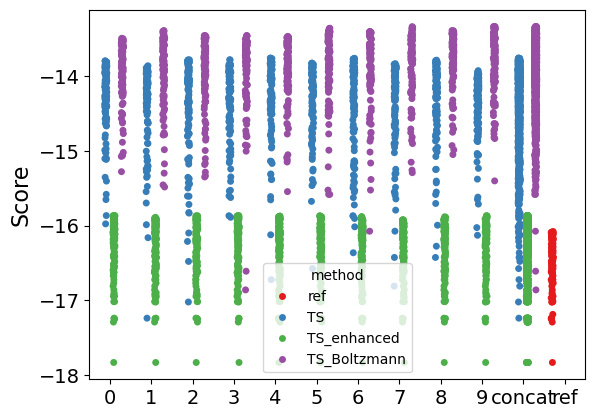

In [43]:
# Define a consistent color palette
palette_colors = sns.color_palette("Set1")[:4]

# Top subplot (stripplot) with concatenated results
ax1 = sns.stripplot(data=combined_df, x="cycle", y="score", hue="method", dodge=True, palette=palette_colors)
ax1.set_ylabel("Score", fontsize=16)
ax1.set_xlabel("")
ax1.tick_params(axis='both', which='major', labelsize=14)


In [35]:
# Estimate the numbers of hits found by each method in each cycle
ref_products = ref_df["Name"].to_list()
plot_list = []
for cycle in range(0,10):
    num_in_cycle = len(combined_df.query("cycle == @cycle and method == 'TS' and Name in @ref_products"))
    plot_list.append([cycle+1,num_in_cycle,'TS'])
for cycle in range(0,10):
    num_in_cycle = len(combined_df.query("cycle == @cycle and method == 'TS_enhanced' and Name in @ref_products"))
    plot_list.append([cycle+1,num_in_cycle,'TS_enhanced'])
for cycle in range(0,10):
    num_in_cycle = len(combined_df.query("cycle == @cycle and method == 'TS_Boltzmann' and Name in @ref_products"))
    plot_list.append([cycle+1,num_in_cycle,'TS_Boltzmann'])
# Get Percentage of hits found by each method in each cycle
plot_list.append(["concat",len(ts_enhanced_combo_df.query("Name in @ref_products").drop_duplicates(subset=["Name"])),"TS_enhanced"])
plot_list.append(["concat",len(ts_boltzmann_combo_df.query("Name in @ref_products").drop_duplicates(subset=["Name"])),"TS_Boltzmann"])
plot_list.append(["concat",len(ts_combo_df.query("Name in @ref_products").drop_duplicates(subset=["Name"])),"TS"])
plot_list.append(["ref",100,"ref"])
plot_df = pd.DataFrame(plot_list, columns=["cycle","found","method"])
plot_df.method = pd.Categorical(plot_df.method, categories=["ref","TS", "TS_enhanced", "TS_Boltzmann"], ordered=True)

In [26]:
# Lets check if there is an actual difference between the standard and the enhanced TS
from scipy import stats
f_stat, p_value = stats.f_oneway(plot_df.loc[plot_df["method"] == "TS","found"], 
                                 plot_df.loc[plot_df["method"] == "TS_enhanced","found"], 
                                 plot_df.loc[plot_df["method"] == "TS_Boltzmann","found"])
print(f"F-statistic: {f_stat}, P-value: {p_value}")

F-statistic: 740.3917175831539, P-value: 2.942968439578483e-26


In [129]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=plot_df["found"], groups=plot_df["method"], alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1       group2    meandiff p-adj   lower    upper   reject
------------------------------------------------------------------
          TS TS_Boltzmann -50.3636    0.0 -60.7692 -39.9581   True
          TS  TS_enhanced   8.1818 0.1644  -2.2238  18.5874  False
          TS          ref  38.3636 0.0016  12.8753   63.852   True
TS_Boltzmann  TS_enhanced  58.5455    0.0  48.1399   68.951   True
TS_Boltzmann          ref  88.7273    0.0  63.2389 114.2156   True
 TS_enhanced          ref  30.1818 0.0154   4.6935  55.6702   True
------------------------------------------------------------------


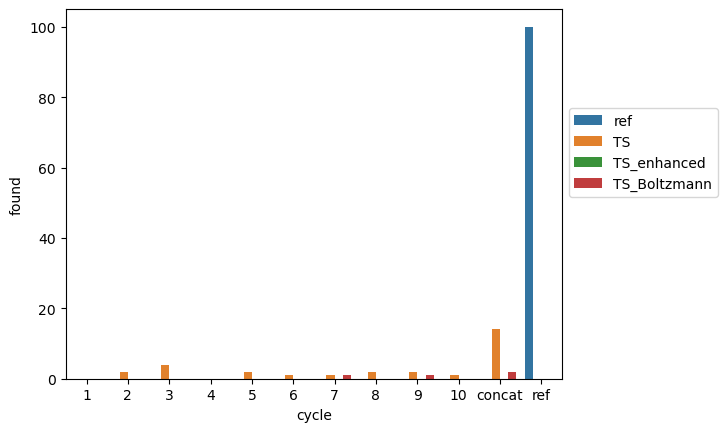

In [21]:
ax = sns.barplot(x="cycle",y="found",hue="method",data=plot_df, dodge=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)

Text(0, 0.5, 'found')

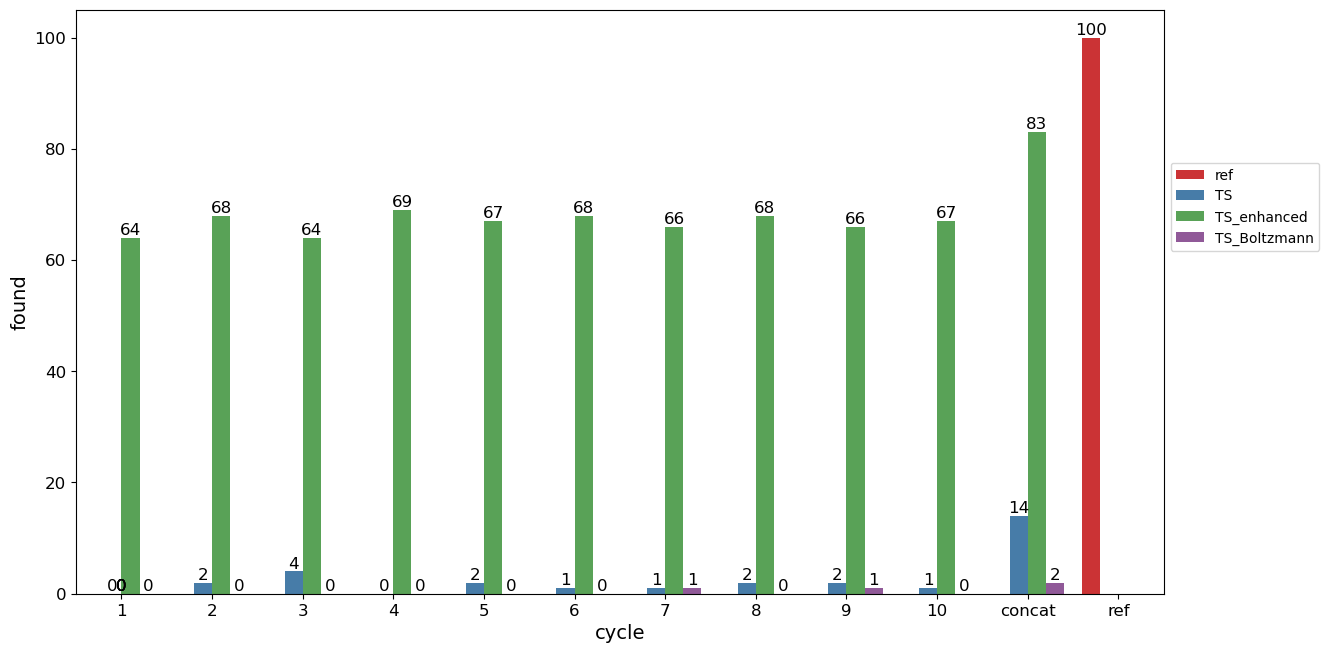

In [36]:
# Create a larger figure
plt.figure(figsize=(15, 8))  # Increase these numbers to make plot bigger (width, height)

# Create the barplot with wider bars
ax = sns.barplot(x="cycle", y="found", hue="method", data=plot_df, dodge=True, width=0.8, palette="Set1")  # width controls bar width
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)

# Add value labels manually with larger font size
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                xy=(p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom',
                fontsize=12)  # Increase font size of the numbers

# Adjust figure margins
plt.subplots_adjust(right=0.85, bottom=0.15)

# Optional: Increase font size of axis labels and ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
ax.set_ylabel(ax.get_ylabel(), fontsize=14)

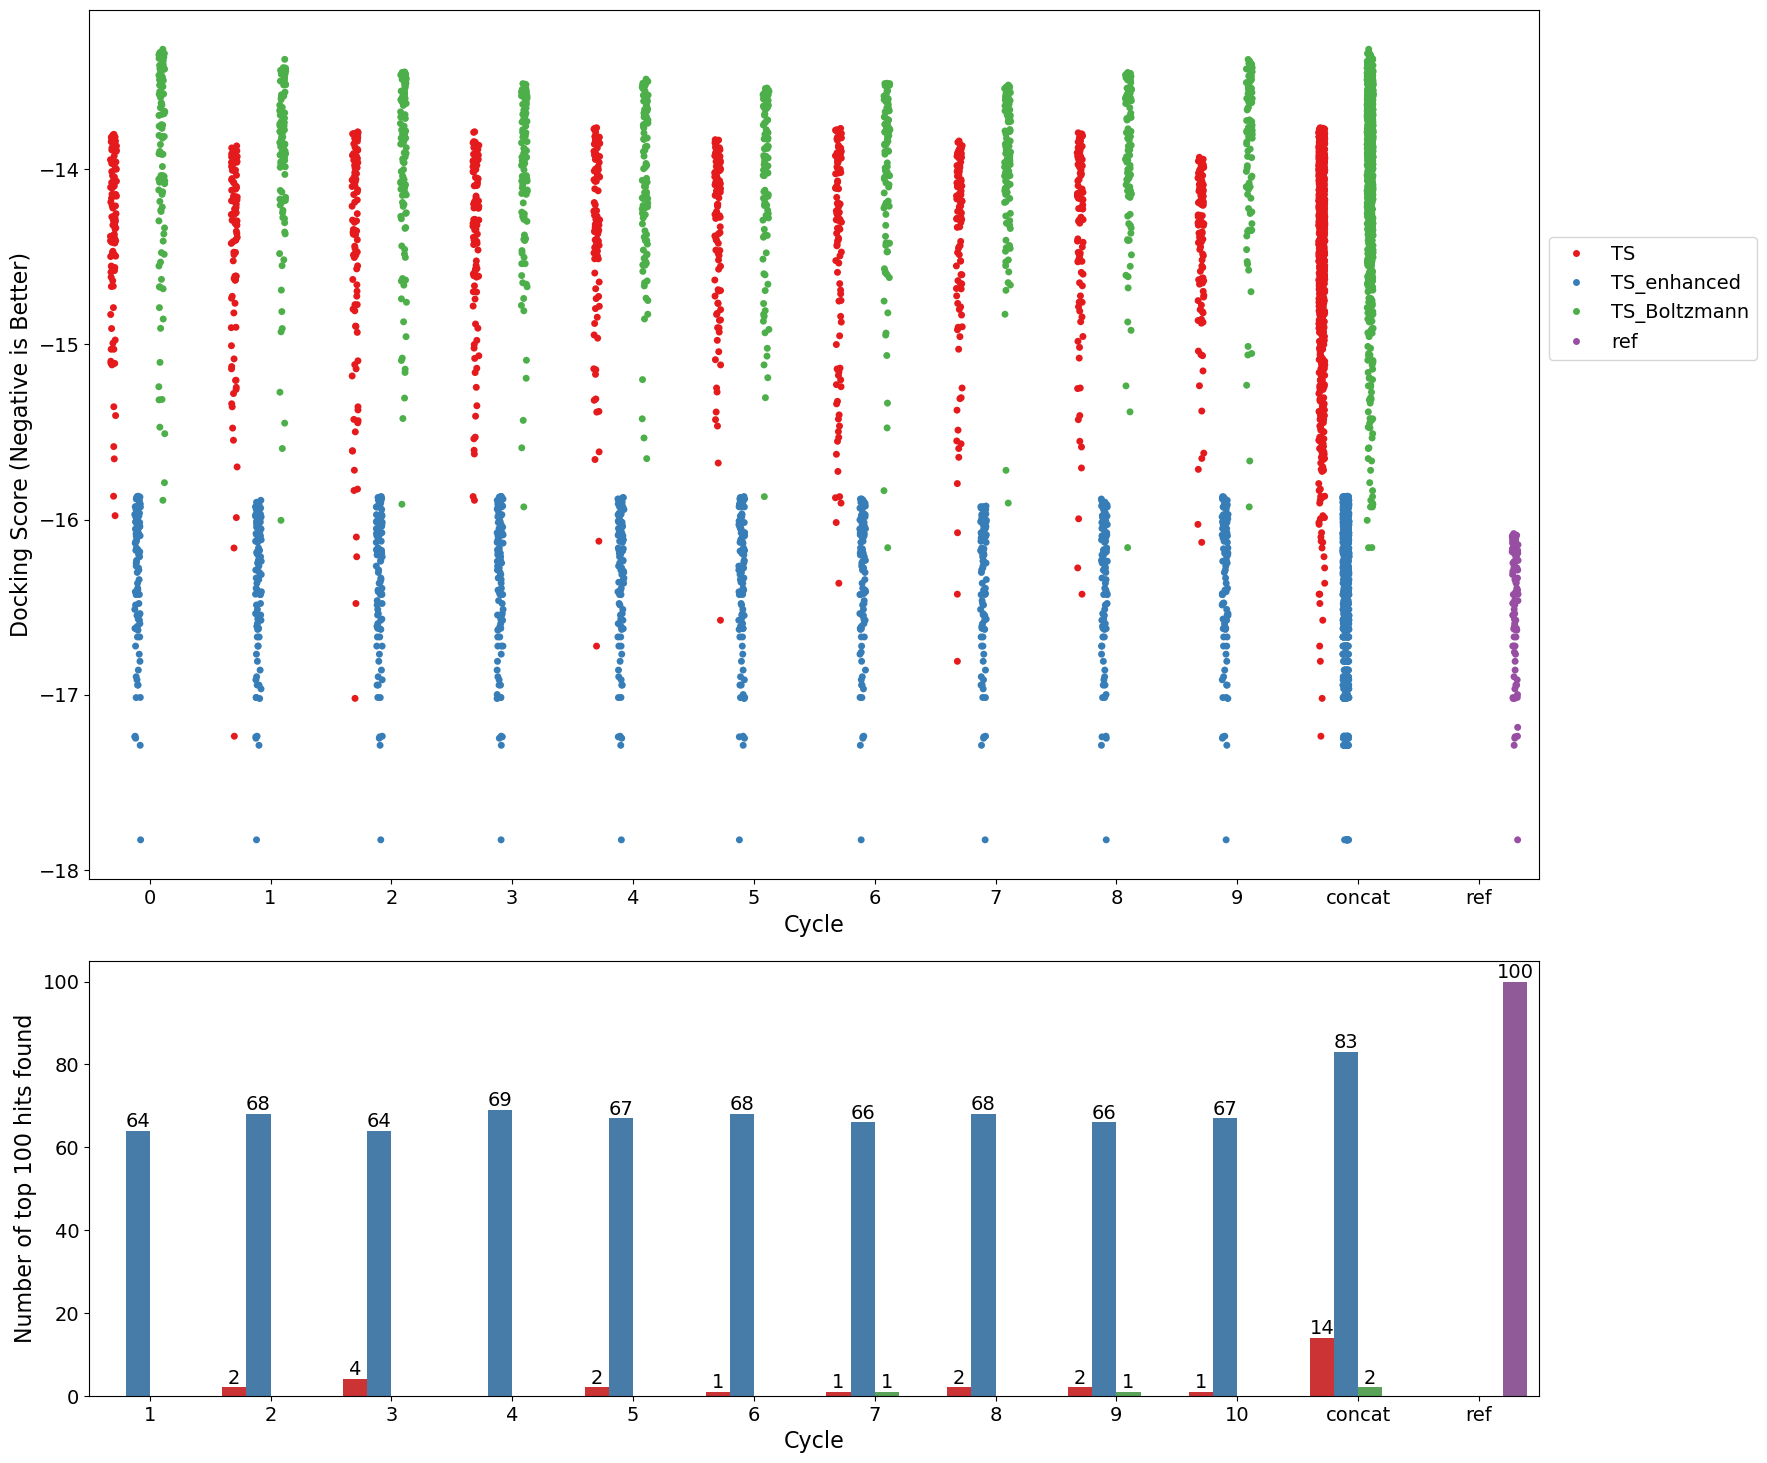

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 18), height_ratios=[2, 1])

# Define a consistent color palette and category order
palette_colors = sns.color_palette("Set1")[:4]
method_order = ["TS", "TS_enhanced", "TS_Boltzmann", "ref"]

# Make sure both dataframes have the same category order
combined_df.method = pd.Categorical(combined_df.method, categories=method_order, ordered=True)
plot_df.method = pd.Categorical(plot_df.method, categories=method_order, ordered=True)

# Top subplot (stripplot) with concatenated results
sns.stripplot(data=combined_df, x="cycle", y="score", hue="method", dodge=True, palette=palette_colors, ax=ax1)
ax1.set_ylabel("Docking Score (Negative is Better)", fontsize=16)
ax1.set_xlabel("Cycle", fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Bottom subplot (barplot)
sns.barplot(x="cycle", y="found", hue="method", data=plot_df, dodge=True, width=0.8, palette=palette_colors, ax=ax2)
# Remove the bottom legend
ax2.get_legend().remove()

# Add value labels to bars, only for non-zero values
for p in ax2.patches:
    height = p.get_height()
    if height > 0:  # Only add label if the value is greater than 0
        ax2.annotate(f'{int(height)}', 
                    xy=(p.get_x() + p.get_width()/2, height),
                    ha='center', va='bottom',
                    fontsize=14)

# Adjust font sizes for bottom plot
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel("Cycle", fontsize=16)
ax2.set_ylabel("Number of top 100 hits found", fontsize=16)

# Move the legend to the top of the figure and increase its font size
legend = ax1.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1, fontsize=14)

# Adjust layout with reduced spacing between plots
plt.subplots_adjust(right=0.85, hspace=0.125)

# Show the plot
plt.show()

This can at first look misleading, but the it is important to remember that the more negative the `ChemGauss` score the better it is. Hence, points at the bottom of the plot are better to see than those at the top. The reference presents the best set of molecules as seen from brute-force docking, we see that the Boltzmann sampling does not appear to find most of the hits, hence the Boltzmann sampling is not a useful method to use to find hits for this library.

## Enhanced Thompson Sampling

In [18]:
import copy
input_dict_enhanced_TS = copy.copy(input_dict)
input_dict_enhanced_TS["search_strategy"] = "thermal_cycling"
input_dict_enhanced_TS["processes"] = 1
input_dict_enhanced_TS["percent_of_library"] = 0.1
input_dict_enhanced_TS["scaling"] = -1
input_dict_enhanced_TS["temperature"] = 1

In [21]:
ts_enhanced_df = run_ts(input_dict_enhanced_TS)

  0%|          | 00:00<?, ?it/s

          score                                             SMILES  \
914   -4.123839  CN(CC(=O)NC(Cc1c[nH]c2ccc(O)cc12)C(N)=O)C(=O)C...   
10265 -4.306678  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C(CC2CCCCC2)NC(=O)...   
12112 -6.421888  NC(=O)COc1ccc2c(c1)CCc1ccccc1C2NC(=O)COc1ccc2c...   
7804  -6.683936  C#Cc1cccc(C(=O)NC(Cc2cn(C(=O)OC(C)(C)C)c3ccccc...   
11976 -6.707574  NC(=O)CN1CN(c2ccccc2)C2(CCN(C(=O)C(CC(=O)NC(c3...   
11611 -6.762105  COc1cc(C(=O)NC(CCC(=O)OC(C)(C)C)C(=O)N2CCC3(CC...   
9336  -6.947567  CC(C)Oc1ccc(C(=O)NC(CCC(=O)NC(c2ccccc2)(c2cccc...   
10710 -6.987574  NC(=O)COc1ccc2c(c1)CCc1ccccc1C2NC(=O)CN1CN(c2c...   
5989  -7.005450  CCCCCCCCCCCC(=O)NC(CC1CCCCC1)C(=O)NC(Cc1cn(C(=...   
3161  -7.045670  Cc1c(C)c(S(=O)(=O)NC(=N)NCCCC(NC(=O)C(Cc2cn(C(...   

                  Name  
914     CA50_AA41_AA23  
10265    CA5_AA28_AA61  
12112   CA55_AA18_AA18  
7804    CA72_AA61_AA51  
11976    CA11_AA51_AA3  
11611    CA95_AA54_AA3  
9336    CA99_AA55_AA60  
10710   CA122_AA3_AA18  
5989

In [20]:
ts_enhanced_df

score                                             SMILES  \
0     -15.846836          NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)c1ccc[nH]1   
1     -16.609692  CC1(C)Oc2ccc(CC(NC(=O)CNC(=O)c3ccc[nH]3)C(N)=O...   
2     -16.079922       C#Cc1cccc(C(=O)NCC(=O)NC(Cc2ccccc2)C(N)=O)c1   
3     -12.382708     NC(=O)C(Cc1ccccc1)NC(=O)CNC(=O)Cc1ccc2ncccc2c1   
4     -12.993114  CC1(C)Oc2ccc(CC(NC(=O)CNC(=O)Cc3ccc4ncccc4c3)C...   
...          ...                                                ...   
12416 -11.207310  NC(=O)C1(NC(=O)C(Cc2ccccc2)NC(=O)c2cc3ccccc3[n...   
12417 -10.713119  NC(=O)CN1CN(c2ccccc2)C2(CCN(C(=O)C(CC3CCCC3)NC...   
12418 -11.438033  NC(=O)C1CN(C(=O)C2CCCN2C2CCN(C(=O)c3ccc[nH]3)C...   
12419 -10.692624        COc1cc(C(=O)N(C)CC(=O)NC(C(N)=O)C2CC2)ccc1O   
12420 -12.627484  NC(=O)C(Cc1cc(Br)c(O)c(Br)c1)NC(=O)C1(NC(=O)c2...   

                  Name  
0      CA128_AA22_AA59  
1       CA128_AA22_AA0  
2       CA72_AA22_AA59  
3      CA125_AA22_AA59  
4       CA125_AA22_AA0  
...                ...  
12416   CA122_AA59_AA5  
12417   CA122_AA44_AA3  
12418  CA128_AA14_AA33  
12419   CA95_AA41_AA15  
12420    CA117_AA4_AA2  

[12421 rows x 3 columns]

In [22]:
ts_enhanced_df.sort_values(by="score", ascending=True).head(100)

score                                             SMILES  \
2070 -17.828762  CC(C)Oc1ccc(C(=O)NC(CC2CCCCC2)C(=O)NC(Cc2cn(C(...   
4151 -17.288765  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C(CC2CCCCC2)NC(=O)...   
408  -17.248438  COc1cc(C(=O)NC(CC2CCCCC2)C(=O)NC(Cc2cn(C(=O)OC...   
1235 -17.240562  CC(=O)Oc1ccc(C(=O)NC(CC2CCCCC2)C(=O)NC(Cc2cn(C...   
1899 -17.236963  CC(C)c1ccc(C(=O)NC(CC2CCCCC2)C(=O)NC(Cc2cn(C(=...   
...         ...                                                ...   
41   -15.889789     C#Cc1cccc(C(=O)NCC(=O)Nc2cc3ccccc3cc2C(N)=O)c1   
1720 -15.882493  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC3(CC3)CN2C(=O)...   
255  -15.881893  CC1(C)Oc2ccc(CC(NC(=O)CNC(=O)c3cccc(F)c3)C(N)=...   
692  -15.875209  CN(CC(=O)NC(Cc1cn(C(=O)OC(C)(C)C)c2ccccc12)C(N...   
370  -15.873747  NC(=O)C(Cc1ccc(O)c(Cl)c1)NC(=O)C(NC(=O)c1cccc(...   

                 Name  
2070   CA99_AA28_AA61  
4151  CA124_AA28_AA61  
408    CA95_AA28_AA61  
1235  CA116_AA28_AA61  
1899   CA30_AA28_AA61  
...               ...  
41     CA72_AA22_AA12  
1720   CA67_AA32_AA61  
255     CA55_AA22_AA0  
692   CA104_AA41_AA61  
370    CA117_AA6_AA21  

[100 rows x 3 columns]

In [16]:
truth_df = prod_scores_df.sort("Scores", descending=False).head(100).to_pandas()

In [19]:
truth_df

Product_Code     Scores
0    CA99_AA28_AA61 -17.828762
1   CA124_AA28_AA61 -17.288765
2    CA95_AA28_AA61 -17.248438
3   CA116_AA28_AA61 -17.240562
4    CA30_AA28_AA61 -17.236963
..              ...        ...
95   CA83_AA32_AA61 -16.092438
96   CA110_AA6_AA21 -16.090384
97   CA15_AA22_AA60 -16.089331
98   CA52_AA28_AA61 -16.087118
99   CA72_AA22_AA59 -16.079922

[100 rows x 2 columns]

In [17]:
top_100_ts_enhanced_df = ts_enhanced_df.sort_values(by="score", ascending=True).head(100)

In [21]:
len(list(set(truth_df["Product_Code"]) & set(top_100_ts_enhanced_df["Name"])))

66

In [14]:
ts_enhanced_df = ts_enhanced_df.rename(columns={"score":"Scores", "Name":"Product_Code"})

In [15]:
ts_enhanced_df_slice = ts_enhanced_df. sort_values(by="Scores", ascending=True).head(5000)

In [28]:
# Generate 10 runs of Boltzmann Sampling
ts_enhanced_df_list = []
for i in tqdm(range(0,10)):
    ts_enhanced_df_temp = run_ts(input_dict_enhanced_TS, hide_progress=True)
    ts_enhanced_df_temp = ts_enhanced_df_temp.sort_values(by="score", ascending=True).head(5000)
    ts_enhanced_df_list.append(ts_enhanced_df_temp)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
len(ts_enhanced_df_list[0])

5000

In [23]:
ts_enhanced_df_list[0]

Empty DataFrame
Columns: [score, SMILES, Name]
Index: []

In [40]:
prod_scores_df.sort(["Scores"], descending=False).head(100)
prod_scores_df.head(100).select(pl.col("Scores").min())


shape: (1, 1)
┌────────────┐
│ Scores     │
│ ---        │
│ f64        │
╞════════════╡
│ -17.021856 │
└────────────┘

In [39]:
prod_scores_df.head(100).select(pl.col("Scores").max())

shape: (1, 1)
┌───────────┐
│ Scores    │
│ ---       │
│ f64       │
╞═══════════╡
│ -14.25128 │
└───────────┘

In [31]:
ts_df_list[0].sort_values(by="score", ascending=True).head(100)

score                                             SMILES  \
10855 -16.115461  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC3(CC3)CN2C(=O)...   
10775 -15.402205  NC(=O)C1(NC(=O)C(Cc2c[nH]c3ccc(O)cc23)NC(=O)c2...   
11072 -15.215828  CC1(C)Oc2ccc(CC(NC(=O)C3CSCN3C(=O)c3cccc(Cl)c3...   
9471  -15.055716  CC1(C)Oc2ccc(CC(NC(=O)C(CC3CCCCC3)NC(=O)COc3cc...   
10902 -14.875488  CCCCCCCCC(NC(=O)c1cnc2ccccc2c1)C(=O)N1c2ccccc2...   
...          ...                                                ...   
6573  -13.175703     NC(=O)c1ccc(NC(=O)CN2CCN(C(=O)c3cccnc3)CC2)cc1   
8622  -13.174807  CC(C)(C)OC(=O)NCCCCC(NC(=O)c1cc2ccccc2cc1NC(=O...   
6485  -13.173211  CC(C)c1ccc(C(=O)N2CCN(CC(=O)Nc3ccc(C(N)=O)cc3)...   
11007 -13.170613  Cn1c(C(=O)NC(Cc2ccco2)C(=O)NC(CC(N)=O)Cc2ccc(F...   
7590  -13.168535  NC(=O)CC(Cc1ccc(F)c(F)c1)NC(=O)COc1ccc2c(c1)CC...   

                  Name  
10855   CA57_AA32_AA61  
10775    CA19_AA23_AA5  
11072    CA15_AA24_AA0  
9471      CA6_AA28_AA0  
10902   CA61_AA25_AA11  
...                ...  
6573    CA57_AA29_AA36  
8622   CA122_AA12_AA56  
6485    CA30_AA29_AA36  
11007   CA33_AA38_AA10  
7590   CA118_AA18_AA10  

[100 rows x 3 columns]

In [33]:
ts_boltzmann_df_list[0].sort_values(by="score", ascending=True).head(100)

score                                             SMILES  \
6493  -17.248438  COc1cc(C(=O)NC(CC2CCCCC2)C(=O)NC(Cc2cn(C(=O)OC...   
7502  -16.594027  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC3(CC3)CN2C(=O)...   
8842  -16.392218  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC(F)(F)CN2C(=O)...   
9596  -16.190895  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CC(F)(F)CN2C(=O)...   
7646  -16.189180  COc1cccc(CC(=O)N(C)CC(=O)NC(Cc2cn(C(=O)OC(C)(C...   
...          ...                                                ...   
5719  -14.759386  CC(C)(C)OC(=O)n1cc(CC(NC(=O)c2cc3ccccc3[nH]2)C...   
10107 -14.754563  NC(=O)C1CSCN1C(=O)C(Cc1cn(C(c2ccccc2)(c2ccccc2...   
1627  -14.737959  CC1(C)Oc2ccc(CC(NC(=O)C3CC4(CC4)CN3C(=O)c3cccc...   
6934  -14.731882  CC(C)(C)OC(=O)n1cc(CC(NC(=O)C2CSCN2C(=O)C2CCCC...   
1358  -14.726181  Cn1c(C(=O)NCC2CCC(C(=O)N3CCCC3C(N)=O)CC2)cc2cc...   

                  Name  
6493    CA95_AA28_AA61  
7502    CA69_AA32_AA61  
8842    CA55_AA37_AA61  
9596    CA15_AA37_AA61  
7646   CA119_AA41_AA61  
...                ...  
5719   CA122_AA61_AA35  
10107   CA96_AA57_AA24  
1627    CA113_AA32_AA0  
6934    CA42_AA24_AA61  
1358    CA33_AA17_AA48  

[100 rows x 3 columns]

### How much does the Enhanced TS recover using Docking as the Scoring Function?

In [41]:
# Ground Truth
prod_scores_df_pd = prod_scores_df.to_pandas()
top_5k_truth = prod_scores_df_pd.sort_values(by="Scores", ascending=True).head(5000)

In [42]:
# Lets look at the an Instance of each of the TS methods
# Re run this if the the dataframes need to be reset
ts_std_df = ts_df_list[0].copy()
ts_enhanced_df = ts_enhanced_df_list[0].copy()
ts_boltzmann_df = ts_boltzmann_df_list[0].copy()

In [43]:
ts_dfs = [ts_std_df, ts_enhanced_df, ts_boltzmann_df]
ts_types = ["TS", "TS_enhanced", "TS_Boltzmann"]
top_5k = {}
for n, df in enumerate(ts_dfs):
    df_temp = df.sort_values(by="score", ascending=True).head(5000)
    df_temp.drop(columns=["SMILES"],inplace=True)
    df_temp.rename(columns={"score":"Scores", "Name":"Product_Code"},inplace=True)
    top_5k[ts_types[n]] = df_temp


In [44]:
top_5k["TS"] = top_5k["TS"][["Product_Code"]].assign(standard=True)
top_5k["TS_enhanced"] = top_5k["TS_enhanced"][["Product_Code"]].assign(enhanced=True)
top_5k["TS_Boltzmann"] = top_5k["TS_Boltzmann"][["Product_Code"]].assign(boltzmann=True)

In [45]:
# Merge the dataframes
df_top = pd.merge(pd.merge(pd.merge(top_5k_truth, top_5k["TS"], how="left", on="Product_Code"),
                  top_5k["TS_enhanced"], how="left", on="Product_Code"),
                  top_5k["TS_Boltzmann"], how="left", on="Product_Code")
df_top.head()

Product_Code     Scores standard enhanced boltzmann
0   CA99_AA28_AA61 -17.828762      NaN     True       NaN
1  CA124_AA28_AA61 -17.288765      NaN     True       NaN
2   CA95_AA28_AA61 -17.248438      NaN     True      True
3  CA116_AA28_AA61 -17.240562      NaN     True       NaN
4   CA30_AA28_AA61 -17.236963      NaN     True       NaN

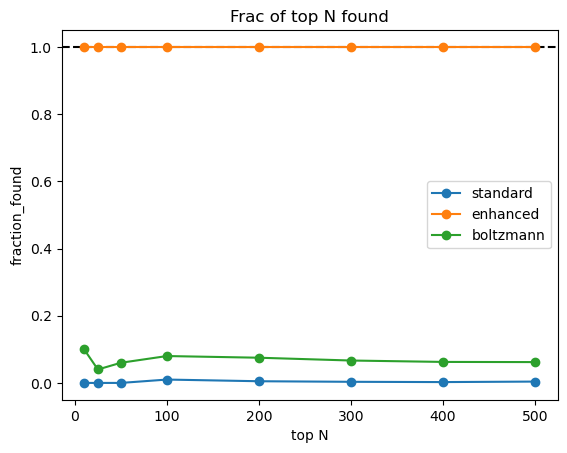

In [46]:
fig, ax = plt.subplots()
top_ns = [10, 25, 50, 100, 200, 300, 400, 500]
for col in ["standard", "enhanced", "boltzmann"]:
    ax.plot(top_ns, [df_top.head(n)[col].sum() / n for n in top_ns], label=col, marker="o")
ax.set_xlabel("top N")
ax.set_ylabel("fraction_found")
ax.axhline(1, color="k", linestyle="--", zorder=0)
ax.set_title("Frac of top N found")
ax.legend()
pass

It appears that the standard TS slightly underperforms the enhanced TS. The Boltzmann sampling's performance remains poor despite increasing the cutoff for the top n compounds.

In [131]:
# We are interested in looking at the plot with error bars
# Lets generate these error bars using the cycle data
ts_comp = []
ts_types = ["TS", "TS_enhanced", "TS_Boltzmann"] # Types of TS to compare
for n in range(0,10):
    # Get the top 5000 compounds for each method
    # Rename columns
    ts_dfs_temp = [ts_df_list[n].copy(), ts_enhanced_df_list[n].copy(), ts_boltzmann_df_list[n].copy()]
    ts_dfs_temp = [x.sort_values(by="score", ascending=True).head(5000) for x in ts_dfs_temp]
    ts_dfs_temp = [x.drop(columns=["SMILES"]) for x in ts_dfs_temp]
    ts_dfs_temp = [x.rename(columns={"score":"Scores", "Name":"Product_Code"}) for x in ts_dfs_temp]
    top_5k_temp = {}
    for n, ts_type in enumerate(ts_types):
        top_5k_temp[ts_type] = ts_dfs_temp[n] # Assign the appropriate dataframe to the dictionary
        if n == 0: # Standard TS
            top_5k_temp[ts_type] = top_5k_temp[ts_type][["Product_Code"]].assign(standard=True)
        elif n == 1: # Enhanced TS
            top_5k_temp[ts_type] = top_5k_temp[ts_type][["Product_Code"]].assign(enhanced=True)
        else: # Boltzmann TS
            top_5k_temp[ts_type] = top_5k_temp[ts_type][["Product_Code"]].assign(boltzmann=True)
    # Merge the dataframes
    df_top = pd.merge(pd.merge(pd.merge(top_5k_truth, top_5k_temp["TS"], how="left", on="Product_Code"),
                  top_5k_temp["TS_enhanced"], how="left", on="Product_Code"),
                  top_5k_temp["TS_Boltzmann"], how="left", on="Product_Code")
    # Calculate the fraction of hits found for each method
    ts_comp.append(df_top)

    

In [137]:
top_ns = [10, 25, 50, 100, 200, 300, 400, 500]
top_ns_frac = pd.DataFrame(columns=["cycle","top_n", "method", "frac_top_n"])
for cycle_id, ts_comp_df in enumerate(ts_comp):
    for col in ["standard", "enhanced", "boltzmann"]:
        for n in top_ns:
            frac_top_ns = ts_comp_df.head(n)[col].sum() / n
            row = {"cycle":cycle_id, "top_n":n, "method":col, "frac_top_n":frac_top_ns}
            top_ns_frac = pd.concat([top_ns_frac, pd.DataFrame([row])], ignore_index=True)
top_ns_frac.head()

/var/folders/sn/gcrsw56j5k93g0p6gnkvvn7c0000gn/T/ipykernel_50688/2920588413.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_ns_frac = pd.concat([top_ns_frac, pd.DataFrame([row])], ignore_index=True)


cycle top_n    method  frac_top_n
0     0    10  standard        0.50
1     0    25  standard        0.64
2     0    50  standard        0.64
3     0   100  standard        0.58
4     0   200  standard        0.51

In [139]:
# Generate dataframe with mean, std and count of frac_top_n for each top_n and method
grouped_stats = top_ns_frac.groupby(['top_n', 'method'])['frac_top_n'].agg(
    mean='mean',
    std='std',
    count='count'
).reset_index()

print(grouped_stats)

    top_n     method      mean       std  count
0      10  boltzmann  0.110000  0.087560     10
1      10   enhanced  0.820000  0.078881     10
2      10   standard  0.650000  0.084984     10
3      25  boltzmann  0.096000  0.060222     10
4      25   enhanced  0.788000  0.077860     10
5      25   standard  0.704000  0.060222     10
6      50  boltzmann  0.082000  0.034577     10
7      50   enhanced  0.828000  0.057504     10
8      50   standard  0.716000  0.057194     10
9     100  boltzmann  0.074000  0.029889     10
10    100   enhanced  0.683000  0.036225     10
11    100   standard  0.601000  0.024698     10
12    200  boltzmann  0.058500  0.022614     10
13    200   enhanced  0.601500  0.022242     10
14    200   standard  0.537000  0.031640     10
15    300  boltzmann  0.056667  0.012472     10
16    300   enhanced  0.557333  0.024282     10
17    300   standard  0.503333  0.024646     10
18    400  boltzmann  0.055000  0.008580     10
19    400   enhanced  0.546250  0.019230

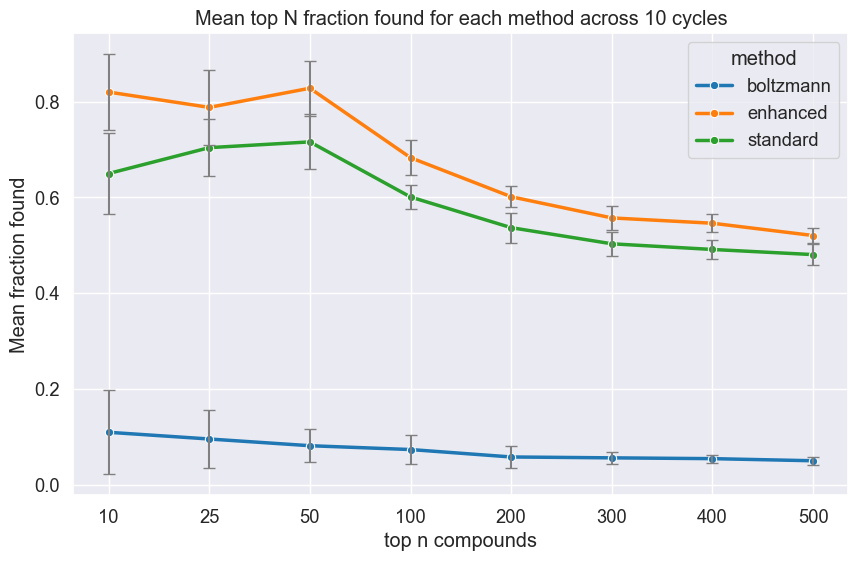

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) # set the size of the plot
sns.set_theme(style="darkgrid", palette="tab10", font_scale=1.2)

# Ensure sub_category is sortable (e.g., categorical or ordered)
grouped_stats['top_n'] = grouped_stats['top_n'].astype(str)

# Line plot per category with error bars
sns.lineplot(
    data=grouped_stats,
    x='top_n',
    y='mean',
    hue='method',  # color line by category
    marker='o',
    errorbar=None,
    linewidth=2.5  # Disable built-in CI
)

# Add error bars manually using plt.errorbar
for _, row in grouped_stats.iterrows():
    if pd.notnull(row['std']):
        plt.errorbar(
            x=row['top_n'],
            y=row['mean'],
            yerr=row['std'],
            fmt='none',
            capsize=4,
            ecolor='gray'
        )

plt.title("Mean top N fraction found for each method across 10 cycles")
plt.xlabel("top n compounds")
plt.ylabel("Mean fraction found")
plt.show()

In [ ]:
fig, ax = plt.subplots()
top_ns = [10, 25, 50, 100, 200, 300, 400, 500]
for col in ["standard", "enhanced", "boltzmann"]:
    for ts_comp_df in ts_comp:
        ax.plot(top_ns, [ts_comp_df.head(n)[col].sum() / n for n in top_ns], label=col, marker="o")
ax.set_xlabel("top N")
ax.set_ylabel("fraction_found")
ax.axhline(1, color="k", linestyle="--", zorder=0)
ax.set_title("Frac of top N found")
ax.legend()

In [118]:
# Extract the product codes as a list
product_codes = ts_enhanced_df["Name"].to_list()

# Initialize counters for each position
position_counters = []

# Iterate through the product codes
for product_code in product_codes:
    building_blocks = product_code.split("_")  # Split the product code by "_"
    # Ensure the position_counters list is large enough to handle all positions
    while len(position_counters) < len(building_blocks):
        position_counters.append(Counter())
    # Update the counters for each position
    for i, block in enumerate(building_blocks):
        position_counters[i][block] += 1

# Find the top 20 building blocks for each position
for i, counter in enumerate(position_counters):
    print(f"Top 20 building blocks for position {i + 1}:")
    print(f"{'Building Block':<20}{'Frequency':<10}")
    print("-" * 30)
    for block, count in counter.most_common(20):
        print(f"{block:<20}{count:<10}")
    print("\n")

Top 20 building blocks for position 1:
Building Block      Frequency 
------------------------------
CA122               701       
CA117               673       
CA72                471       
CA128               464       
CA95                392       
CA55                369       
CA15                257       
CA96                242       
CA111               212       
CA11                193       
CA88                47        
CA64                45        
CA92                44        
CA125               34        
CA57                30        
CA9                 27        
CA79                27        
CA33                21        
CA114               19        
CA99                18        


Top 20 building blocks for position 2:
Building Block      Frequency 
------------------------------
AA28                448       
AA22                300       
AA32                221       
AA61                210       
AA37                200       
AA23                1

In [119]:
# Collect the top 20 building blocks for each position
top_20_building_blocks_per_position = []
for counter in position_counters:
    top_20_blocks = [block for block, _ in counter.most_common(20)]
    top_20_building_blocks_per_position.append(top_20_blocks)

# Convert the list to a tuple
top_20_building_blocks_tuple = tuple(top_20_building_blocks_per_position)

Top 20 Building Blocks for Position 1


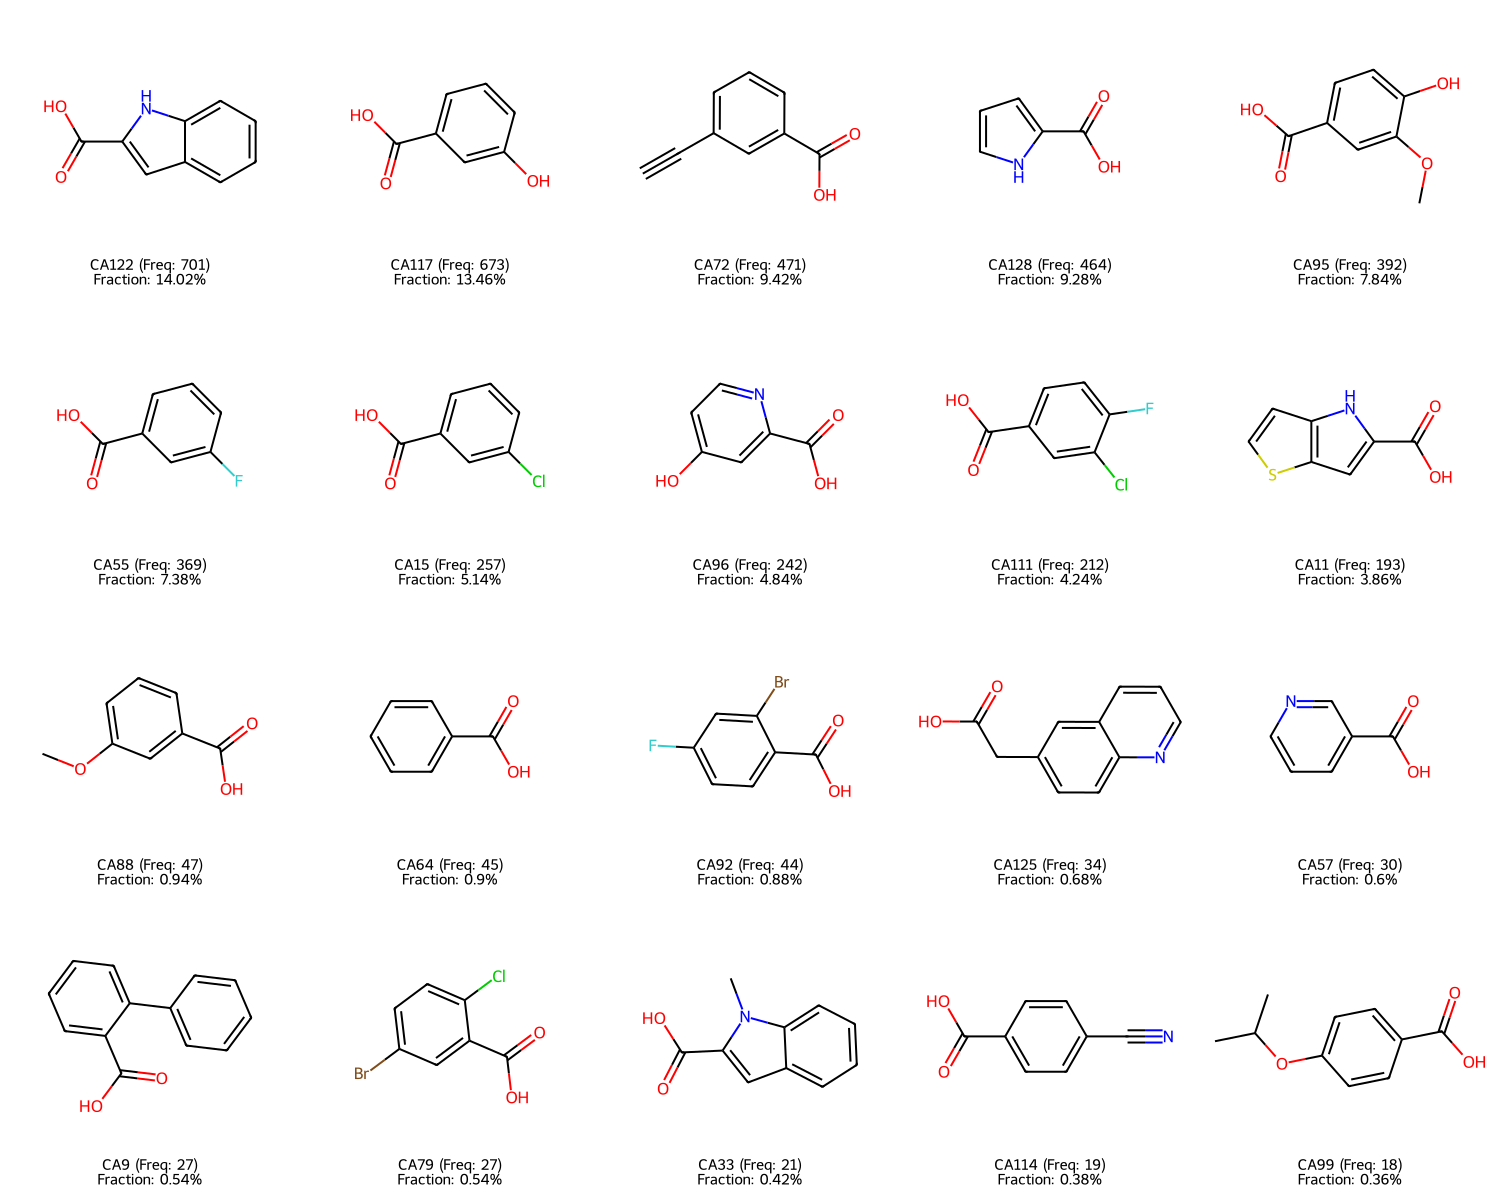

Top 20 Building Blocks for Position 2


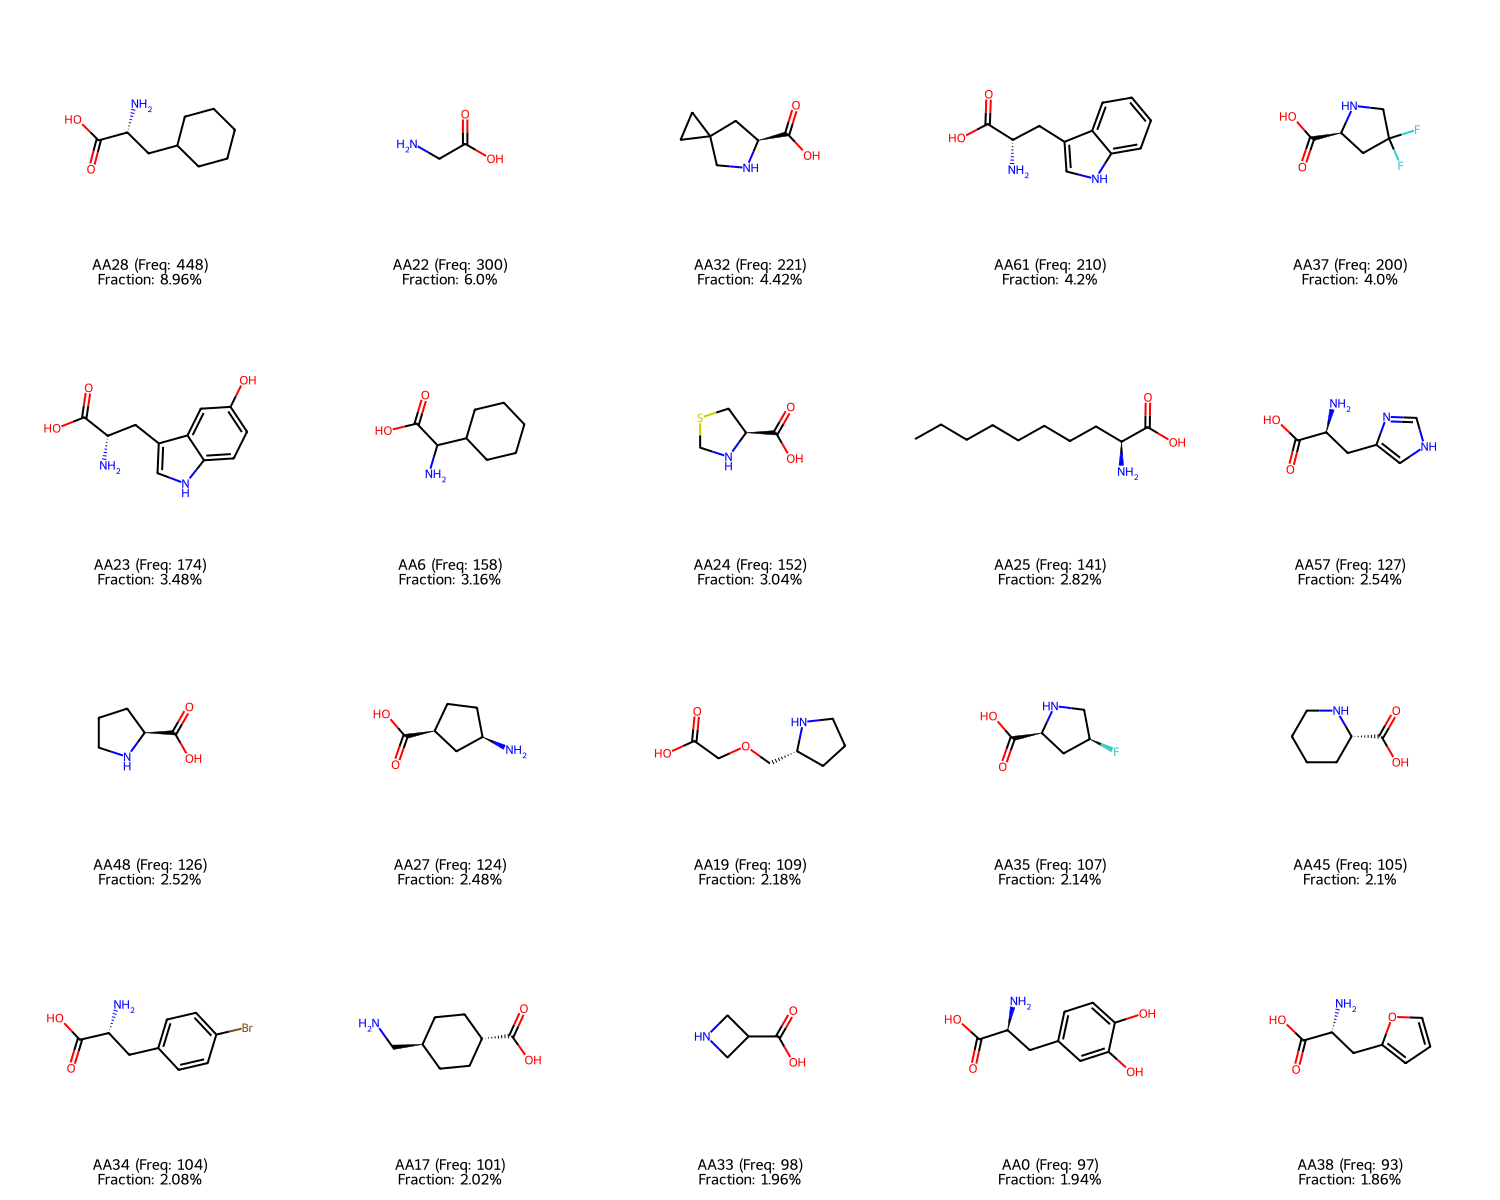

Top 20 Building Blocks for Position 3


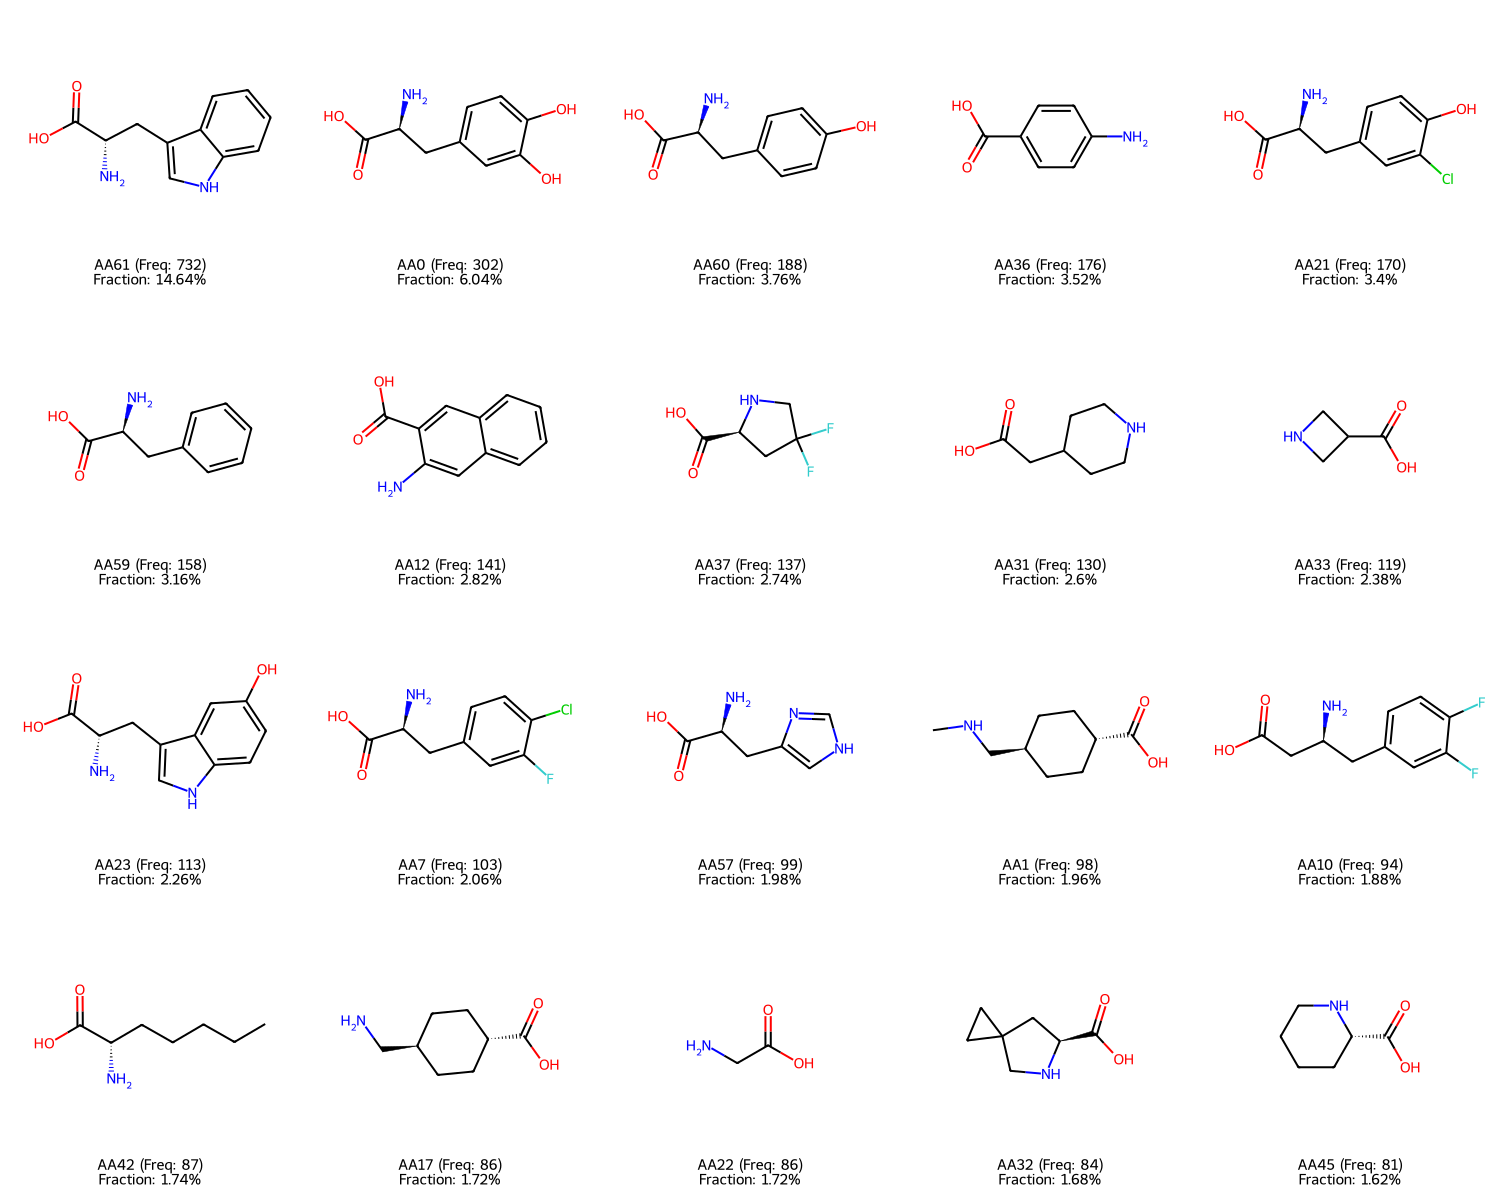

In [120]:
total_molecules = 5000  # The top 1% of products
# Combine the two dictionaries
combined_smiles_dict = {**amino_acid_bb_dict, **acids_bb_dict}

# Iterate through each position's top 20 building blocks
for i, counter in enumerate(position_counters):
    # Get the top 20 building blocks for the current position
    top_20_blocks = counter.most_common(20)
    
    # Create a list of RDKit molecules and their labels
    mols = []
    legends = []
    for block, freq in top_20_blocks:
        if block in combined_smiles_dict:  # Use the combined dictionary
            smiles = combined_smiles_dict[block]
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                mols.append(mol)
                # Add building block name and frequency on the first line, fraction on the second line
                legends.append(f"{block} (Freq: {freq})\nFraction: {round((freq / total_molecules) * 100, 2)}%")
    
    # Visualize the molecules in a grid
    img = Draw.MolsToGridImage(
        mols, legends=legends, molsPerRow=5, subImgSize=(300, 300)
    )
    
    # Display the title and the image
    print(f"Top 20 Building Blocks for Position {i + 1}")
    display(img)  # Display the image in the Jupyter Notebook